# AutoEncoder for CSC

###  Import and function definition

In [8]:
import pandas as pd
import numpy as np
import math, time, copy
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from torchvision import datasets, transforms
from torch.optim.lr_scheduler import ReduceLROnPlateau

from drawing_utilities import *
from ResNet import *
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("You are using:", device)

You are using: cuda


### Loading Data from previous strep

In [9]:
out_label = "130824"
me = "hRHGlobalm2"
data = np.load(me+'_'+out_label+'_s1.npz')
selected_chamber = data["imgs"]
#selected_chamber = [selected_chamber[m] for m in range(len(selected_chamber)) if data["bad_flag"][m]==1]

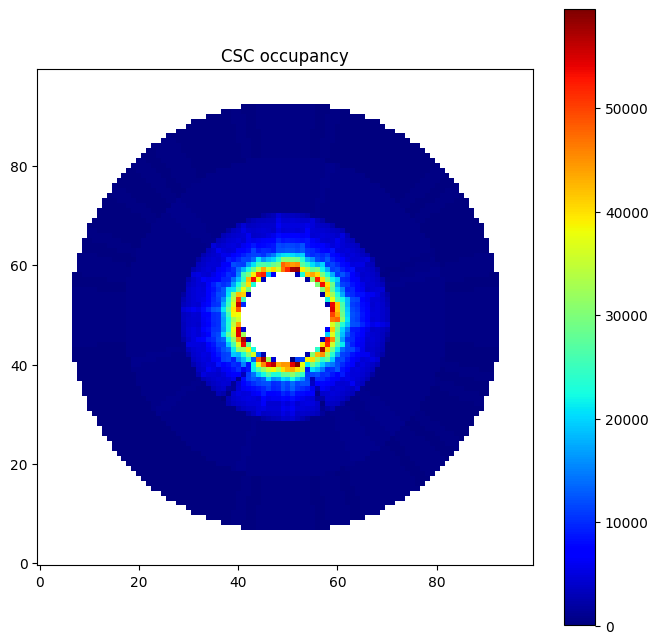

In [3]:
mean_matrix = np.mean(selected_chamber, axis=0)
dim = len(selected_chamber)
Show2Dimg(mean_matrix)
mean_matrix[mean_matrix == 0] = np.nan

In [4]:
tensor_list = [(torch.tensor(m, dtype=torch.float32)).unsqueeze(0) for m in selected_chamber]
print(tensor_list[0].size())
training_dim = int(dim*0.85)
indices = torch.randperm(dim)
training_tensor = [tensor_list[i] for i in indices[:training_dim]]
validation_tensor = [tensor_list[i] for i in indices[training_dim:]]
print(f"Data ({len(selected_chamber)}) = Training sample ({len(training_tensor)}) + Validation sample ({len(validation_tensor)})")

torch.Size([1, 100, 100])
Data (8551) = Training sample (7268) + Validation sample (1283)


In [5]:
#for k in range(len(validation_tensor)):
#    for i in range(50, 100):
#        for j in range(50, 100):
#            if (i<1.3*j-15 and i>0.7*j+15):
#                validation_tensor[k][0][i][j]=0

In [6]:
training_dataset = TensorDataset(*training_tensor)
validation_dataset = TensorDataset(*validation_tensor)

training_loader = DataLoader(dataset=training_tensor, 
                             batch_size=64, 
                             num_workers=10, 
                             shuffle=True)

validation_loader = DataLoader(dataset=validation_tensor, 
                               batch_size=64,
                               num_workers=10, 
                               shuffle=False)

### Training Loop

In [10]:
# NEW training loop
img_size = list(tensor_list[0].squeeze(0).size())
ae = ResNetAE(1, 3, [16, 32, 64], img_size=img_size).to(device)
optimizer = optim.Adam(ae.parameters(), lr=2.e-4)
scheduler = ReduceLROnPlateau(optimizer, 'min', factor=0.5, patience=2, threshold=0.02,verbose=True)
train_loss, val_loss =[], []
epochs = 50
min_val_loss = 1e6
best_model_state = None
no_improve_epochs = 0
patience = 3  # Number of epochs to wait before stopping
threshold = 0.01

for e in range(epochs):
    epoch = e+1
    print(f'***** Training Epoch {epoch} *****')
    ae.train()
    now = time.time()
    tloss=[]
    for i, figure in enumerate(training_loader):
        X = figure.to(device)
        optimizer.zero_grad()
        Xreco = ae(X)
        
        loss = F.l1_loss(Xreco, X)
        tloss.append(loss.item())
        loss.backward()
        optimizer.step()
        if i%70 ==0:
            print(f'>> [{i}/{len(training_loader)}] Train loss:{loss.item()}')
    train_loss.append(np.mean(tloss))
    now = time.time() - now
    print(f"'>> Training time: {now/60:.2f} min in {len(training_loader)} steps")
    print(f"Evaluating on validation set")
    ae.eval()
    vloss = []
    with torch.no_grad():
        for i,figure in enumerate(validation_loader):
            X_val = figure.to(device)
            Xreco_val = ae(X_val)
            loss_val = F.l1_loss(Xreco_val, X_val)
            vloss.append(loss_val.item())
    avg_val_loss = np.mean(vloss)
    val_loss.append(avg_val_loss)
    print(f'>> Validation loss: {avg_val_loss}')
    scheduler.step(np.mean(vloss))

    print(f"current minium is: {min_val_loss}, relative diff is {(min_val_loss - avg_val_loss) / min_val_loss}")

    if (min_val_loss - avg_val_loss) / min_val_loss < threshold:
        no_improve_epochs += 1 
    else:
        min_val_loss = avg_val_loss
        best_model_state = ae.state_dict()
        no_improve_epochs = 0
    print(f"no improve epochs: {no_improve_epochs}")


    # Stop training if validation loss didn't improve for 'patience' epochs
    if no_improve_epochs >= patience:
        print("Early stopping triggered.")
        break

# Save the best model state after all epochs
torch.save(best_model_state, "model_"+out_label+".pth")

***** Training Epoch 1 *****


/lustrehome/mbuonsante/miniconda3/envs/pytorch/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


>> [0/114] Train loss:1586.4298095703125
>> [70/114] Train loss:580.476806640625
'>> Training time: 0.33 min in 114 steps
Evaluating on validation set
>> Validation loss: 462.49132138206846
current minium is: 1000000.0, relative diff is 0.9995375086786179
no improve epochs: 0
***** Training Epoch 2 *****
>> [0/114] Train loss:442.8216247558594
>> [70/114] Train loss:364.74853515625
'>> Training time: 0.16 min in 114 steps
Evaluating on validation set
>> Validation loss: 350.8540533156622
current minium is: 462.49132138206846, relative diff is 0.24138240633964597
no improve epochs: 0
***** Training Epoch 3 *****
>> [0/114] Train loss:359.85546875
>> [70/114] Train loss:302.8556823730469
'>> Training time: 0.16 min in 114 steps
Evaluating on validation set
>> Validation loss: 306.70435587565106
current minium is: 350.8540533156622, relative diff is 0.12583493627274647
no improve epochs: 0
***** Training Epoch 4 *****
>> [0/114] Train loss:301.6226501464844
>> [70/114] Train loss:285.3025

### Validation dataset

***** batch 0 *****
 >> Example 0
 >> Original image:


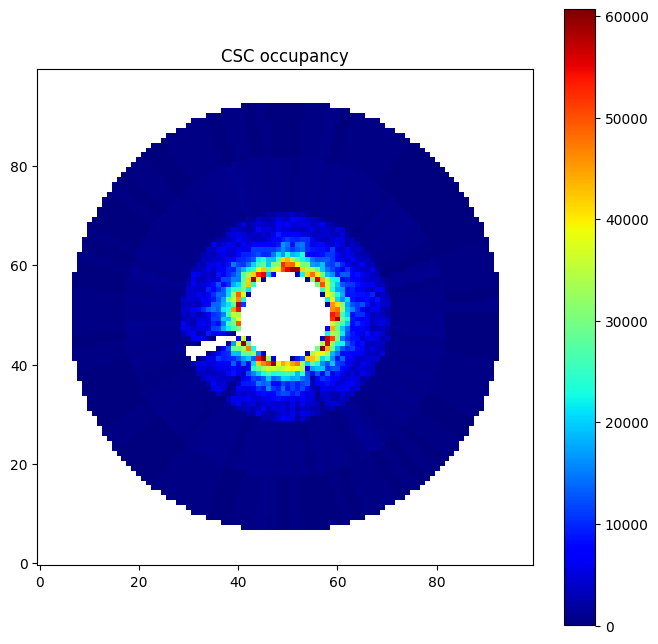

 >> AE-reco image:


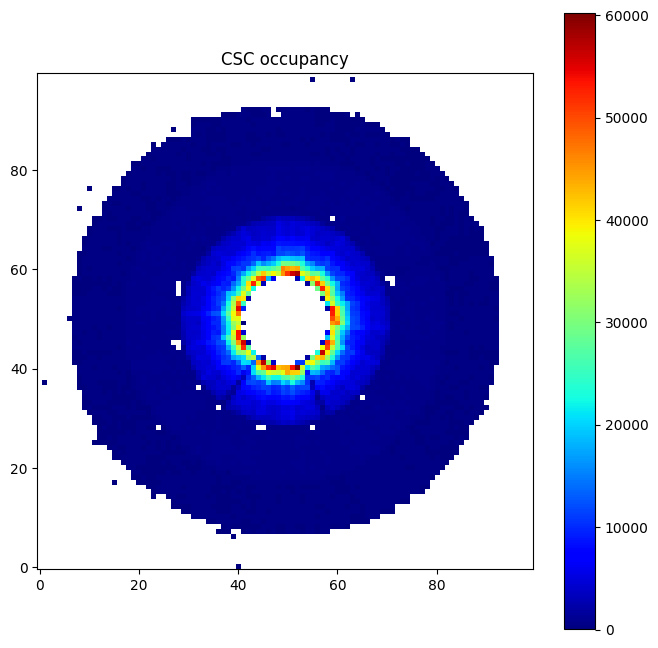

 >> Normalized loss map:


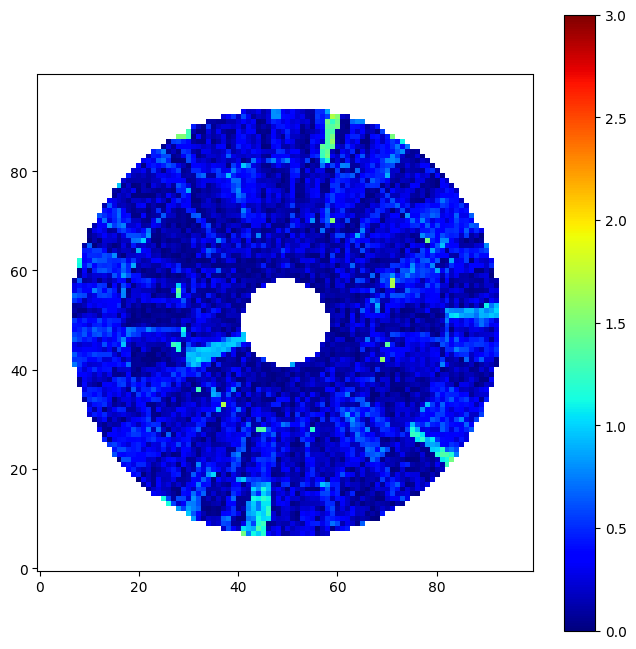

 >> Example 1
 >> Original image:


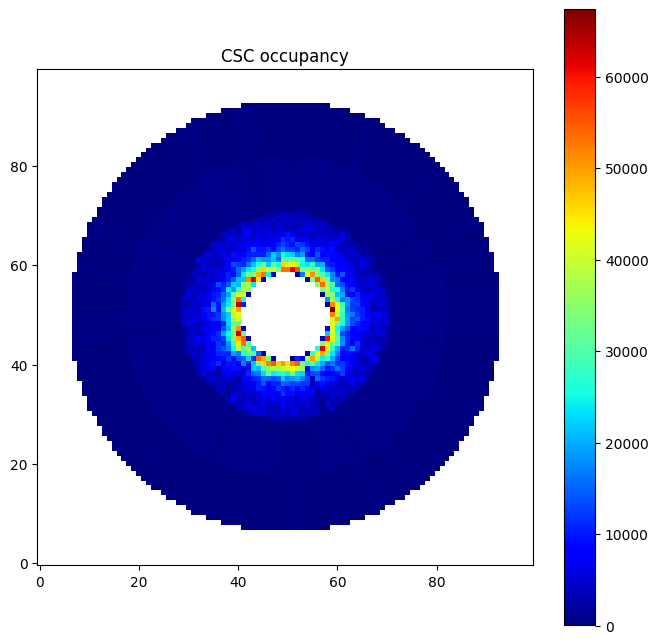

 >> AE-reco image:


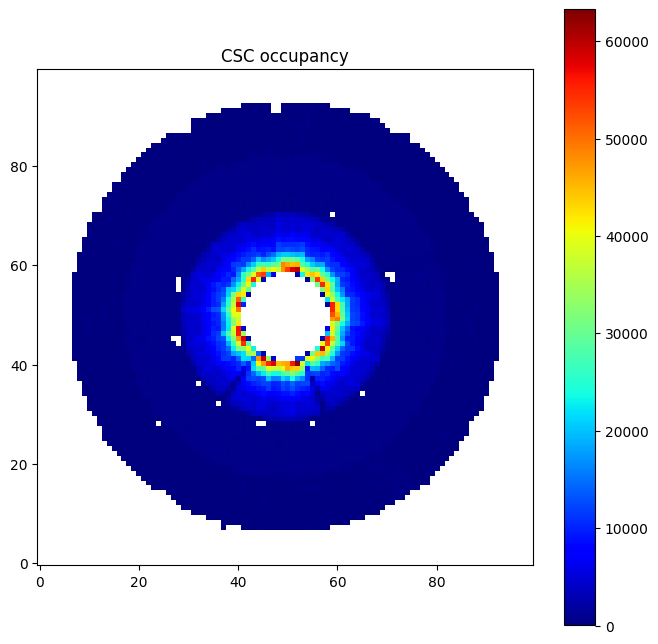

 >> Normalized loss map:


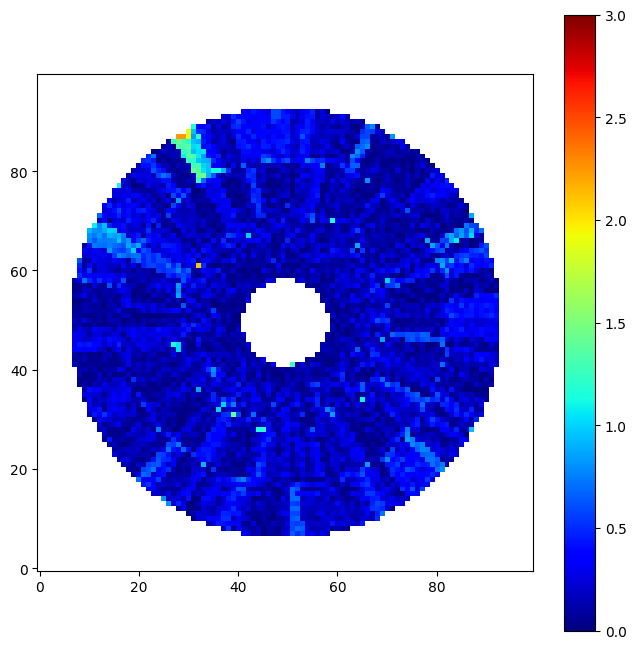

 >> Example 2
 >> Original image:


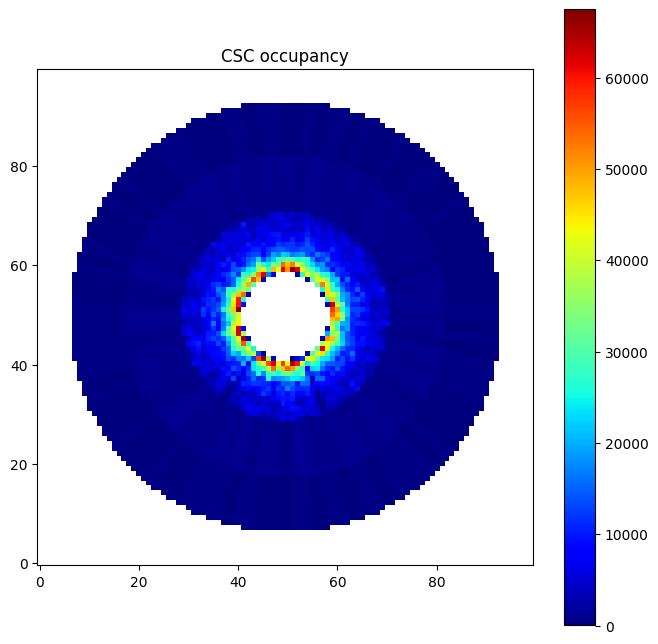

 >> AE-reco image:


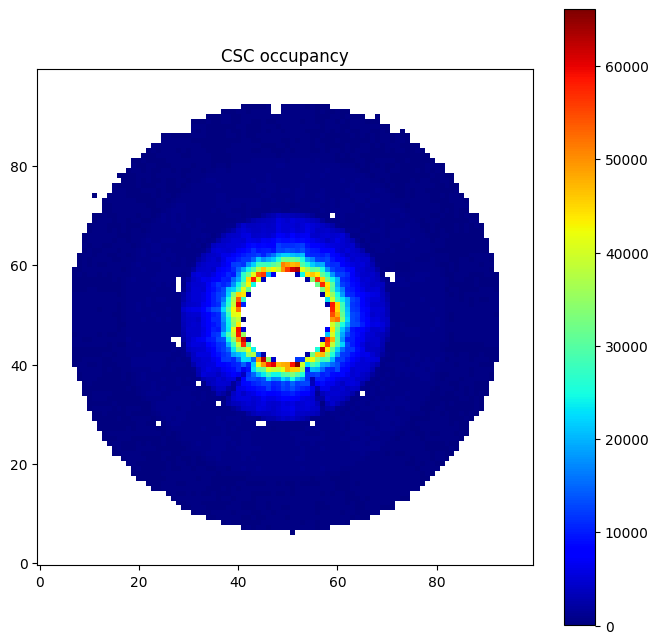

 >> Normalized loss map:


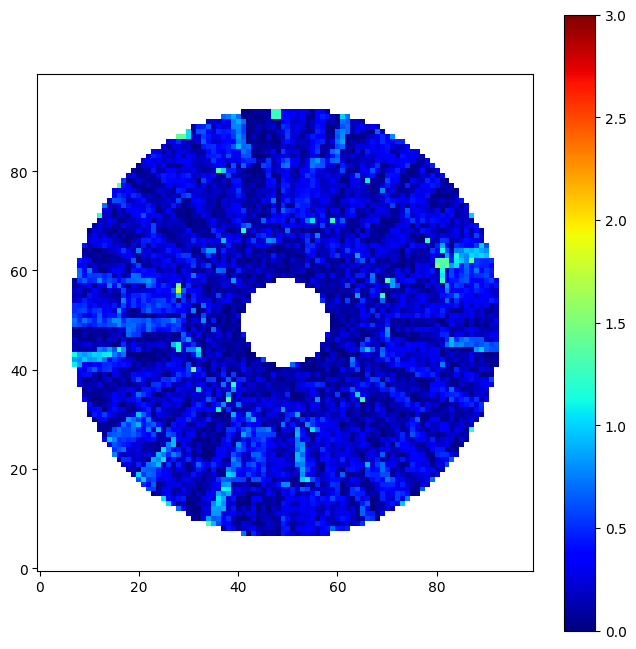

 >> Example 3
 >> Original image:


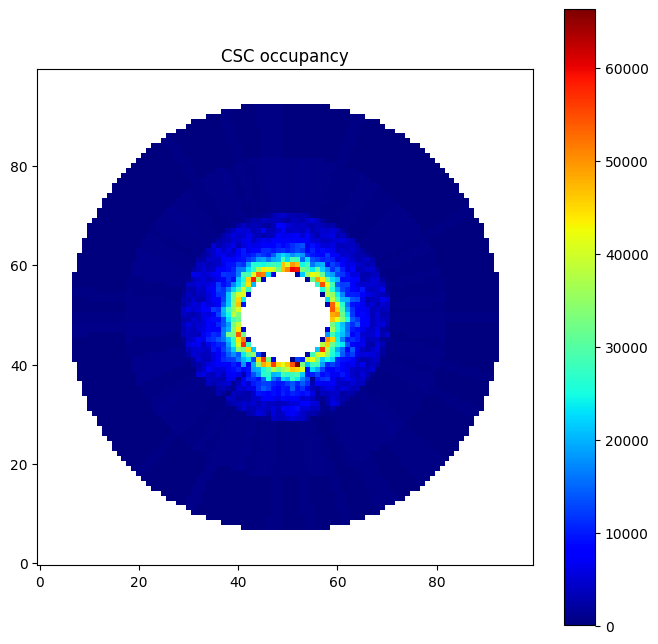

 >> AE-reco image:


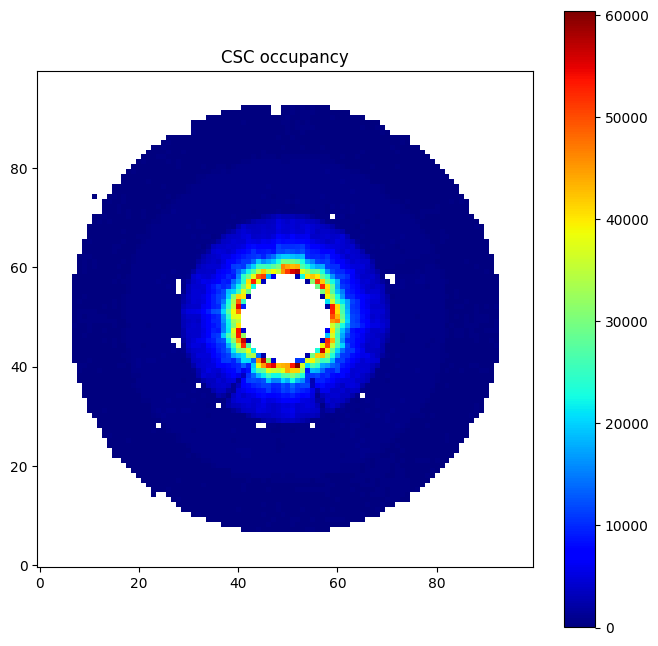

 >> Normalized loss map:


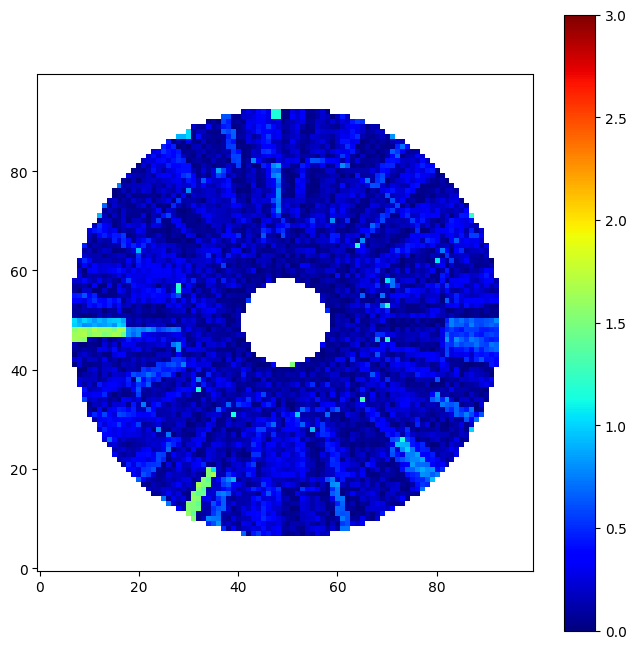

***** batch 1 *****
 >> Example 0
 >> Original image:


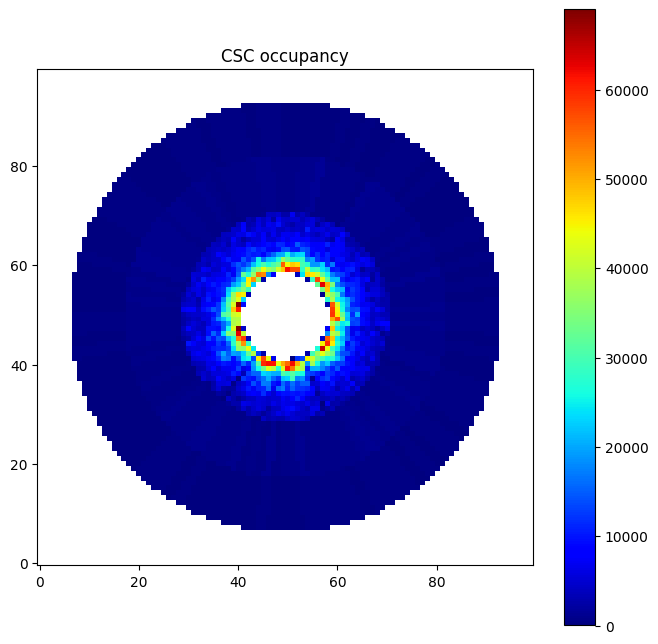

 >> AE-reco image:


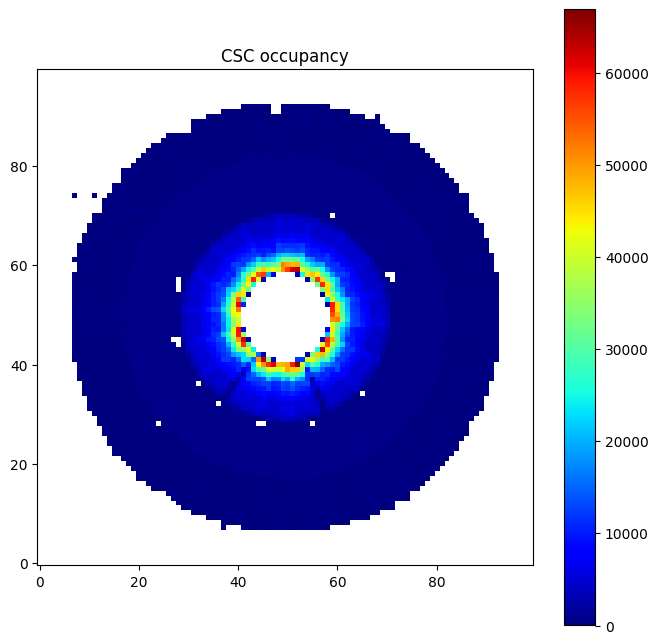

 >> Normalized loss map:


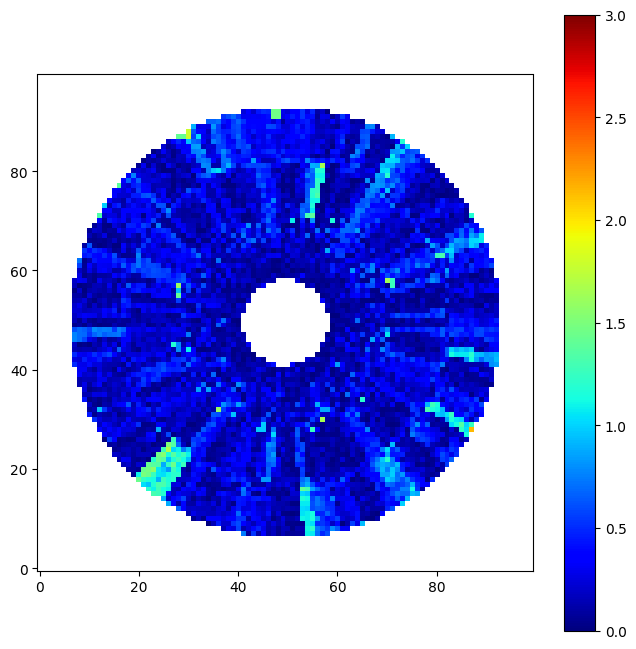

 >> Example 1
 >> Original image:


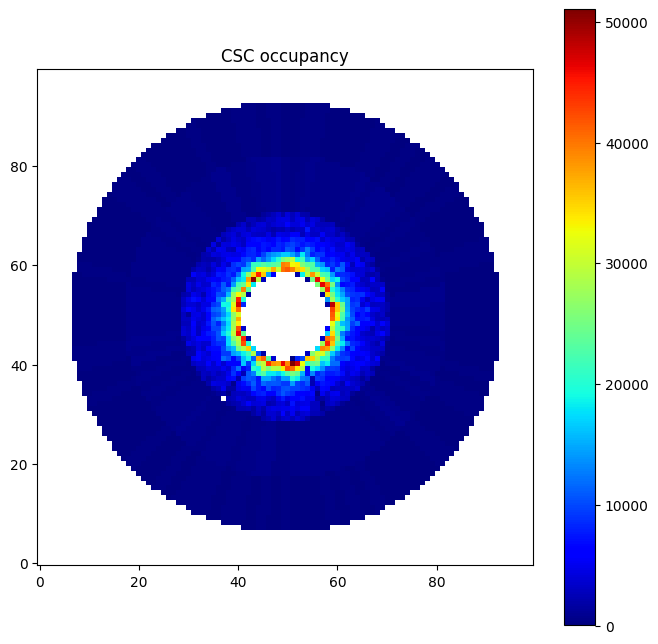

 >> AE-reco image:


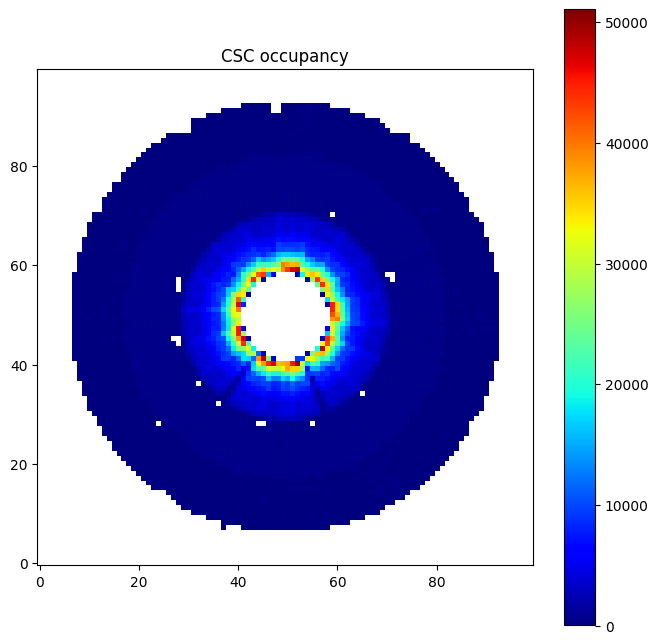

 >> Normalized loss map:


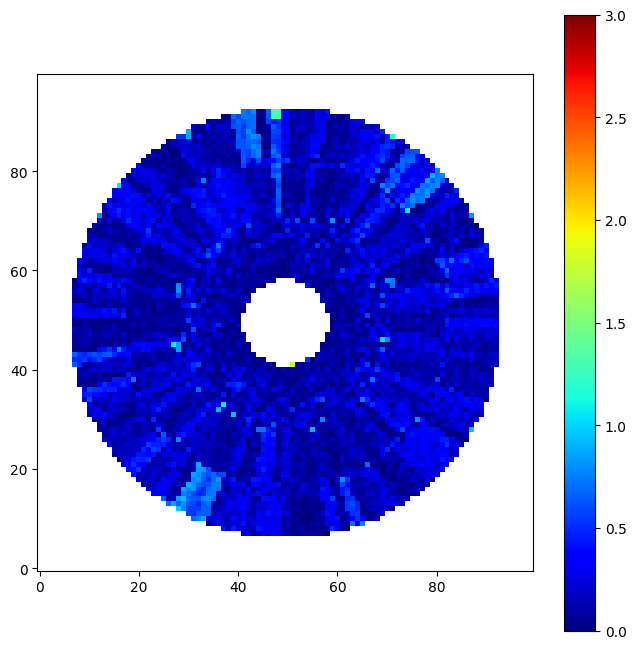

 >> Example 2
 >> Original image:


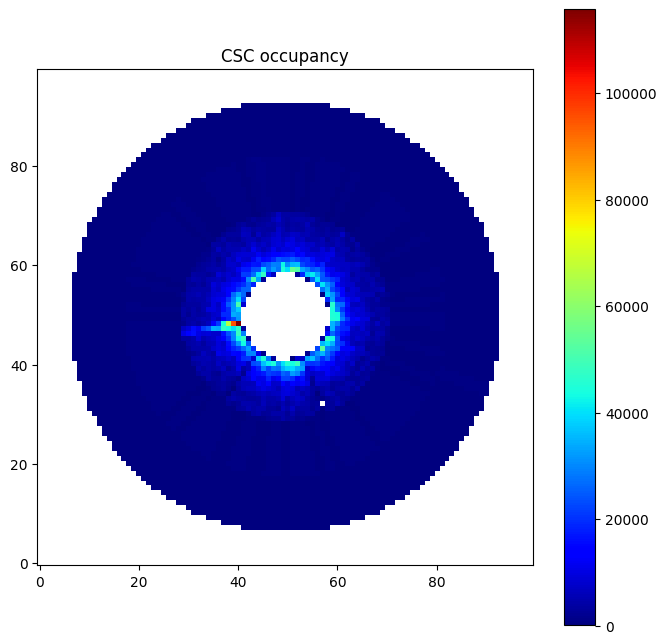

 >> AE-reco image:


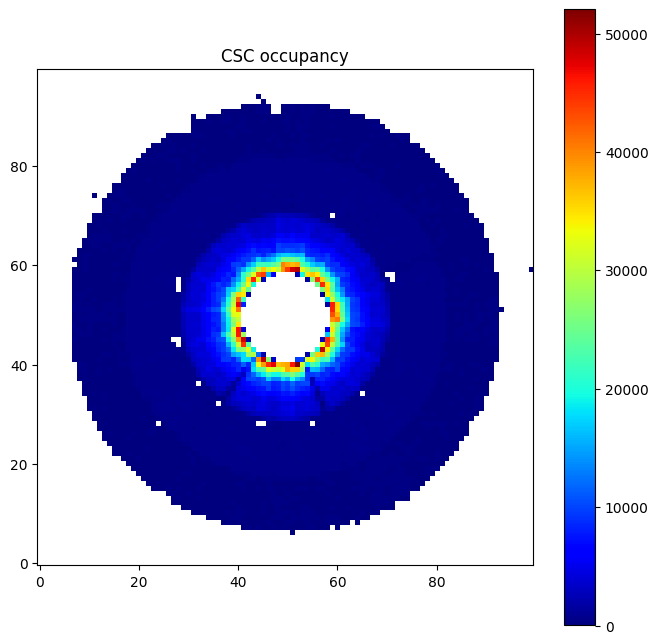

 >> Normalized loss map:


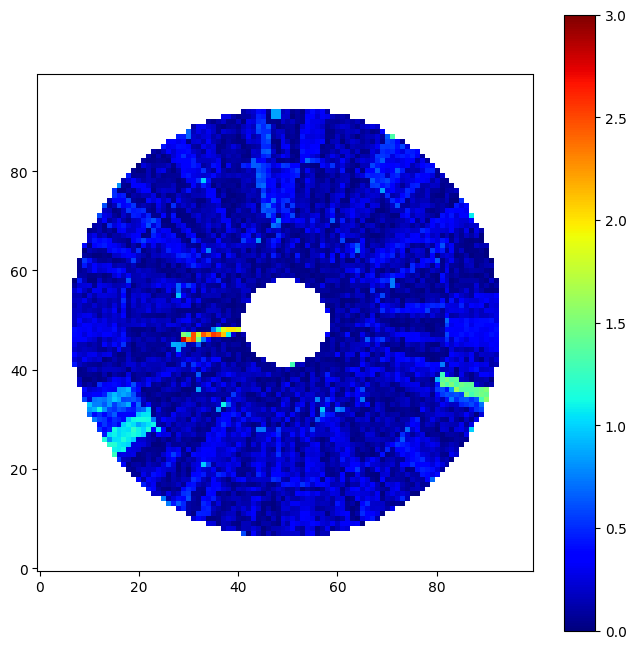

 >> Example 3
 >> Original image:


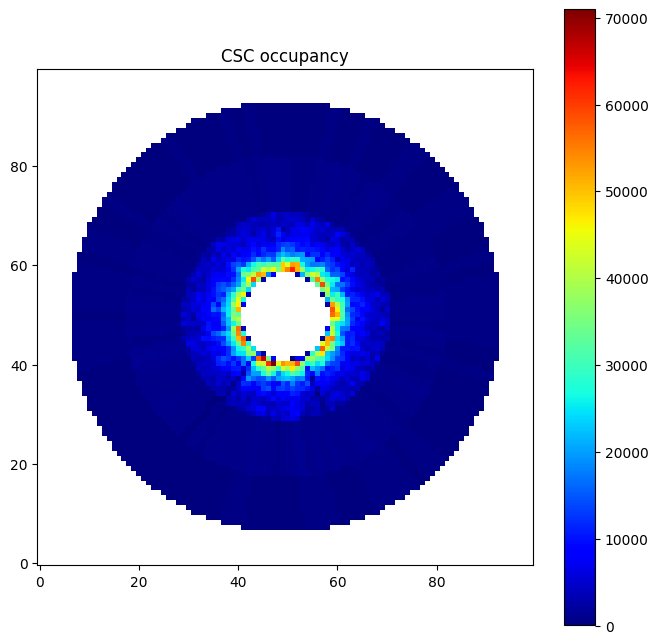

 >> AE-reco image:


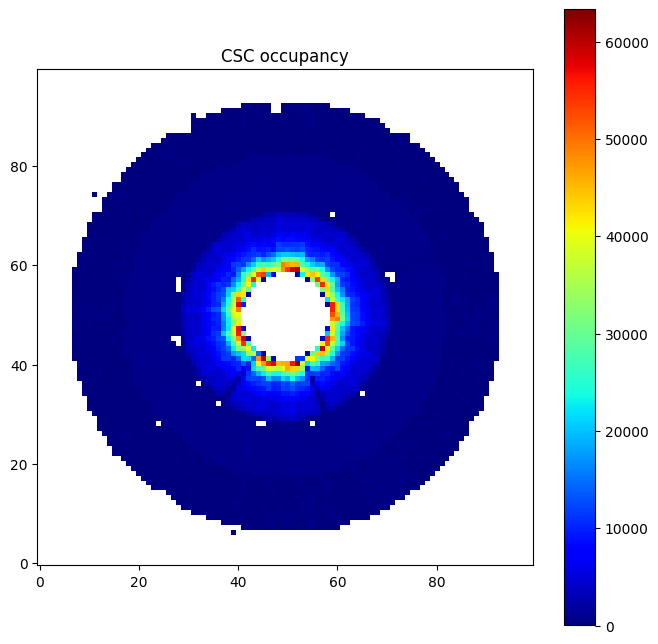

 >> Normalized loss map:


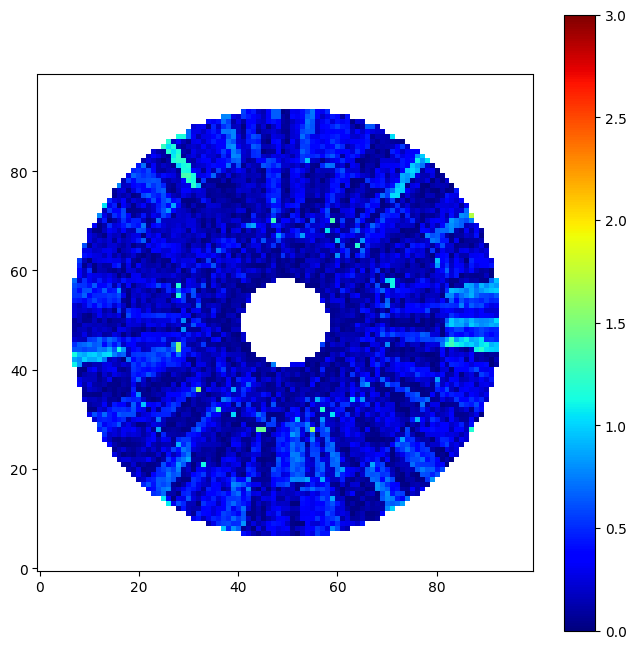

***** batch 2 *****
 >> Example 0
 >> Original image:


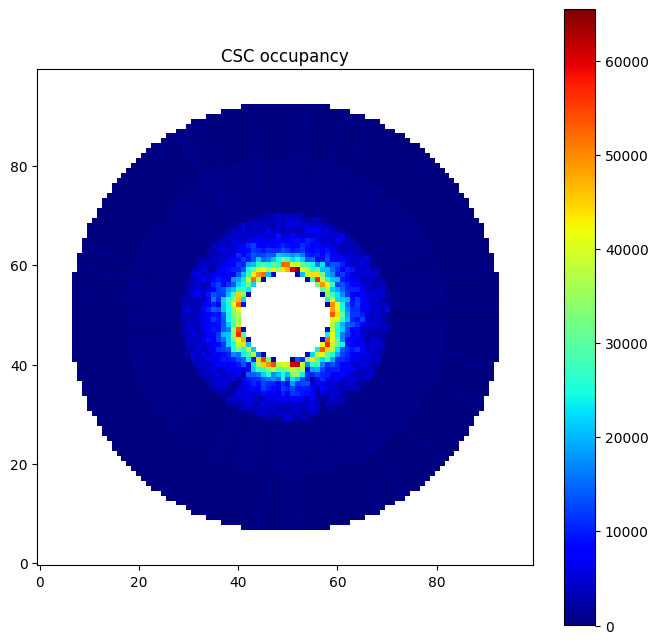

 >> AE-reco image:


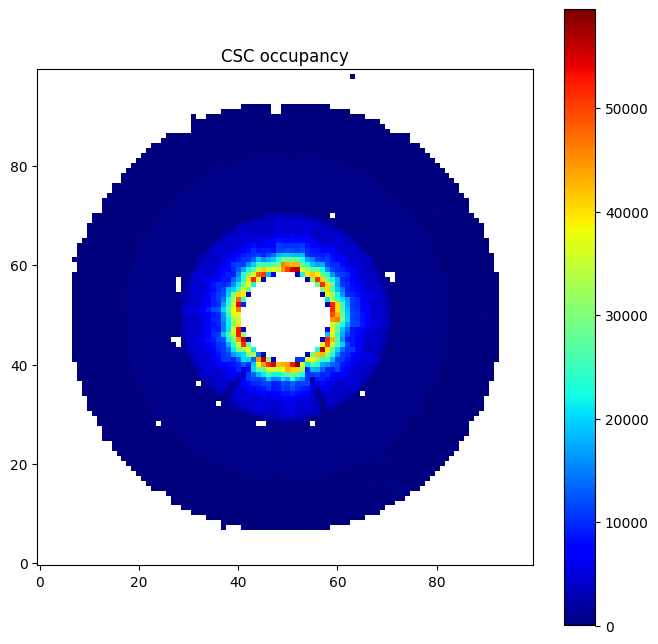

 >> Normalized loss map:


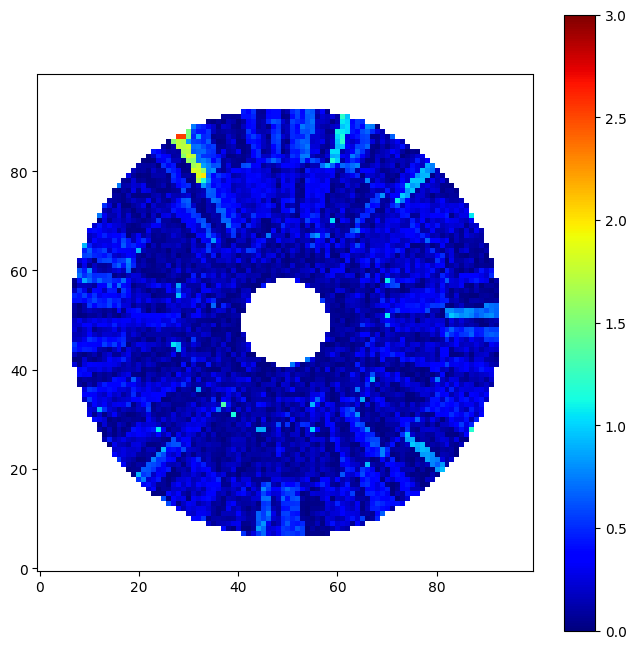

 >> Example 1
 >> Original image:


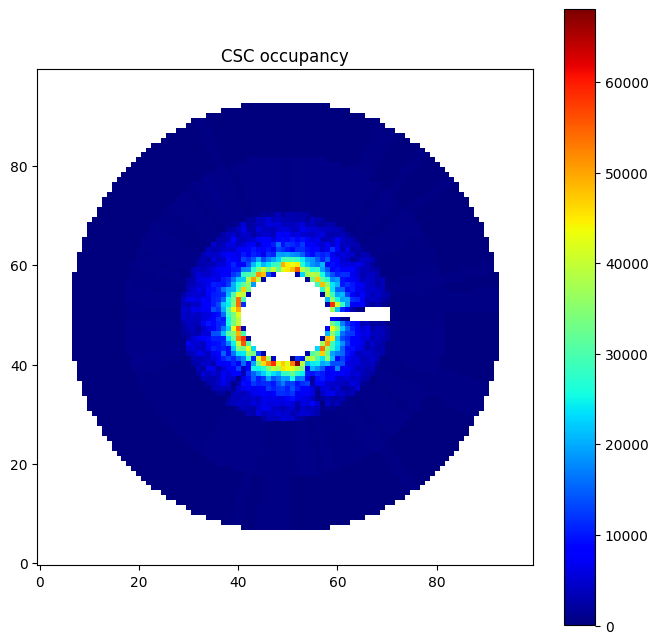

 >> AE-reco image:


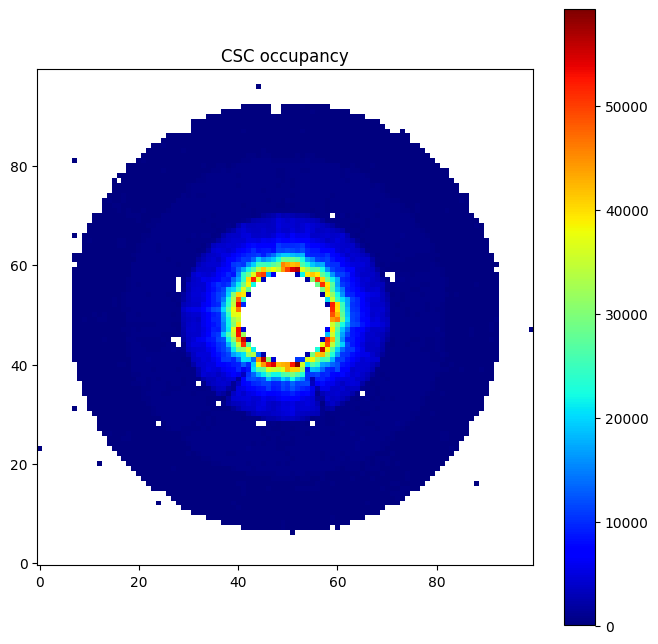

 >> Normalized loss map:


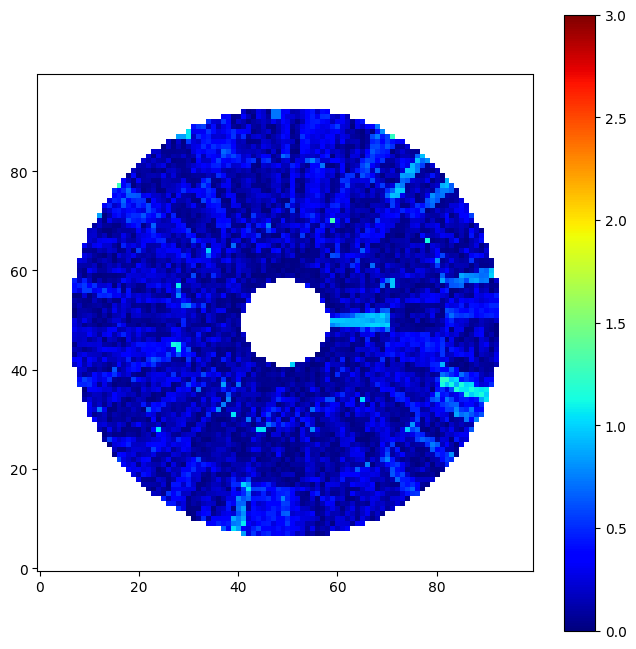

 >> Example 2
 >> Original image:


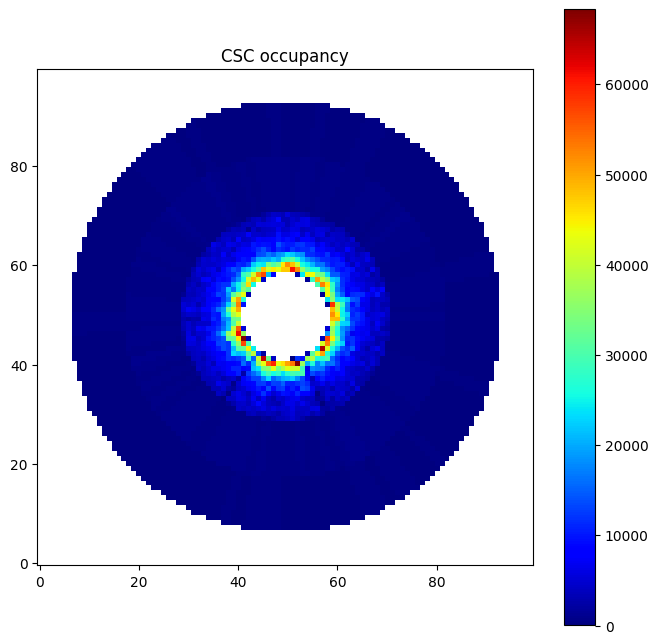

 >> AE-reco image:


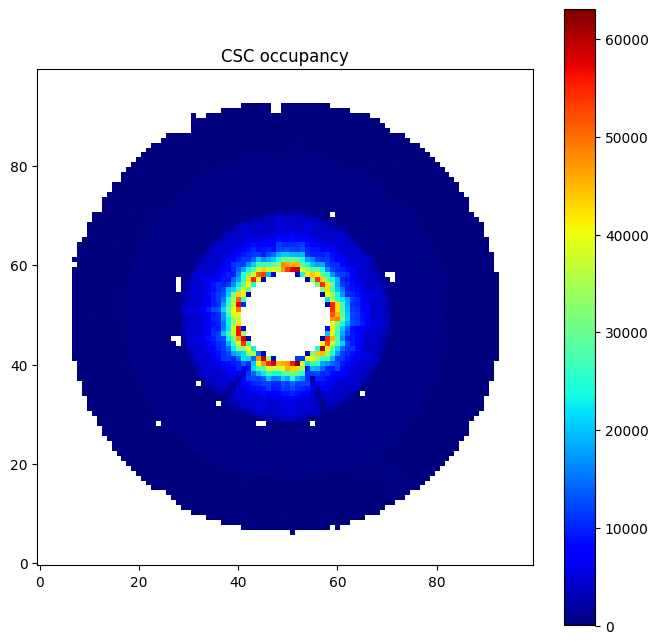

 >> Normalized loss map:


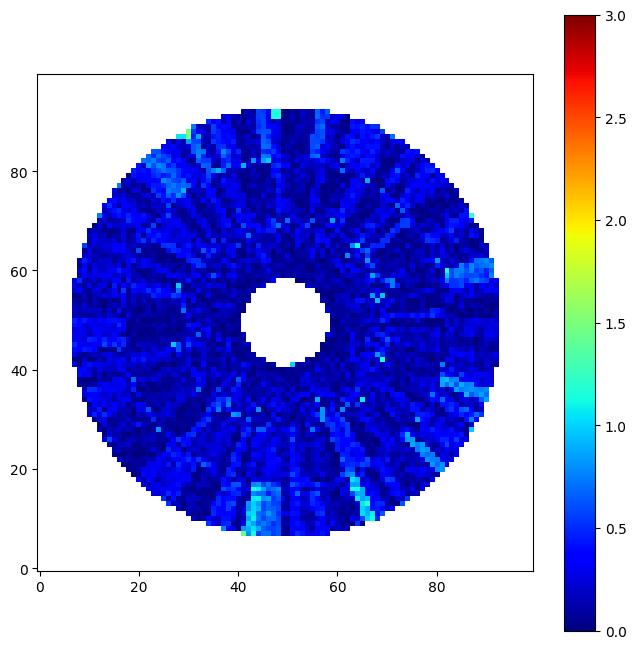

 >> Example 3
 >> Original image:


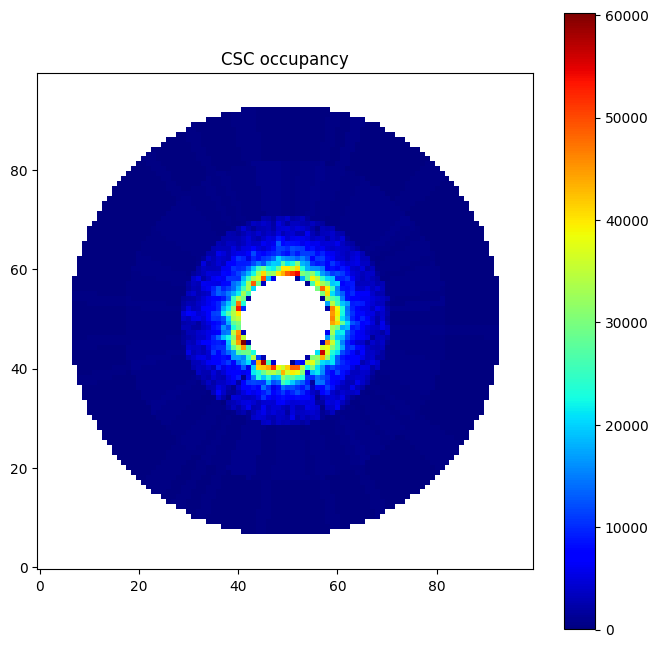

 >> AE-reco image:


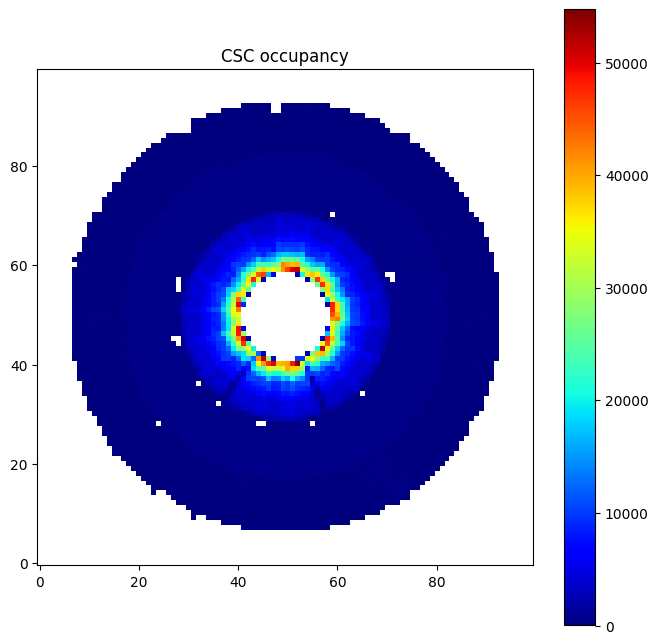

 >> Normalized loss map:


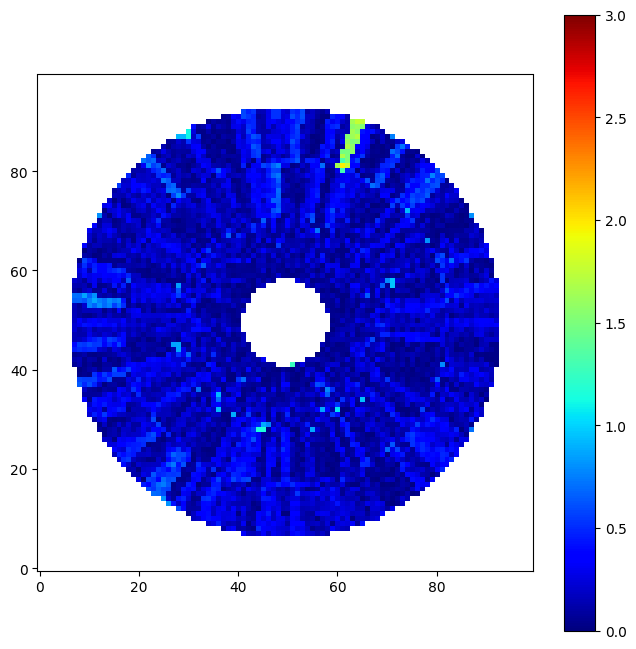

***** batch 3 *****
 >> Example 0
 >> Original image:


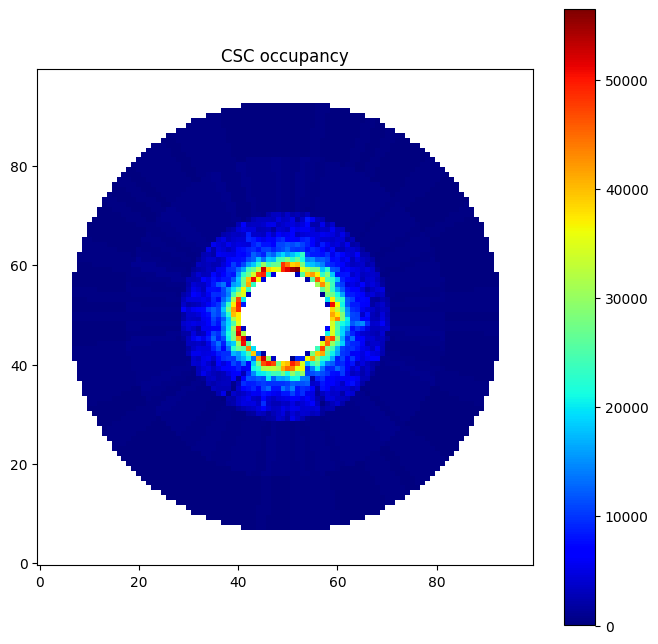

 >> AE-reco image:


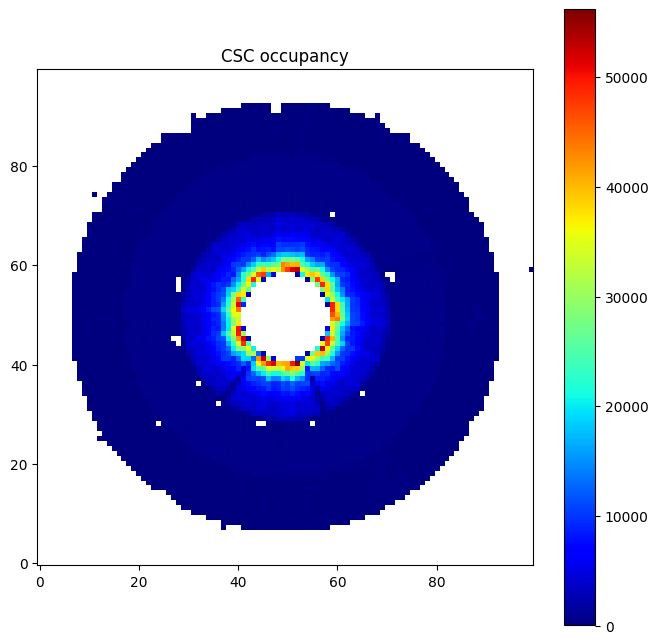

 >> Normalized loss map:


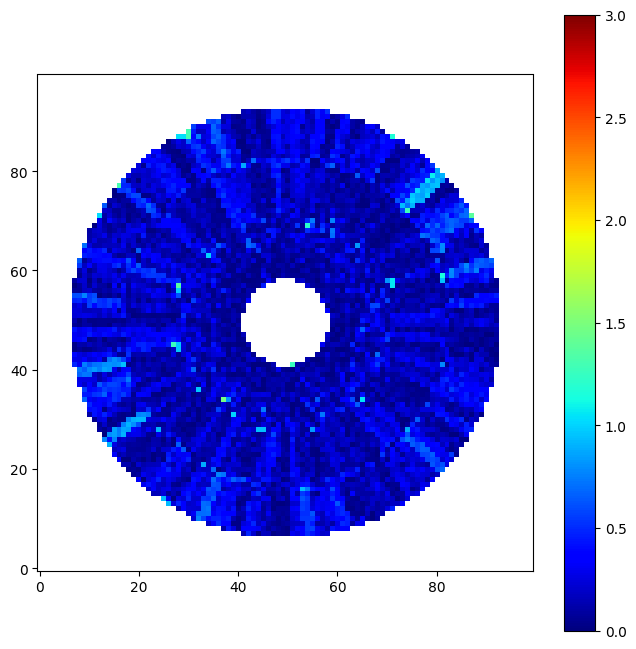

 >> Example 1
 >> Original image:


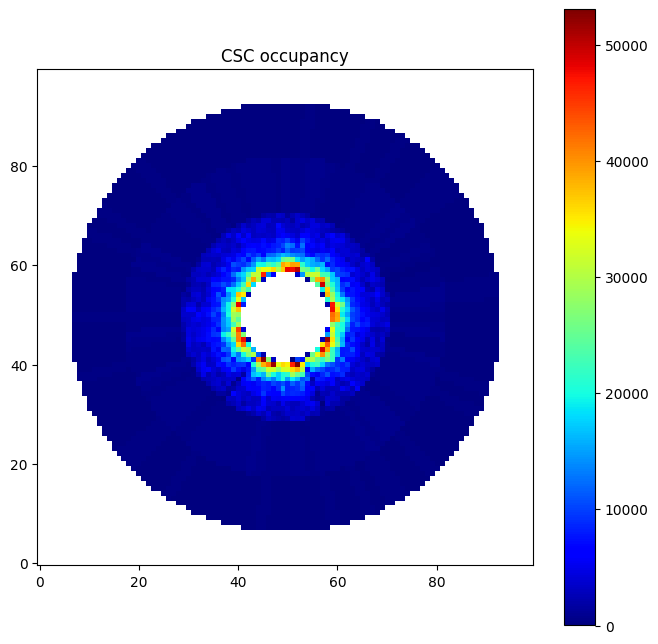

 >> AE-reco image:


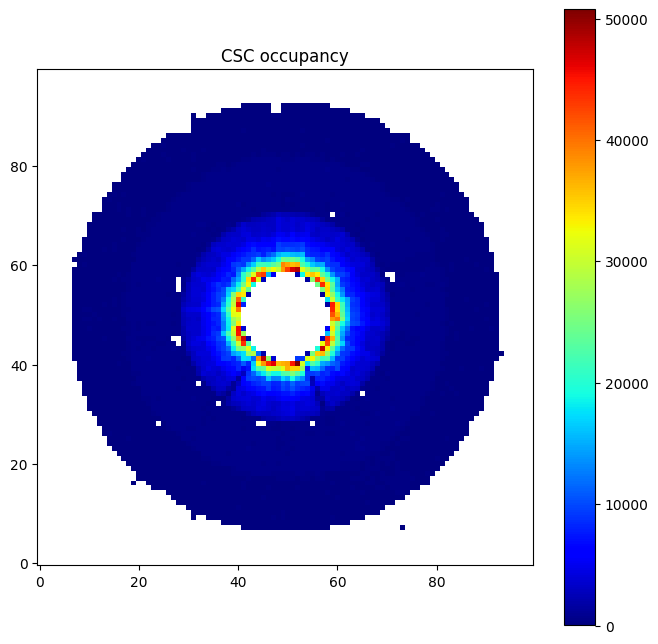

 >> Normalized loss map:


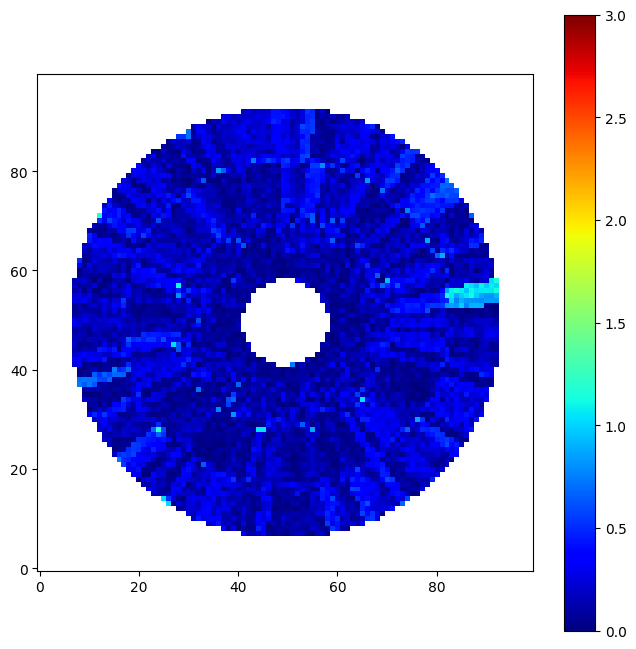

 >> Example 2
 >> Original image:


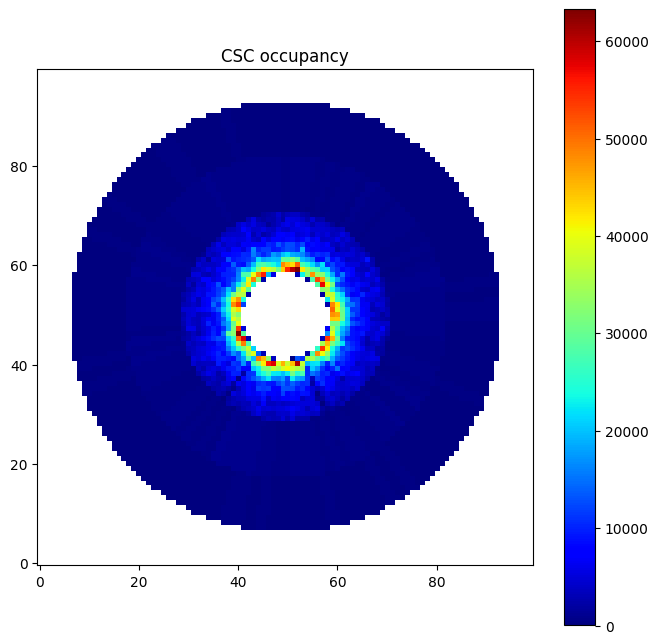

 >> AE-reco image:


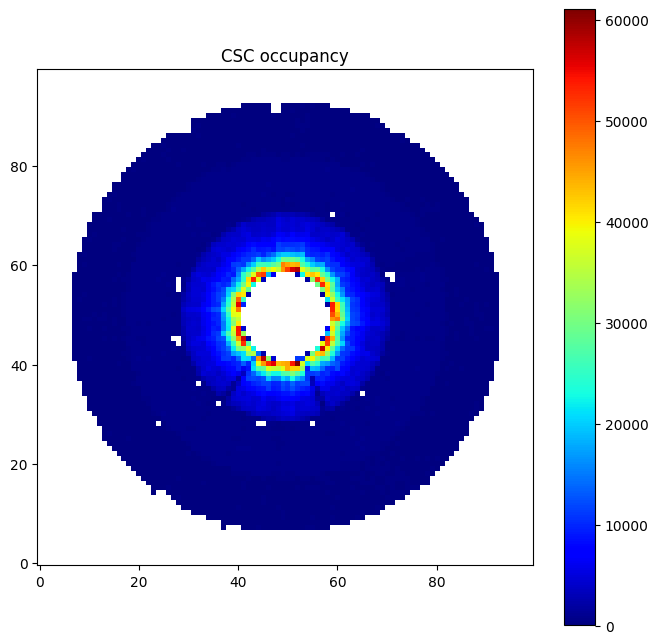

 >> Normalized loss map:


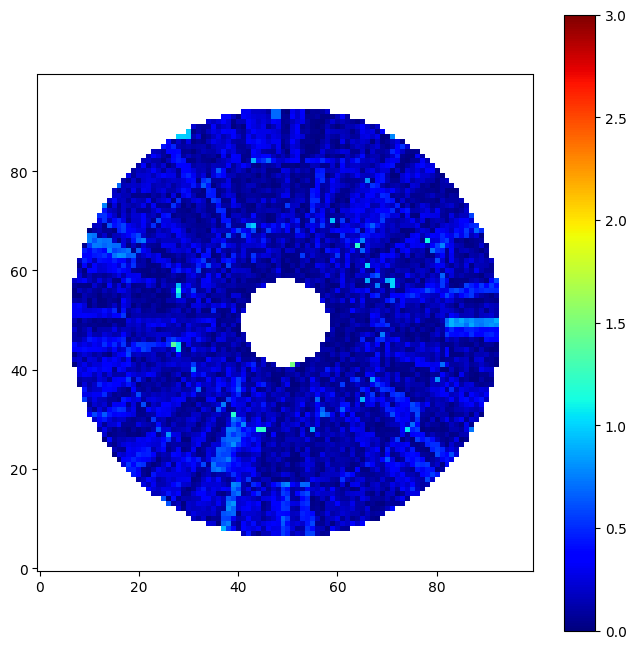

 >> Example 3
 >> Original image:


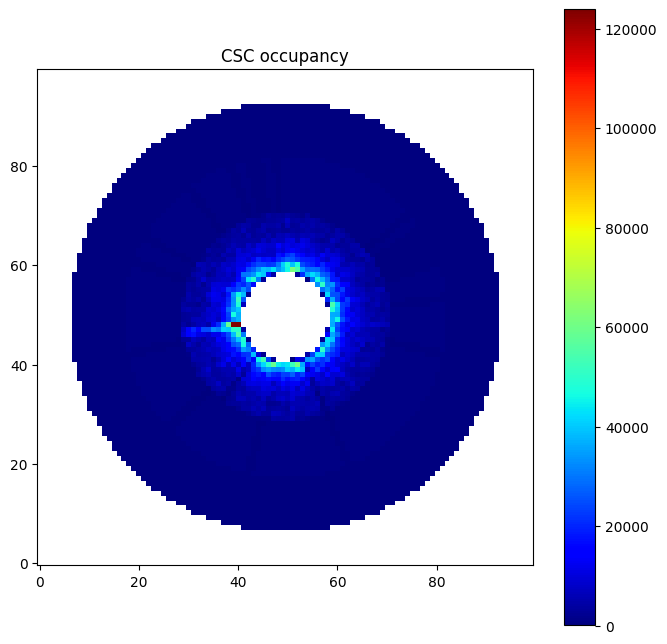

 >> AE-reco image:


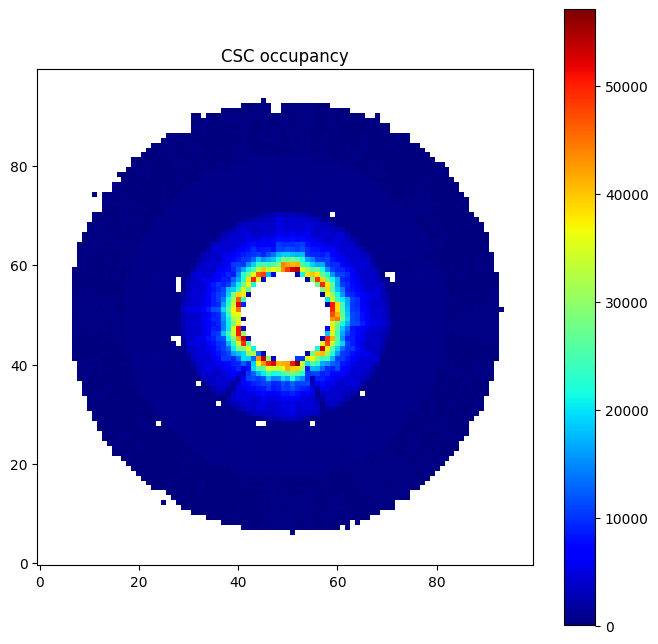

 >> Normalized loss map:


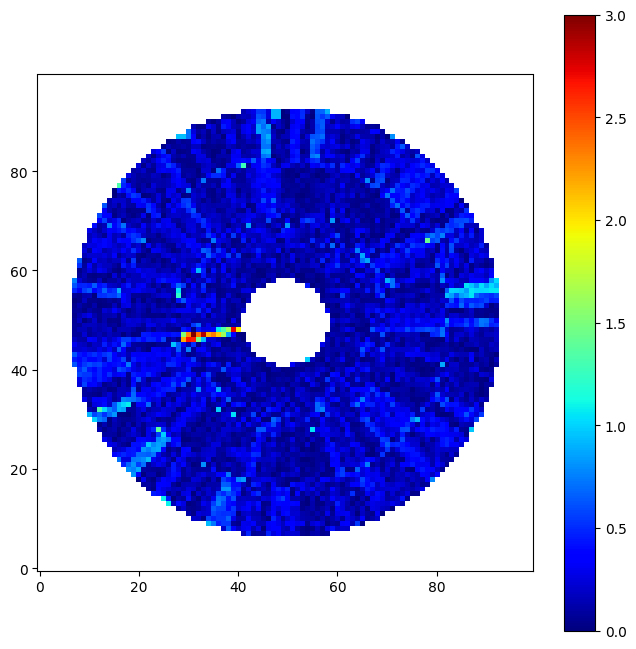

***** batch 4 *****
 >> Example 0
 >> Original image:


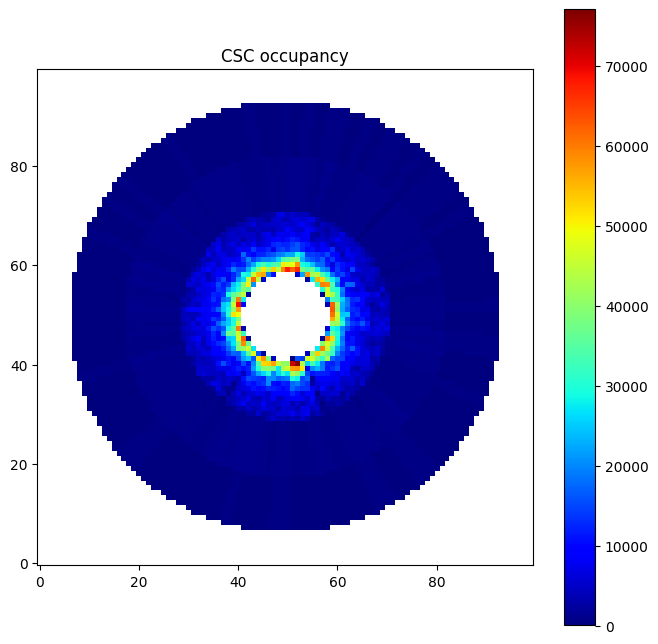

 >> AE-reco image:


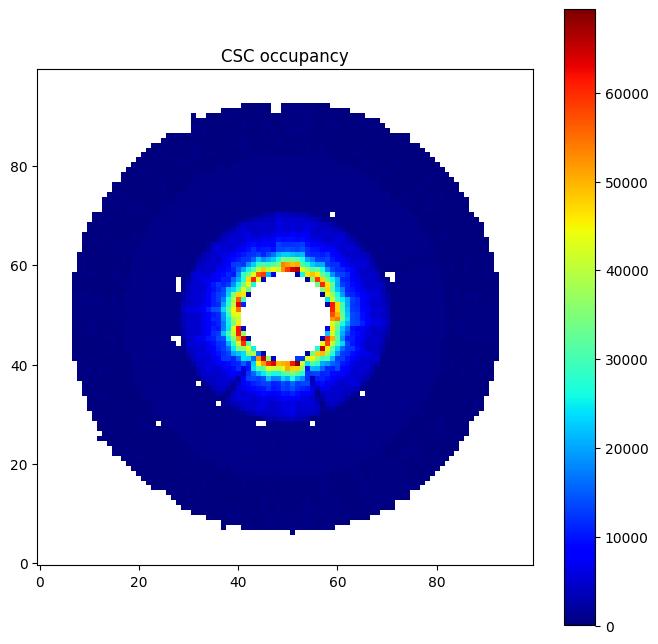

 >> Normalized loss map:


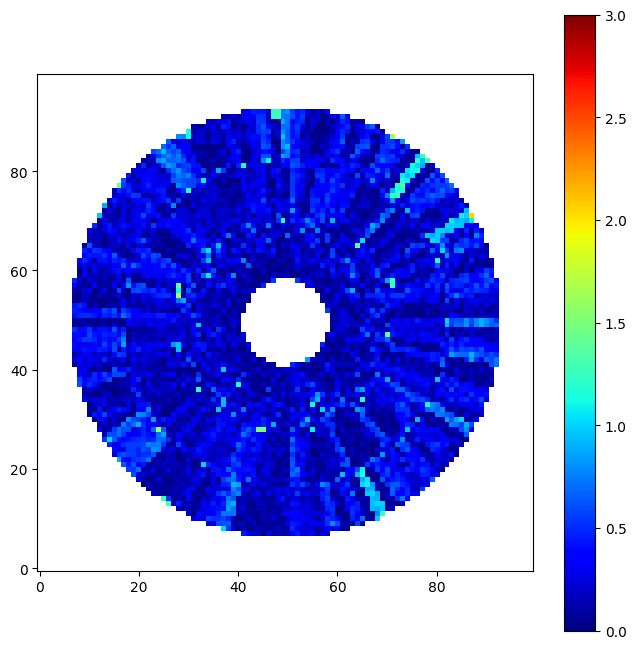

 >> Example 1
 >> Original image:


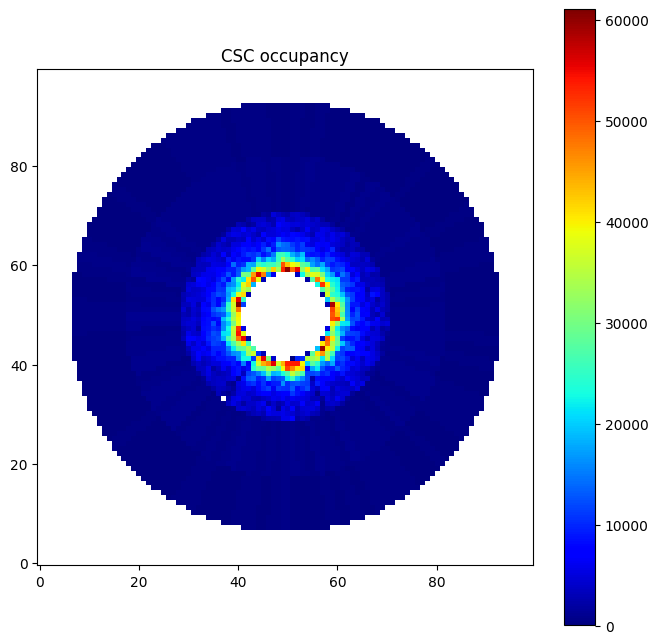

 >> AE-reco image:


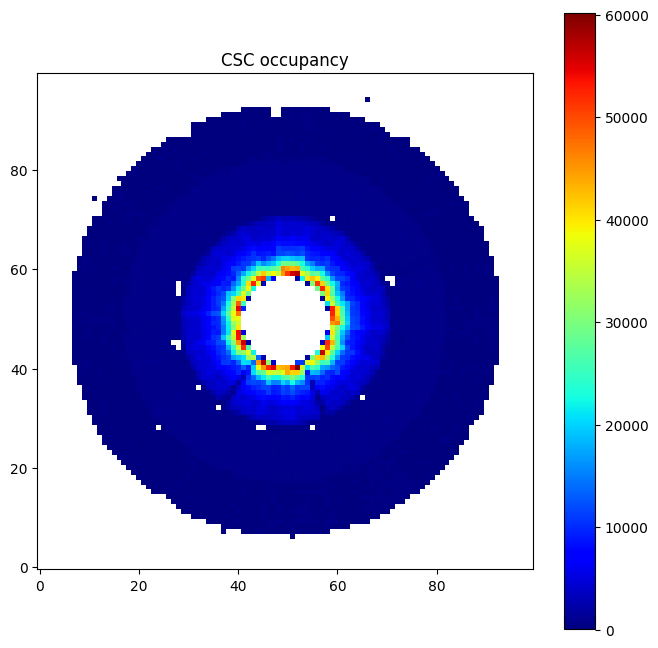

 >> Normalized loss map:


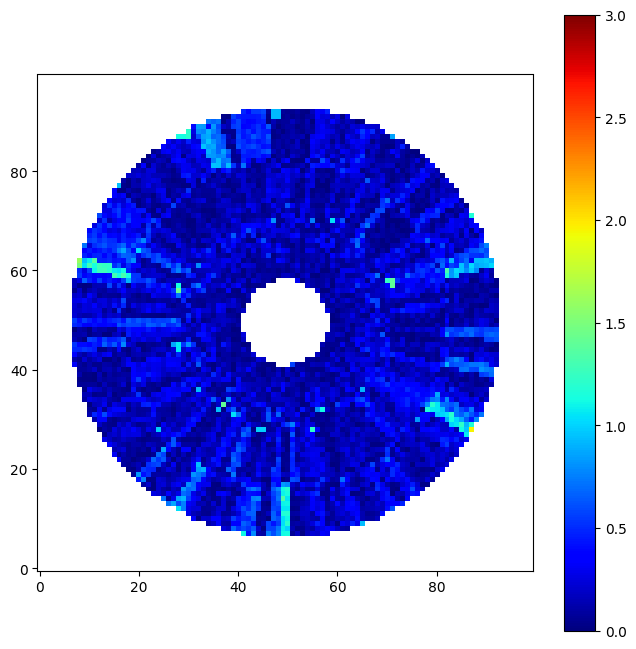

 >> Example 2
 >> Original image:


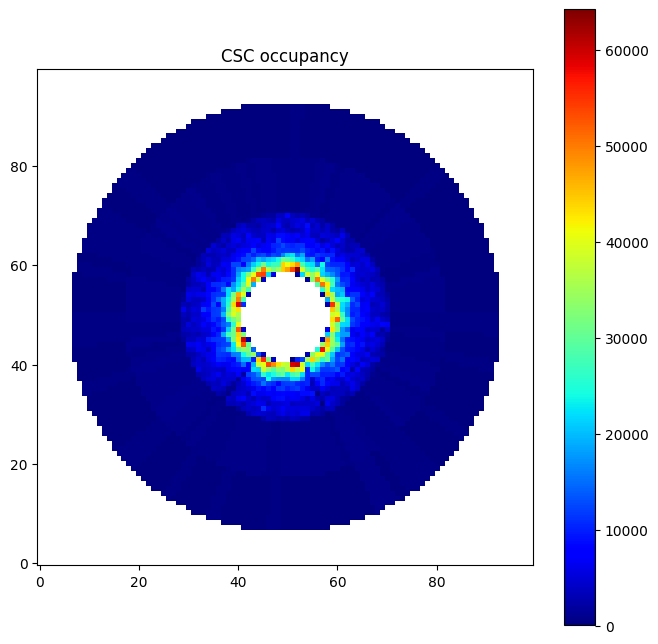

 >> AE-reco image:


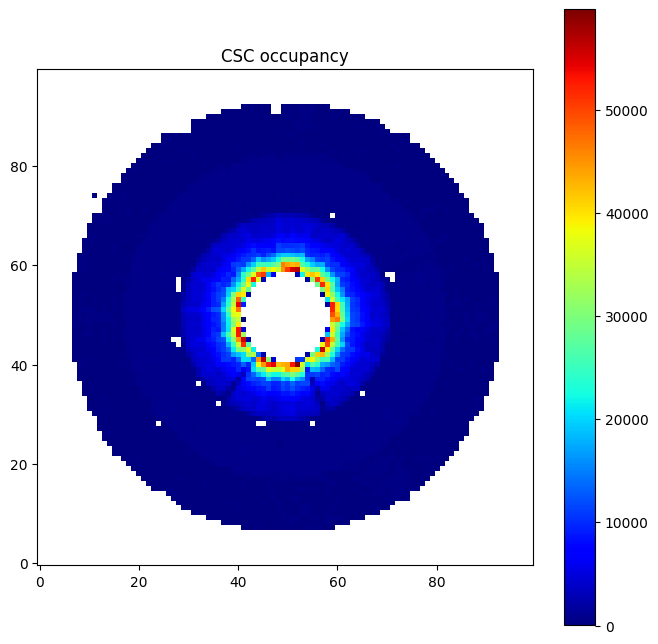

 >> Normalized loss map:


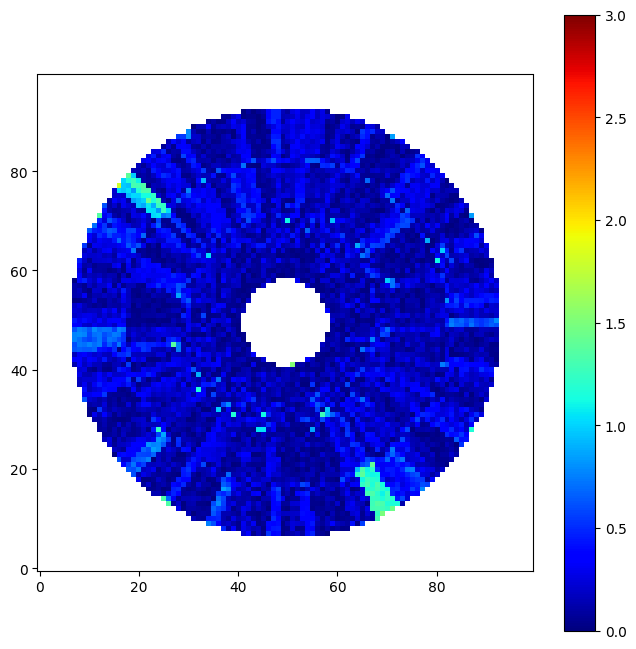

 >> Example 3
 >> Original image:


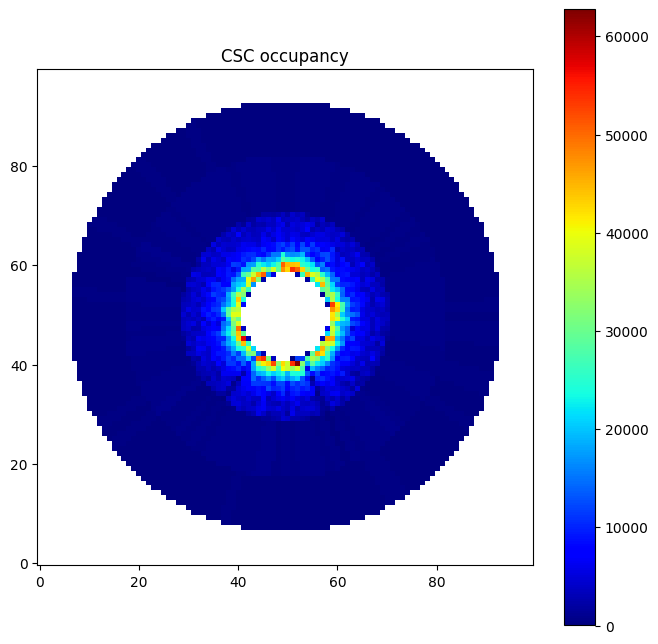

 >> AE-reco image:


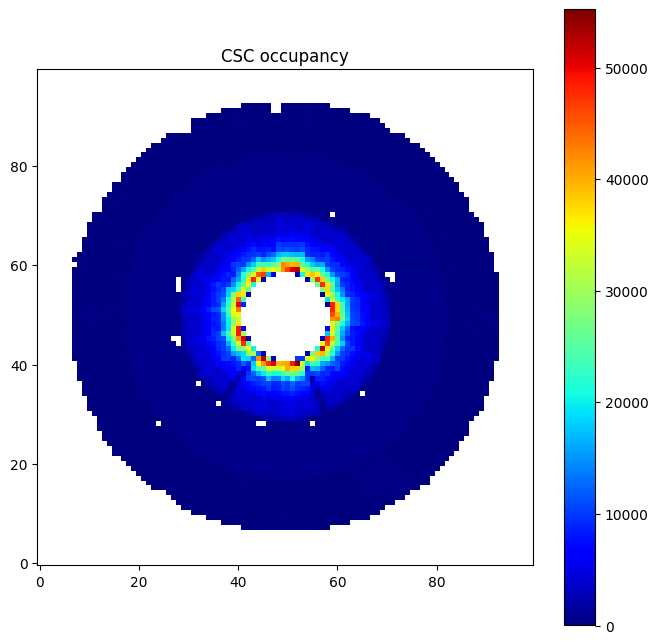

 >> Normalized loss map:


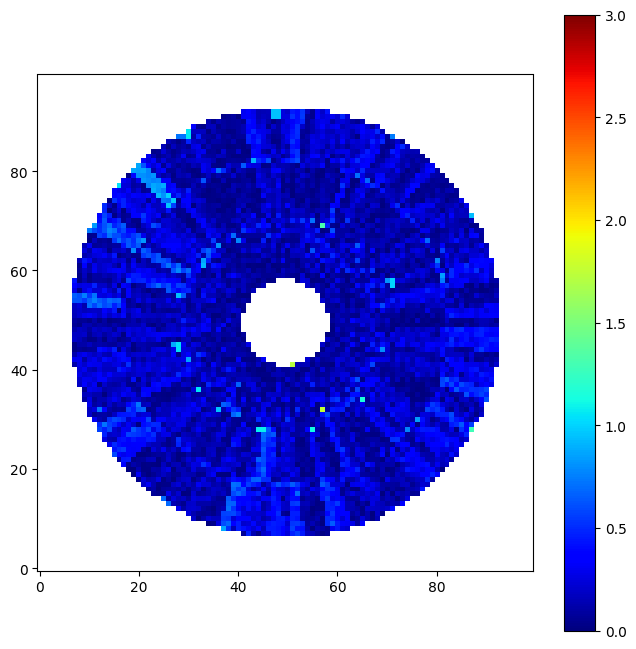

***** batch 5 *****
 >> Example 0
 >> Original image:


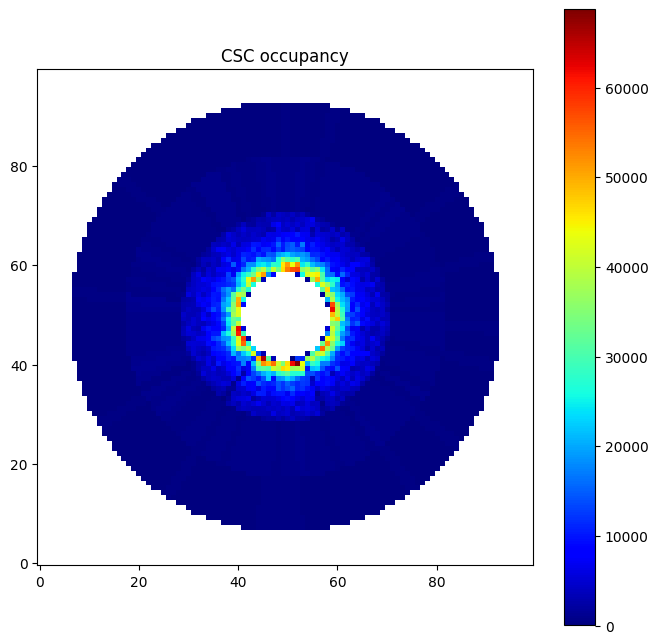

 >> AE-reco image:


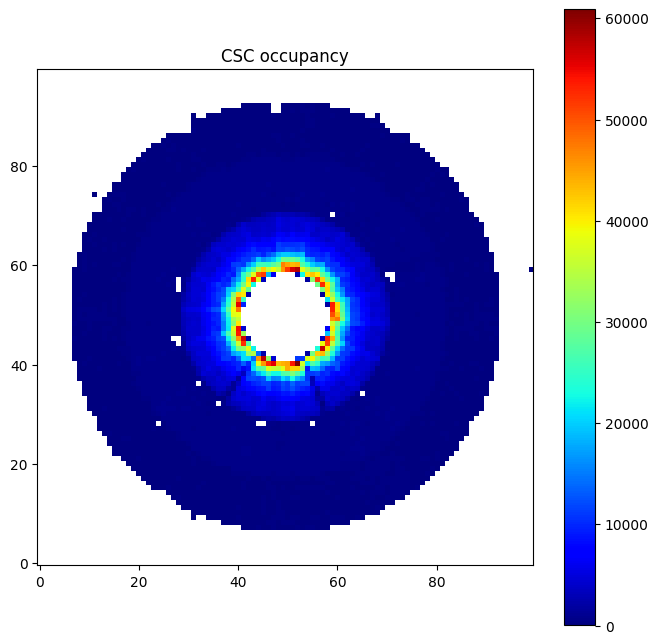

 >> Normalized loss map:


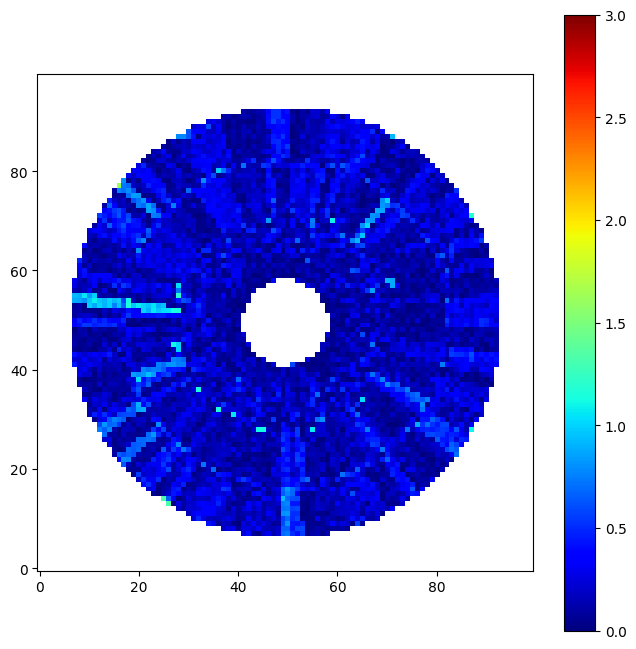

 >> Example 1
 >> Original image:


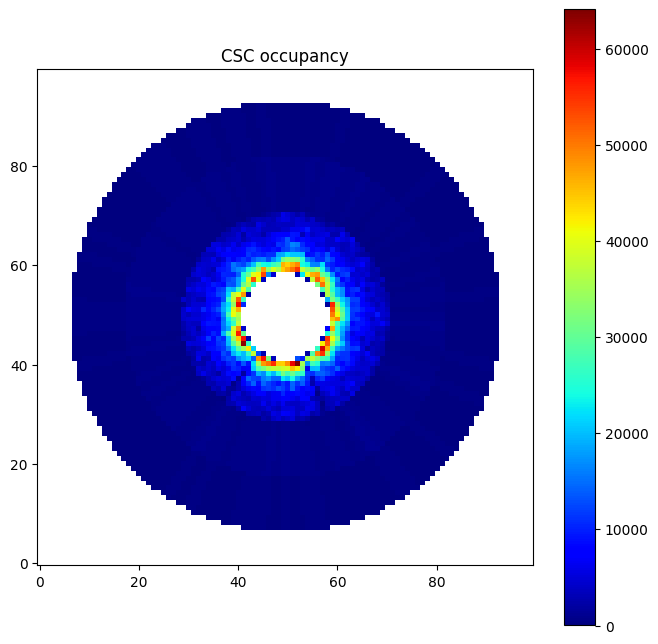

 >> AE-reco image:


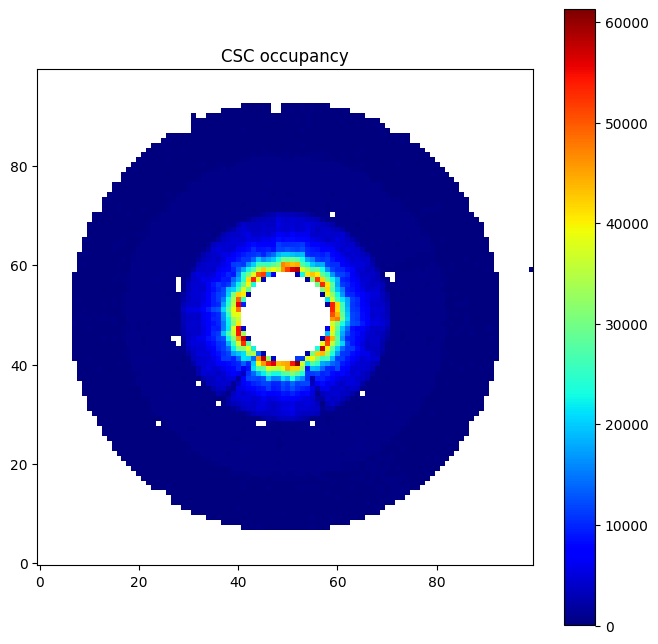

 >> Normalized loss map:


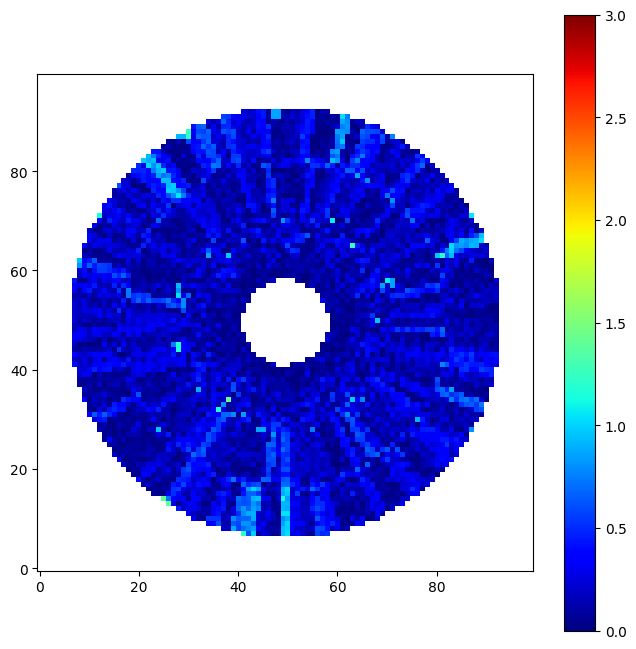

 >> Example 2
 >> Original image:


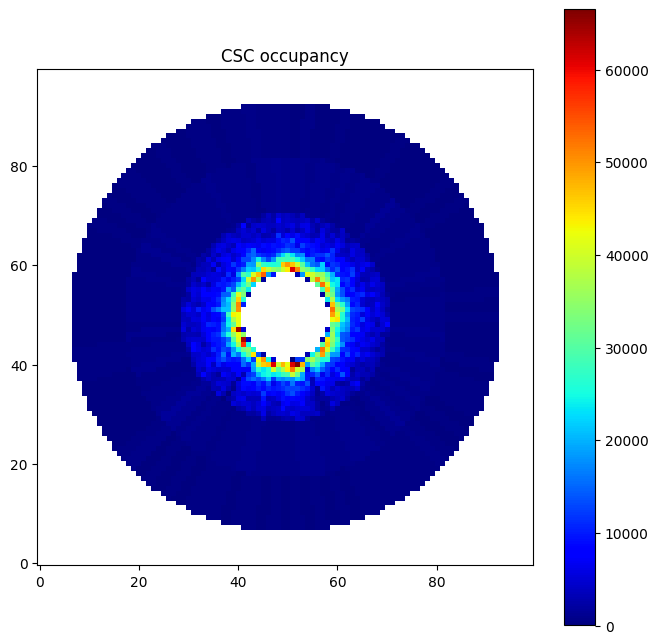

 >> AE-reco image:


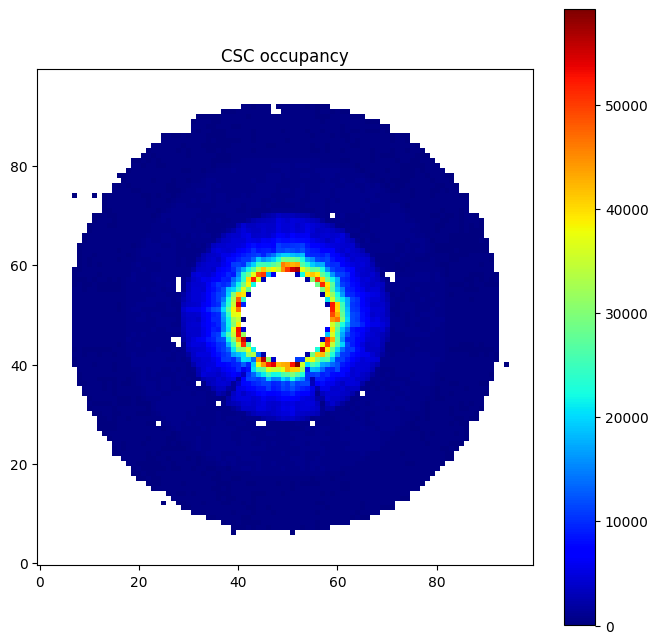

 >> Normalized loss map:


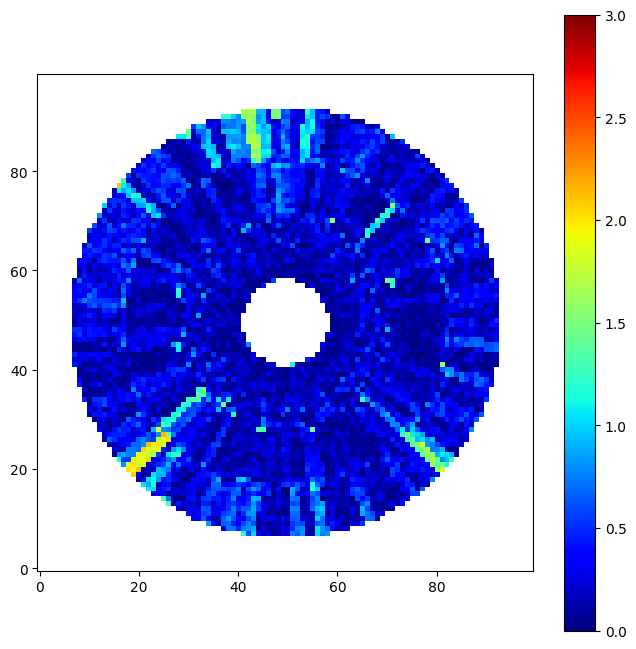

 >> Example 3
 >> Original image:


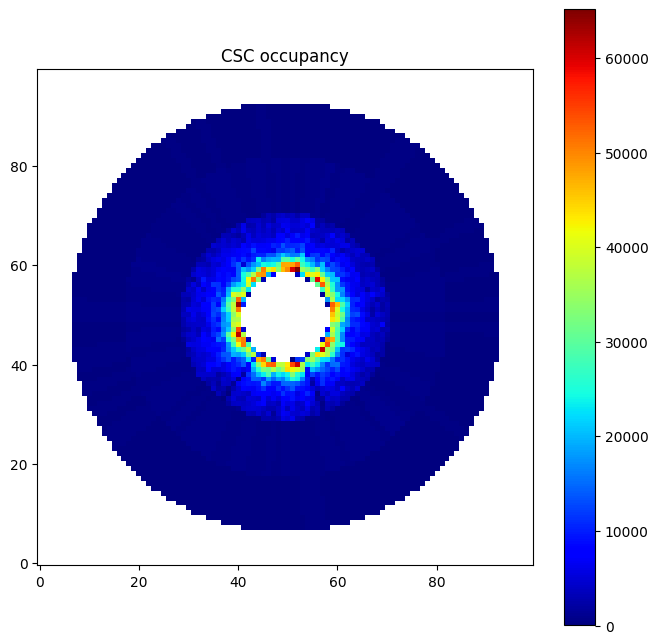

 >> AE-reco image:


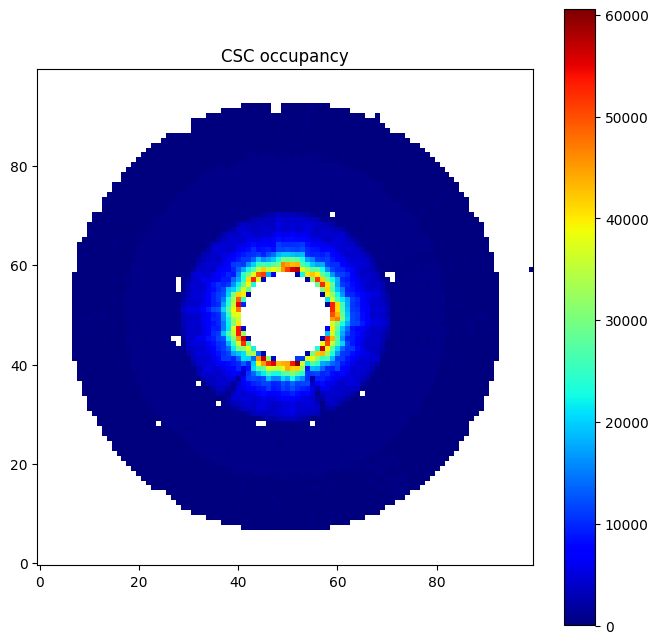

 >> Normalized loss map:


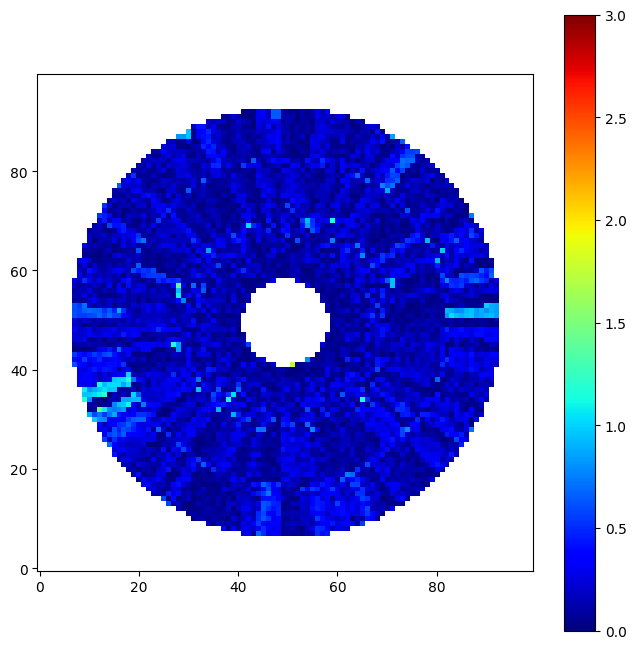

***** batch 6 *****
 >> Example 0
 >> Original image:


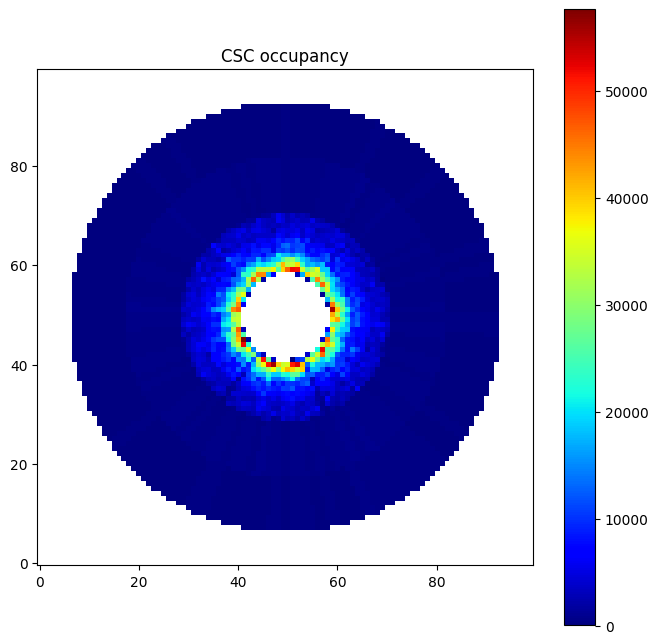

 >> AE-reco image:


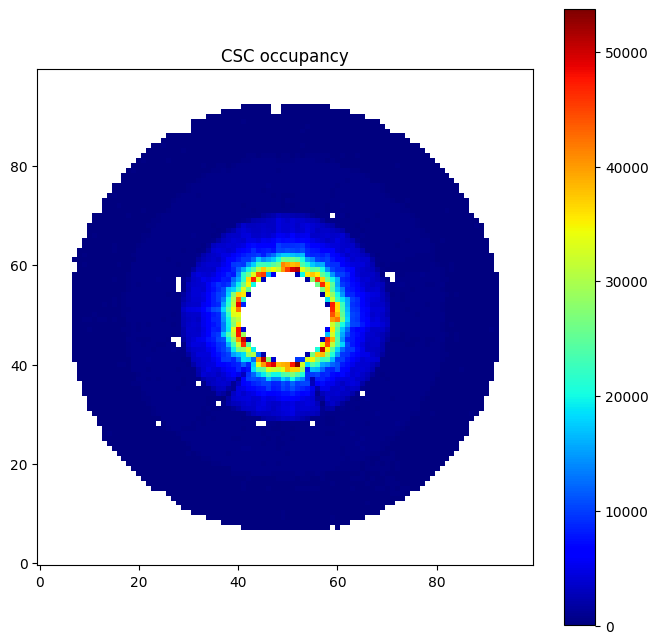

 >> Normalized loss map:


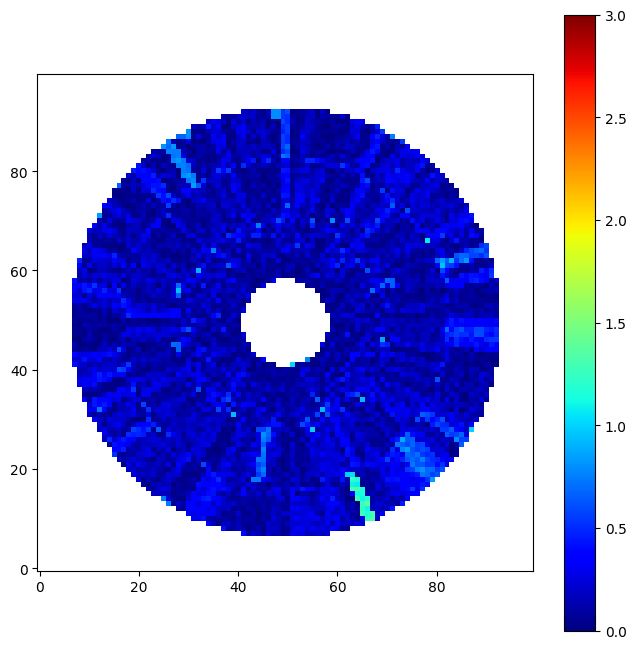

 >> Example 1
 >> Original image:


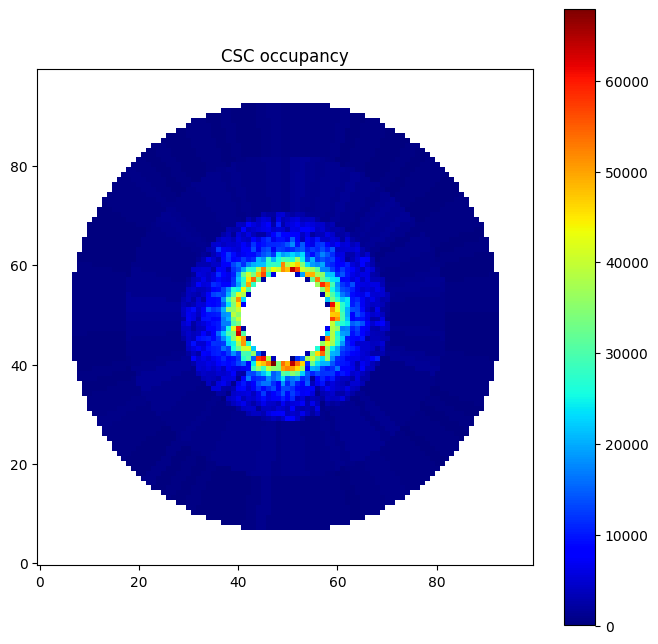

 >> AE-reco image:


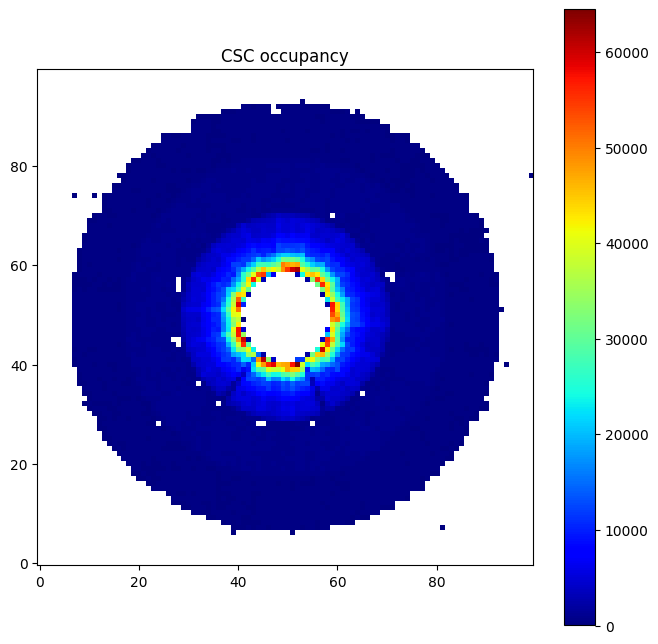

 >> Normalized loss map:


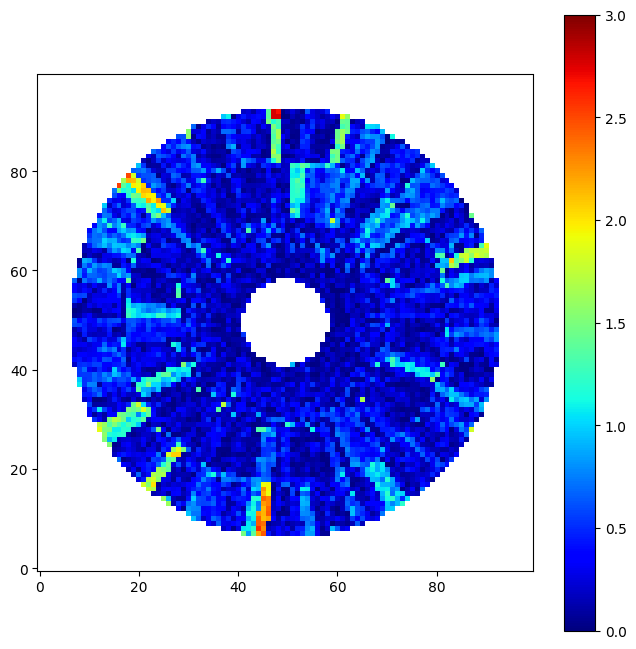

 >> Example 2
 >> Original image:


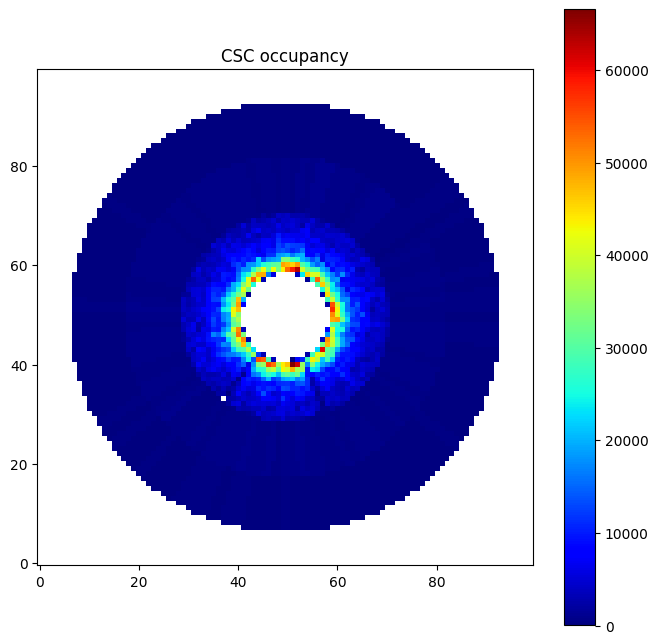

 >> AE-reco image:


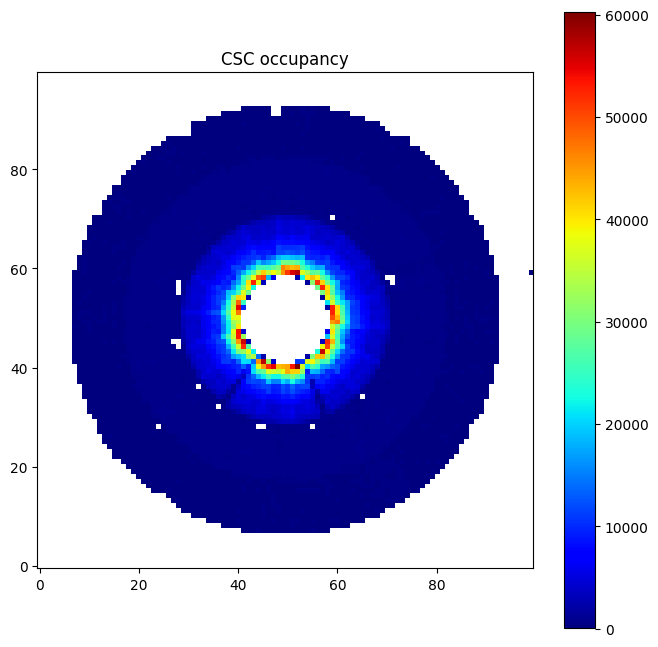

 >> Normalized loss map:


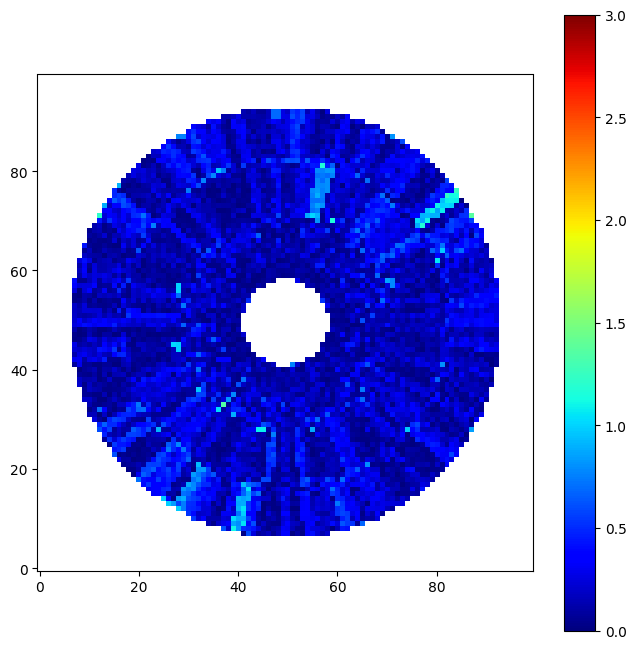

 >> Example 3
 >> Original image:


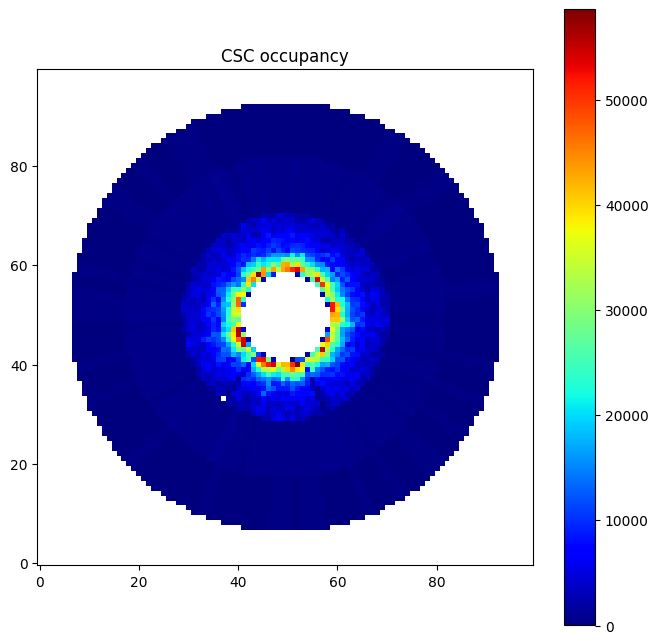

 >> AE-reco image:


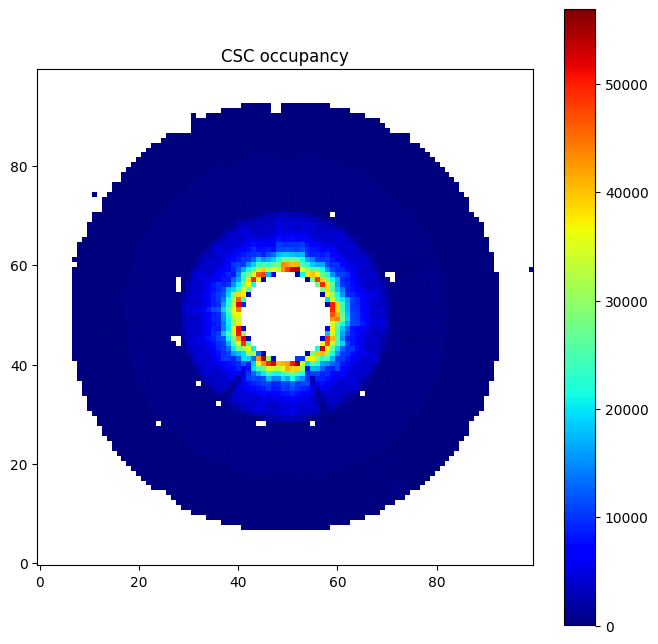

 >> Normalized loss map:


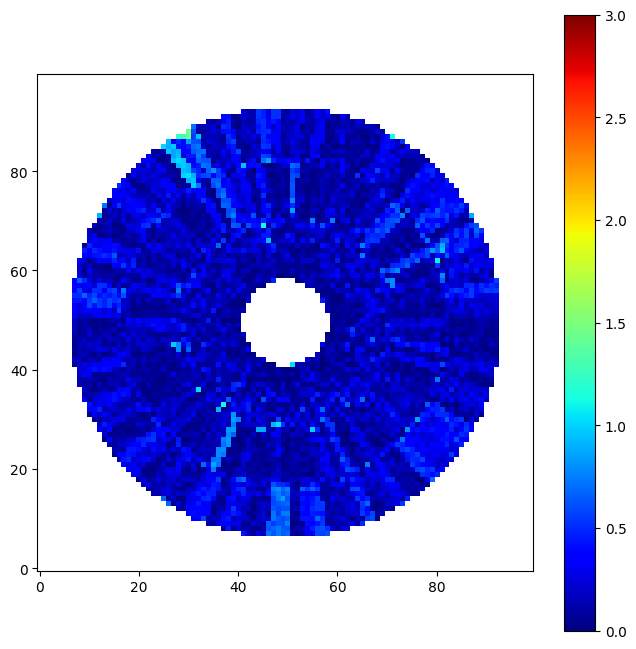

***** batch 7 *****
 >> Example 0
 >> Original image:


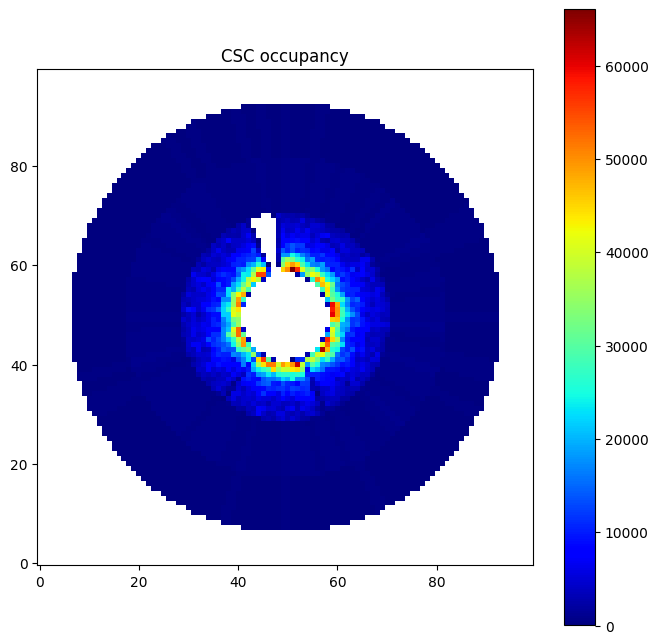

 >> AE-reco image:


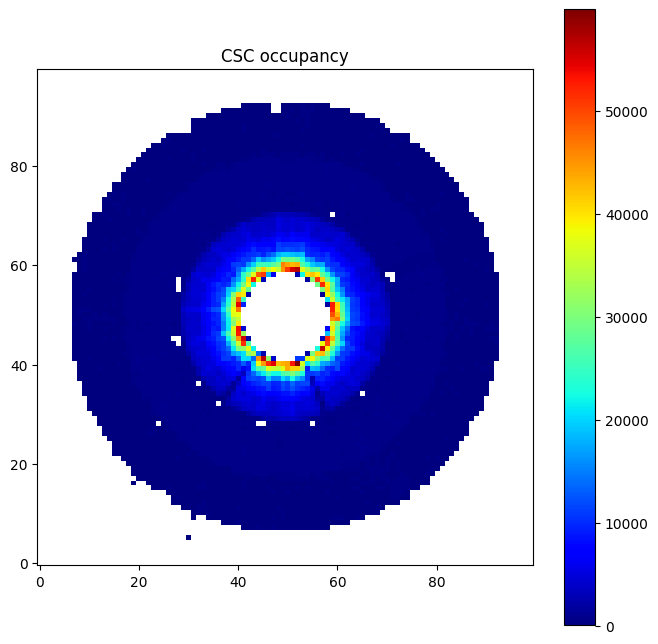

 >> Normalized loss map:


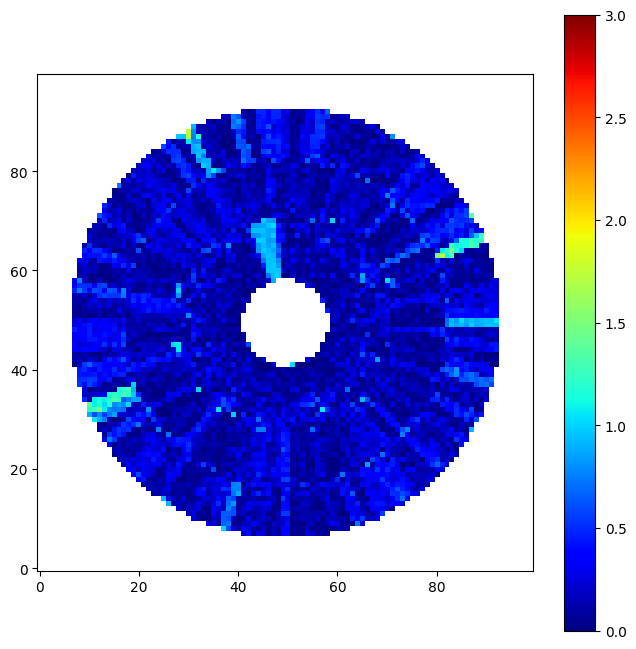

 >> Example 1
 >> Original image:


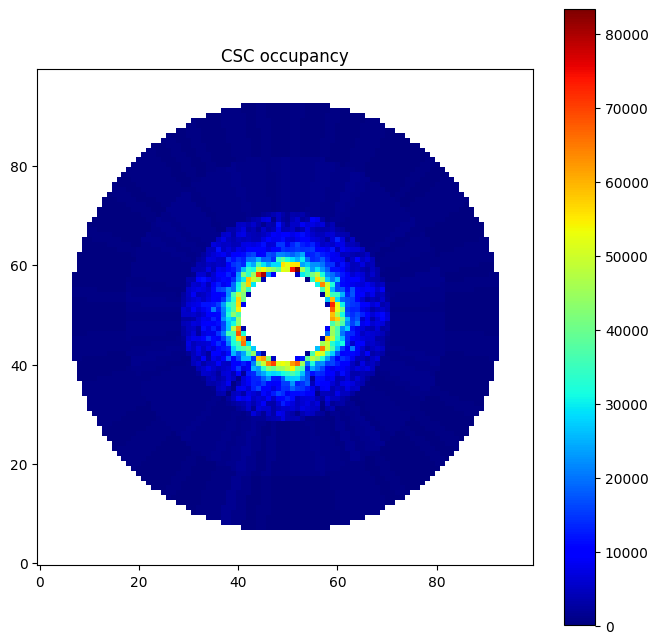

 >> AE-reco image:


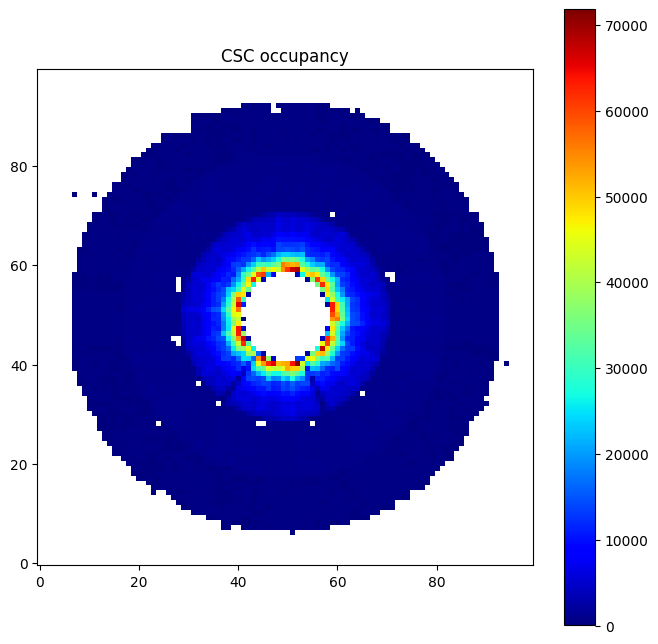

 >> Normalized loss map:


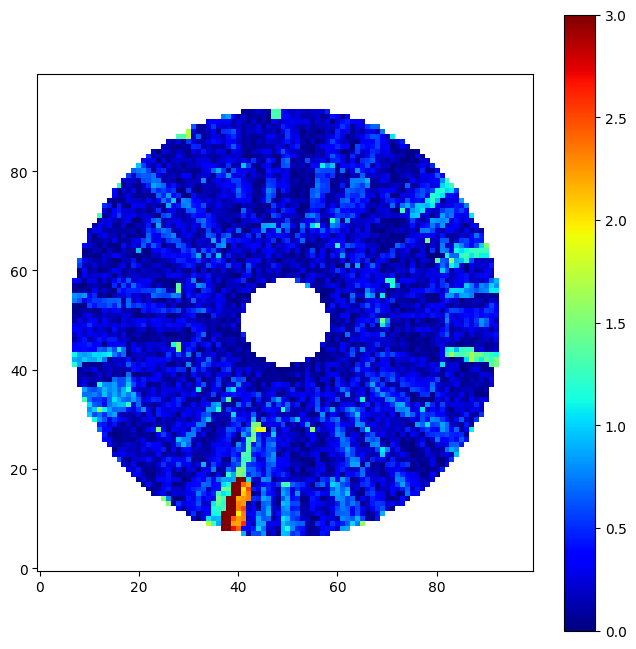

 >> Example 2
 >> Original image:


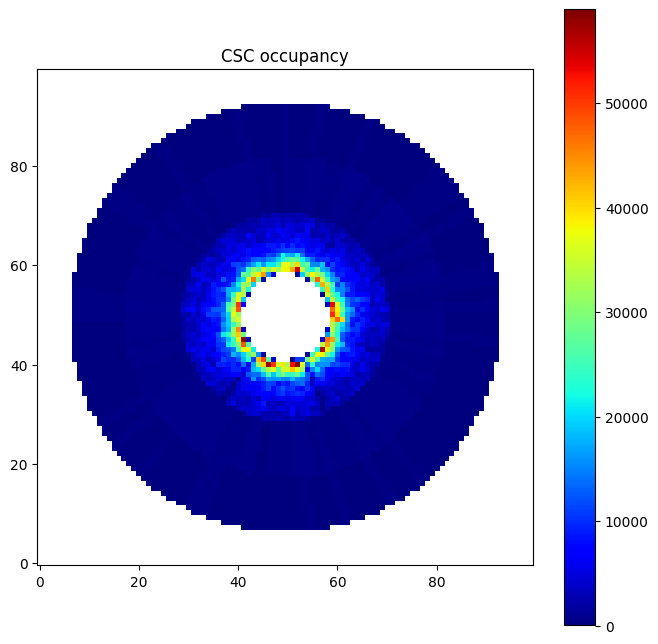

 >> AE-reco image:


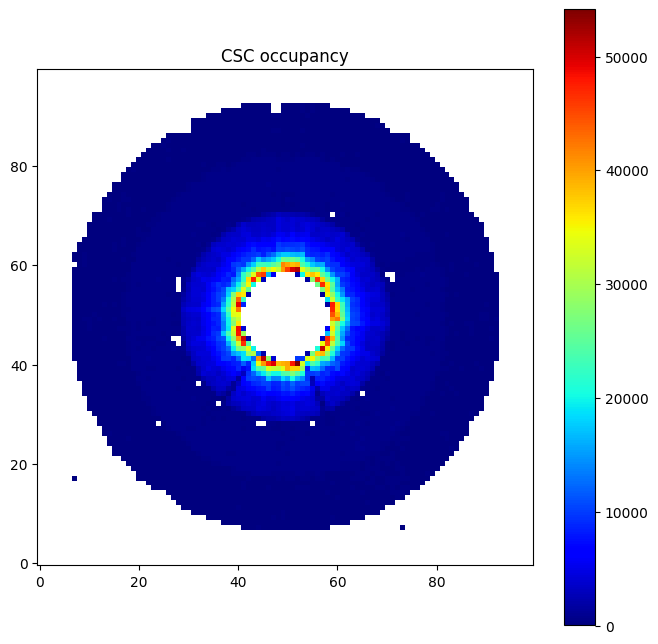

 >> Normalized loss map:


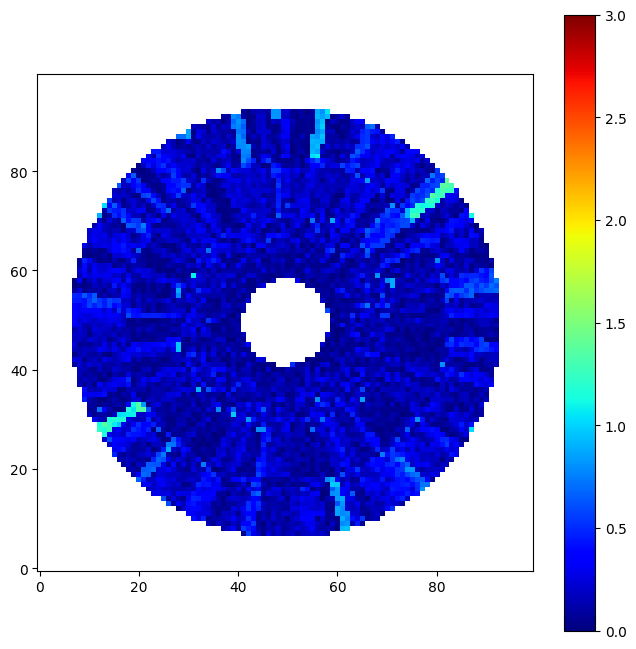

 >> Example 3
 >> Original image:


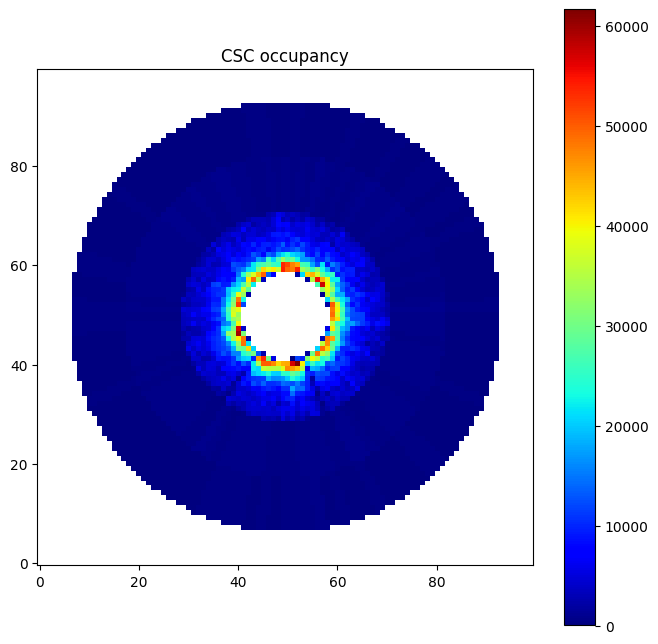

 >> AE-reco image:


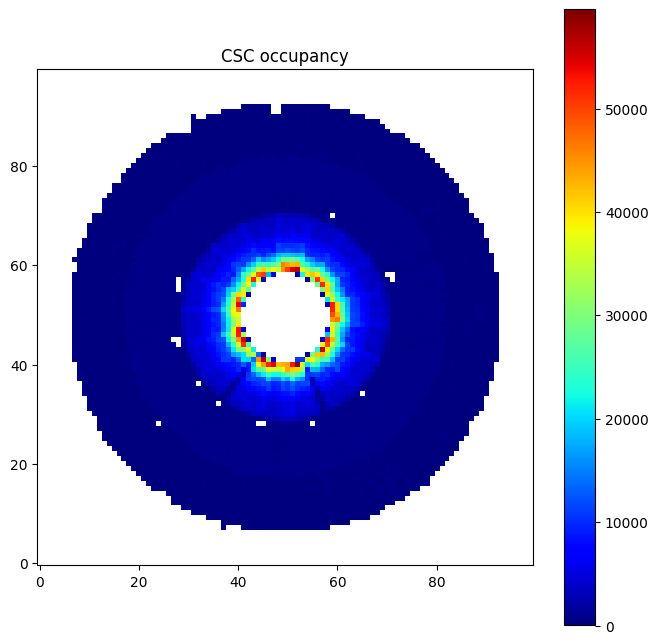

 >> Normalized loss map:


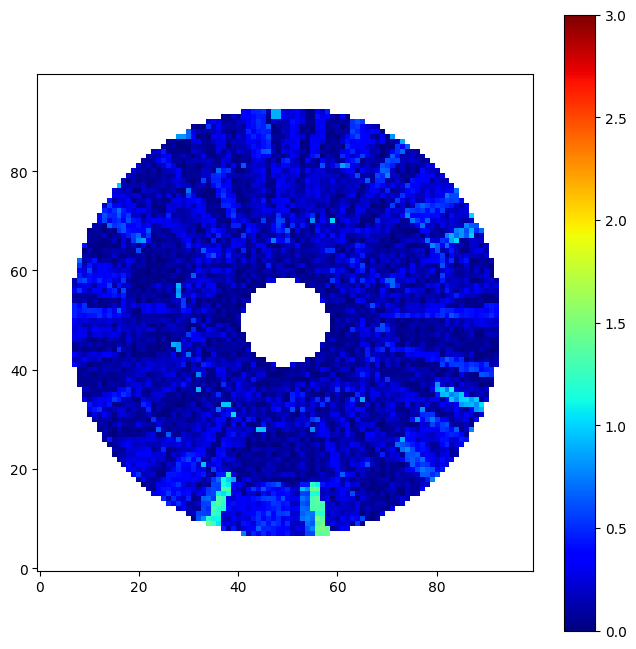

***** batch 8 *****
 >> Example 0
 >> Original image:


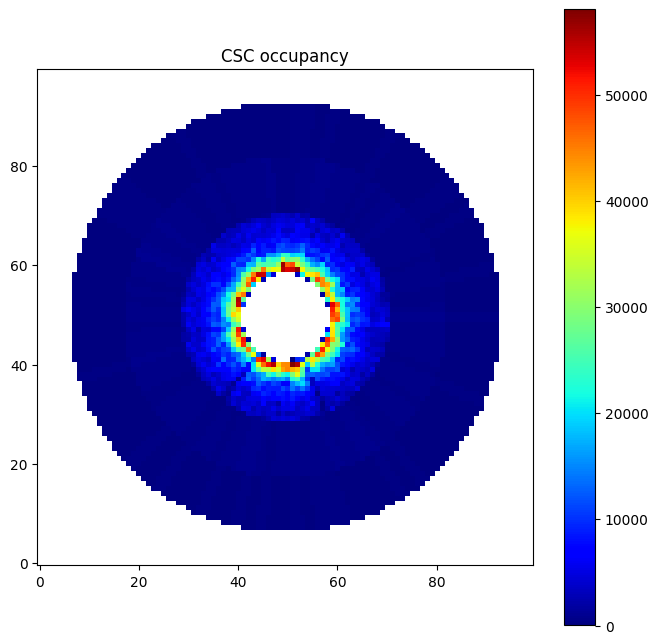

 >> AE-reco image:


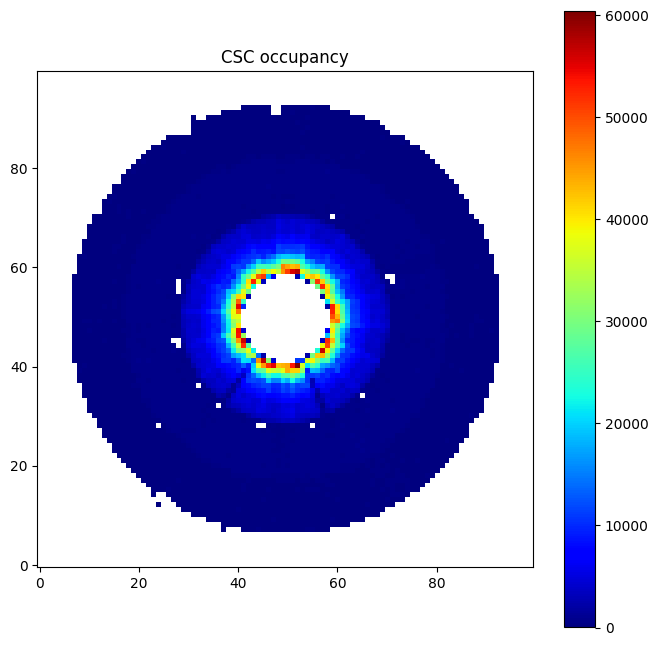

 >> Normalized loss map:


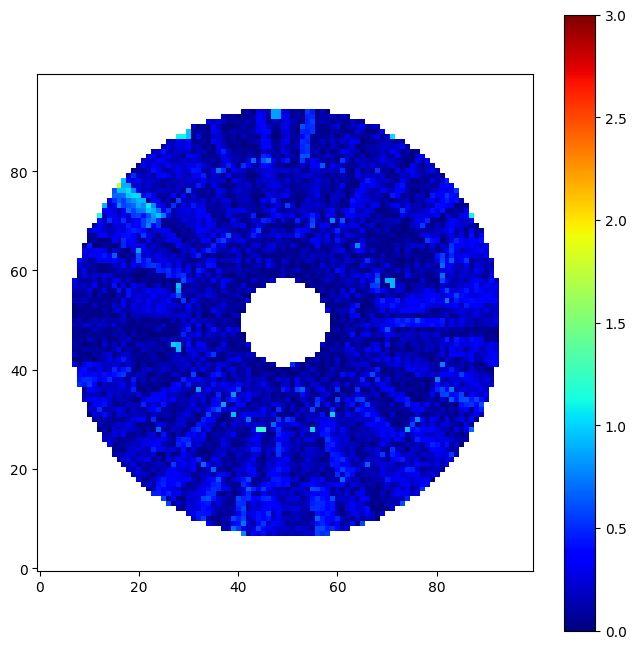

 >> Example 1
 >> Original image:


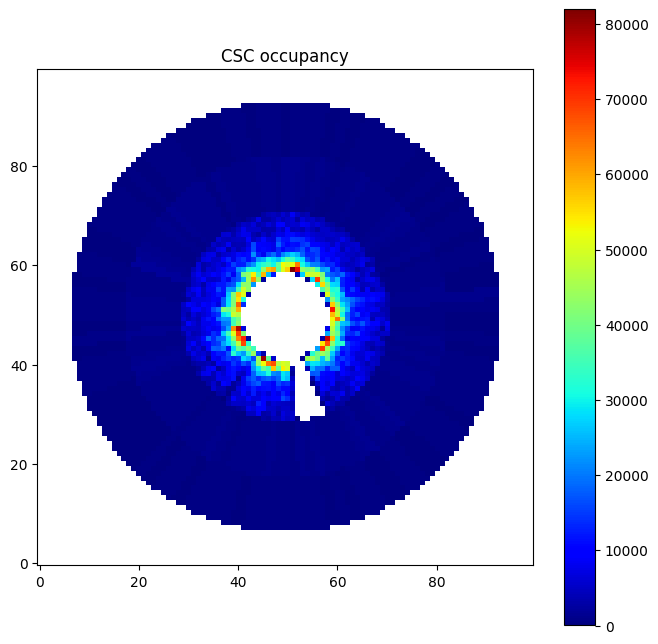

 >> AE-reco image:


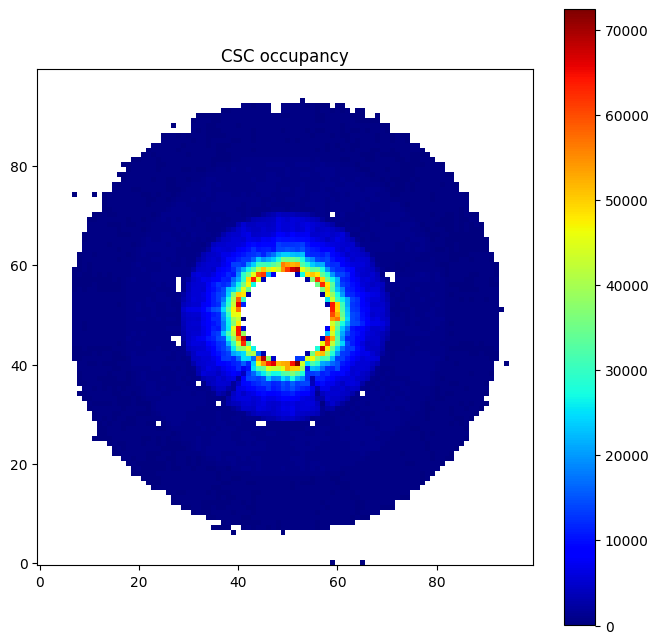

 >> Normalized loss map:


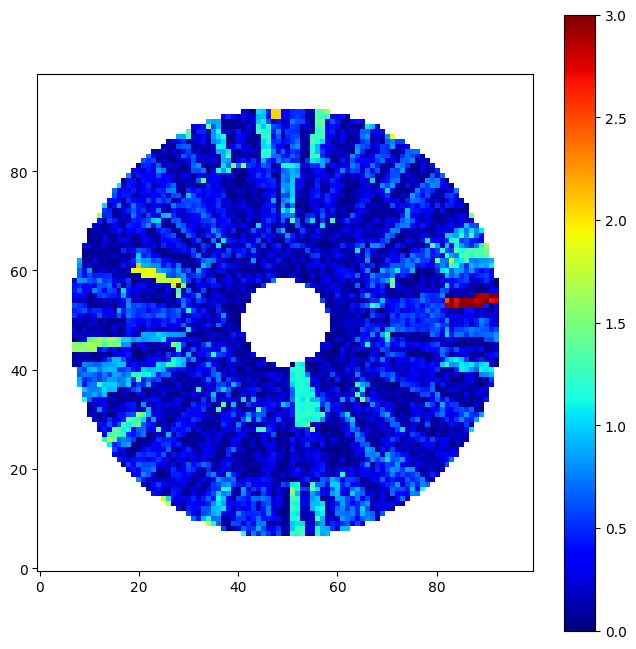

 >> Example 2
 >> Original image:


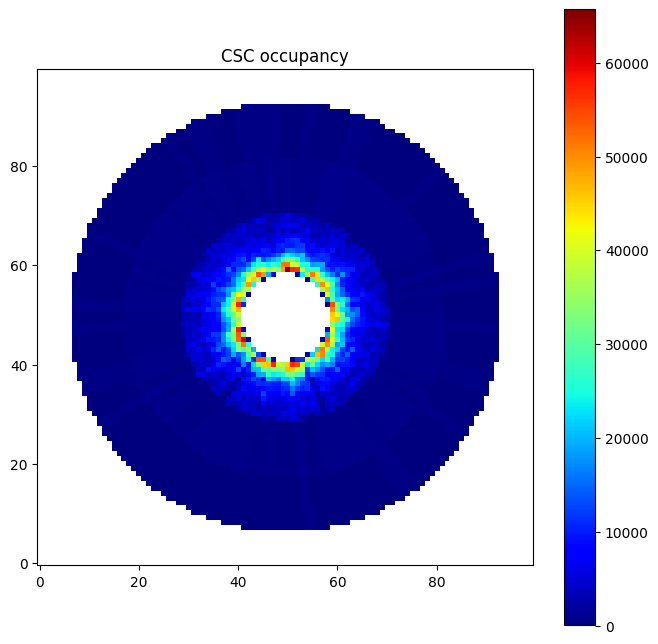

 >> AE-reco image:


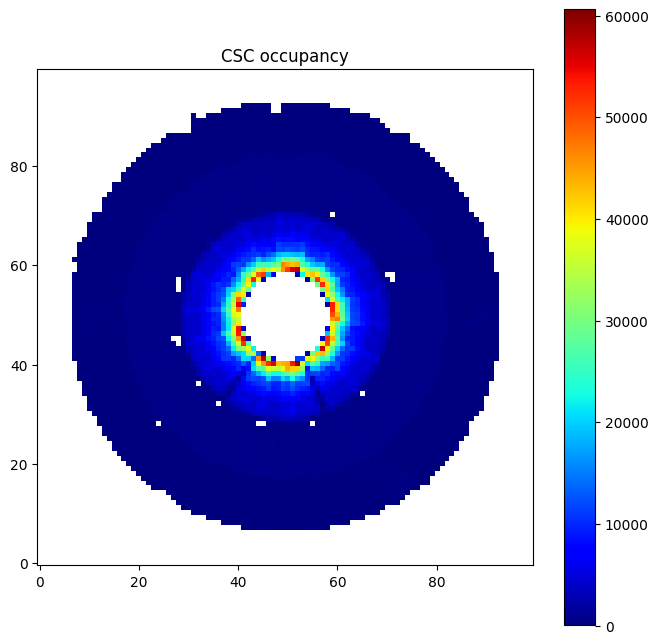

 >> Normalized loss map:


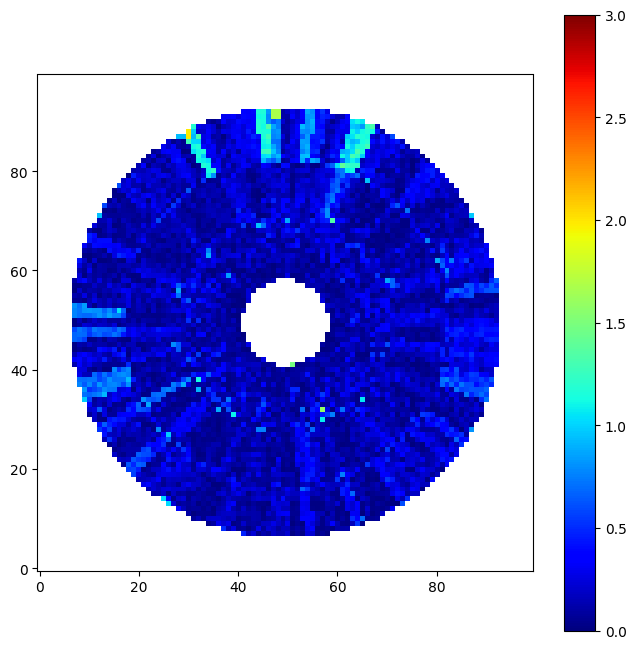

 >> Example 3
 >> Original image:


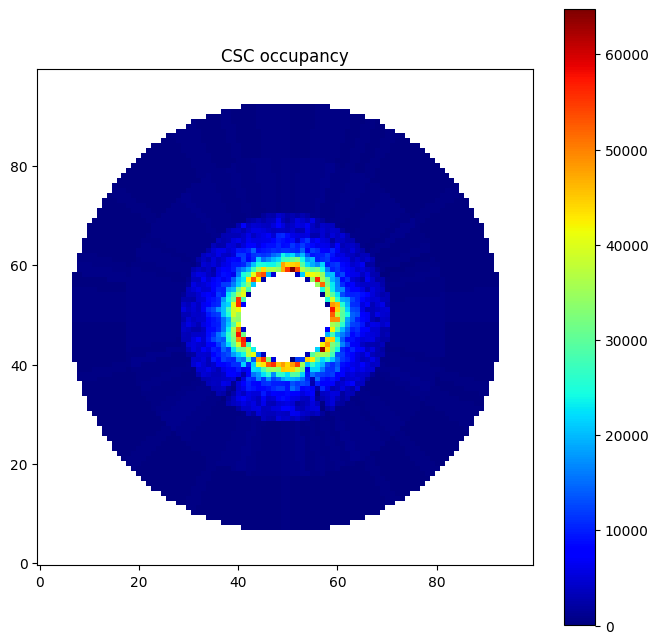

 >> AE-reco image:


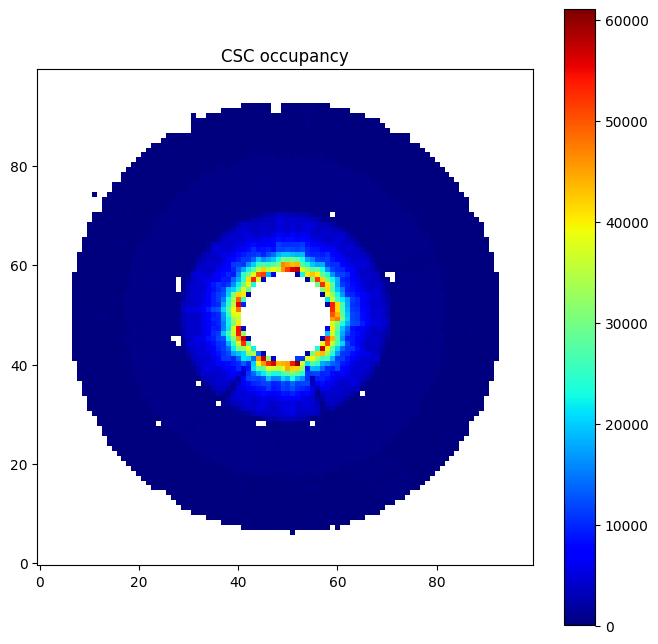

 >> Normalized loss map:


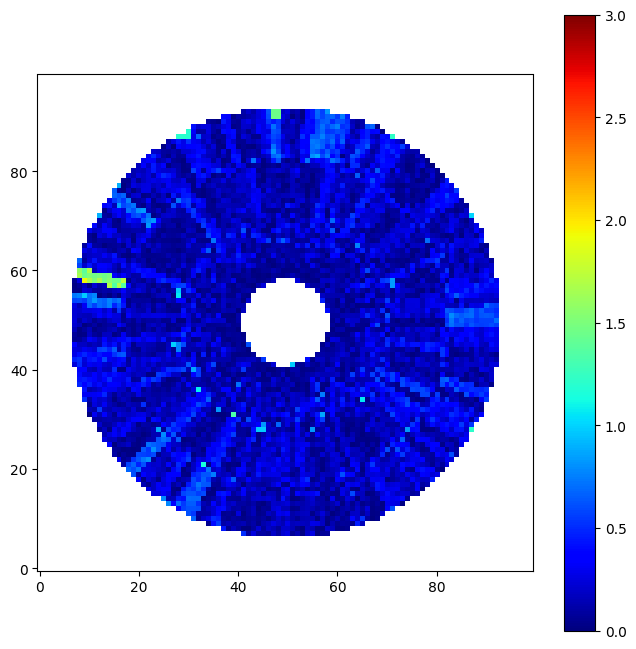

***** batch 9 *****
 >> Example 0
 >> Original image:


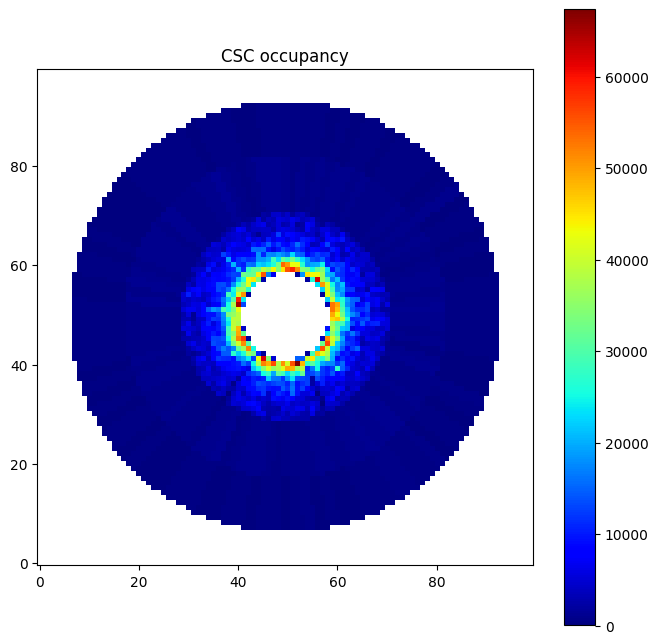

 >> AE-reco image:


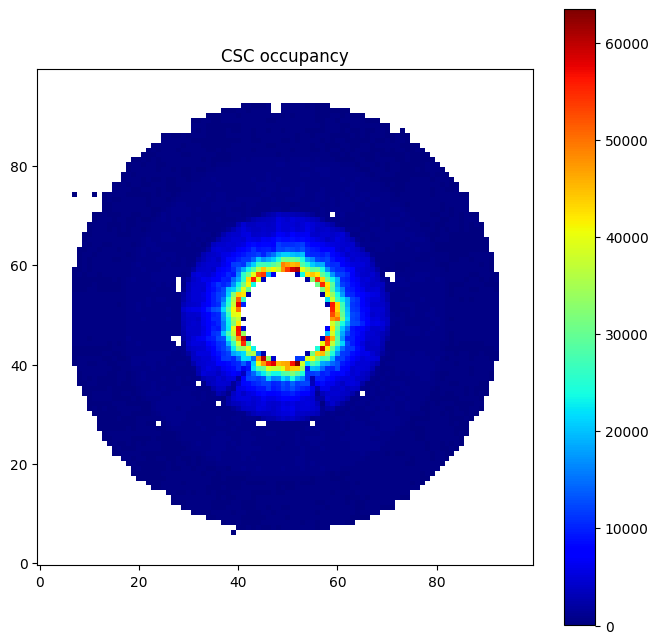

 >> Normalized loss map:


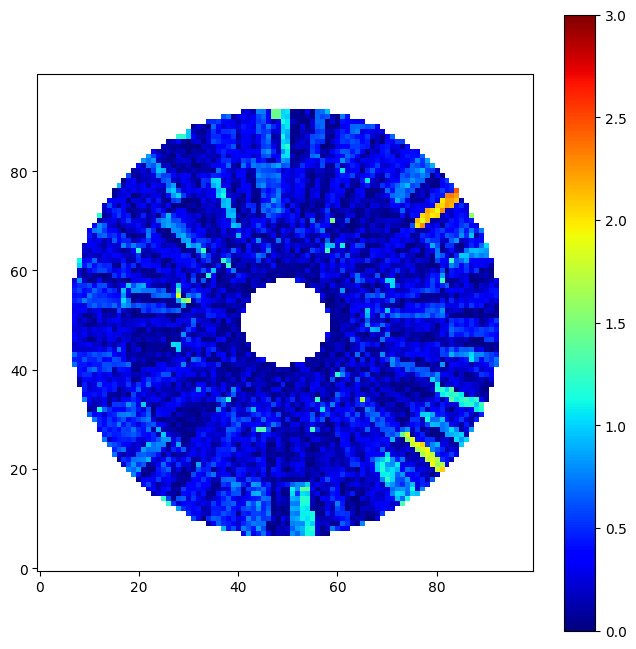

 >> Example 1
 >> Original image:


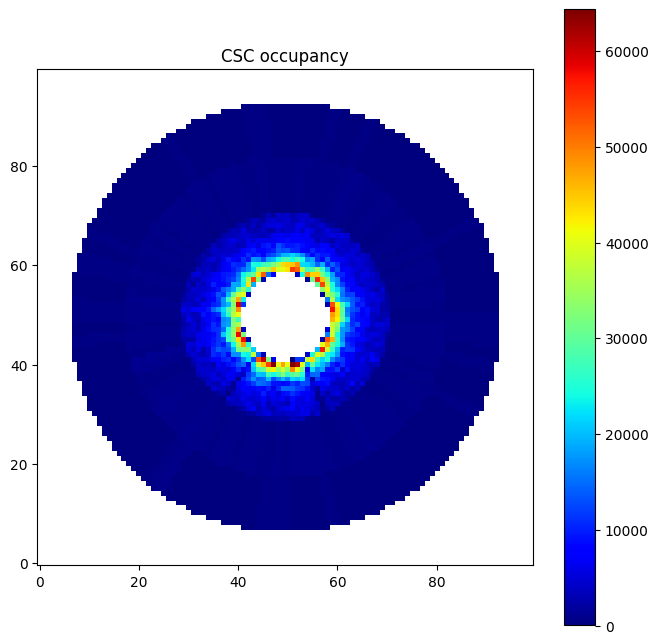

 >> AE-reco image:


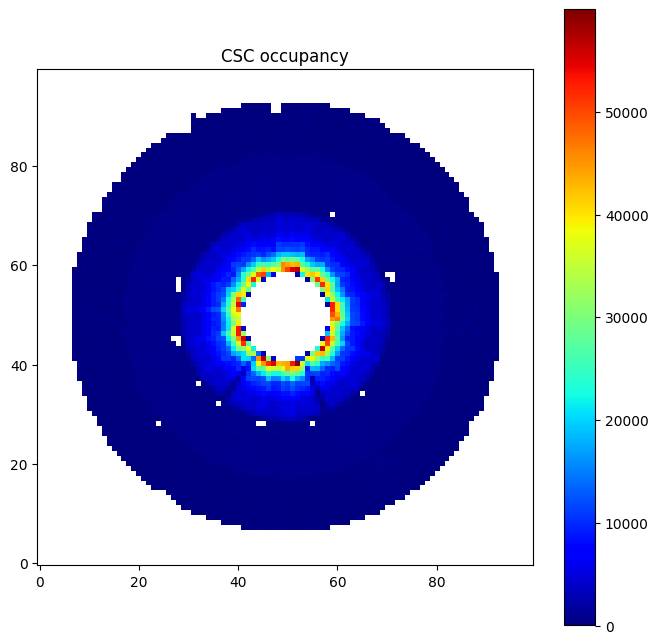

 >> Normalized loss map:


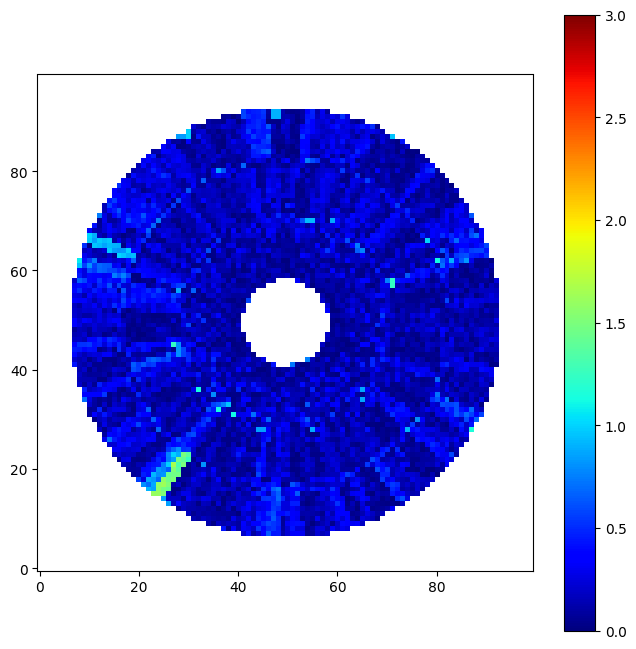

 >> Example 2
 >> Original image:


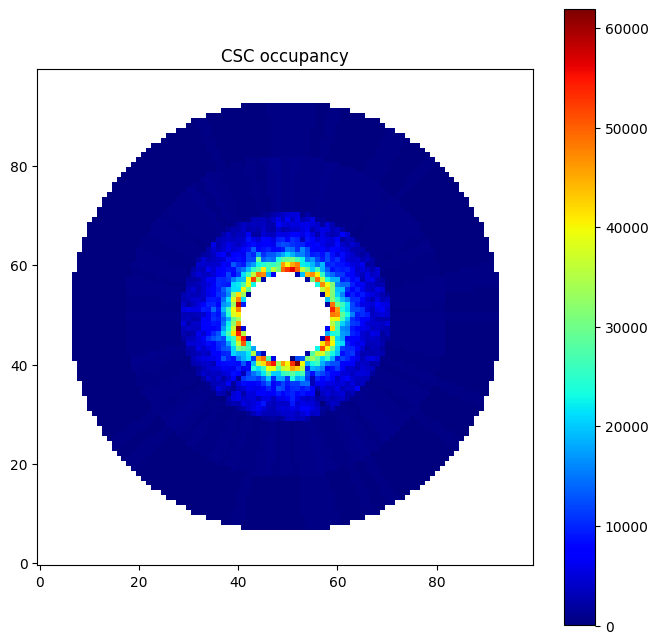

 >> AE-reco image:


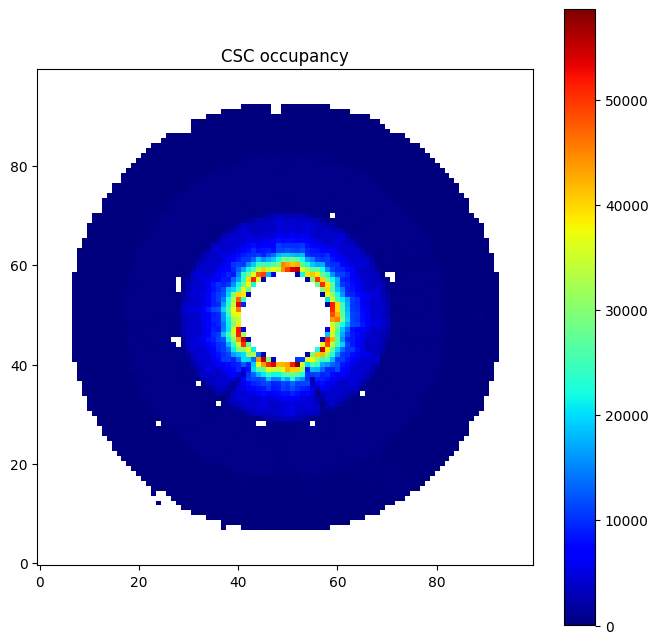

 >> Normalized loss map:


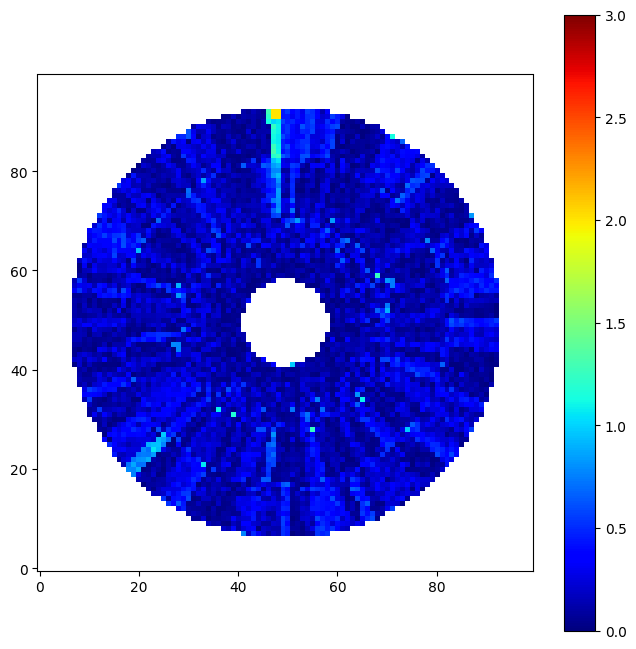

 >> Example 3
 >> Original image:


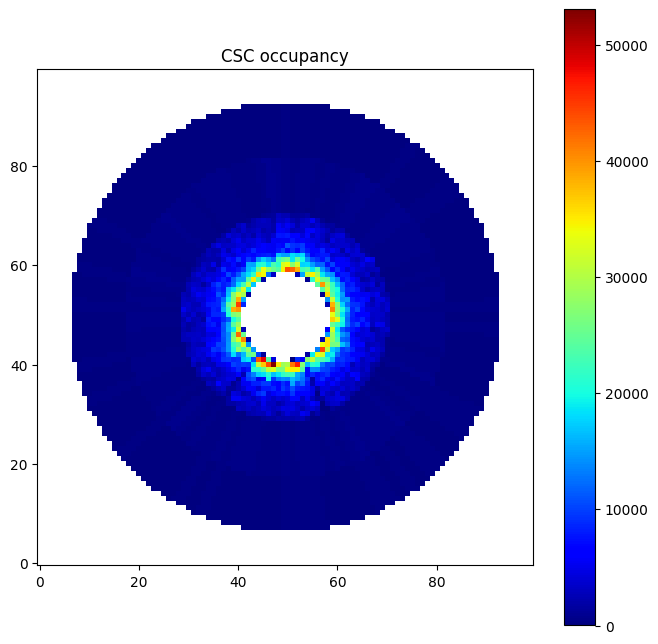

 >> AE-reco image:


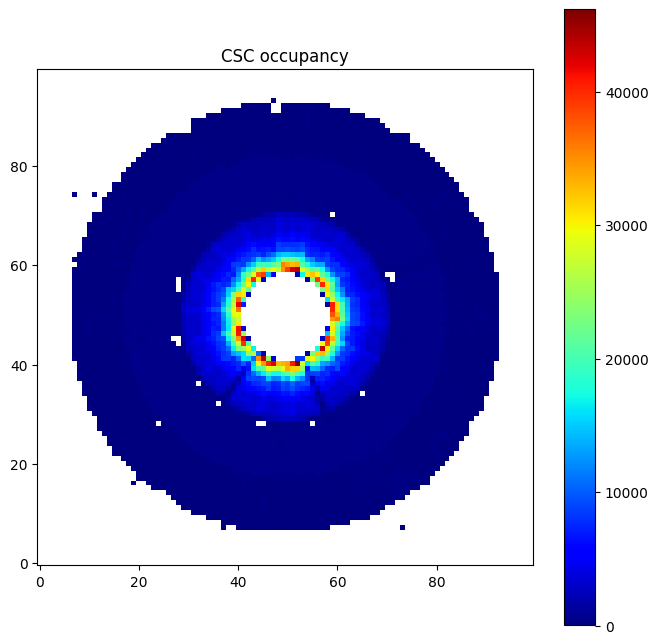

 >> Normalized loss map:


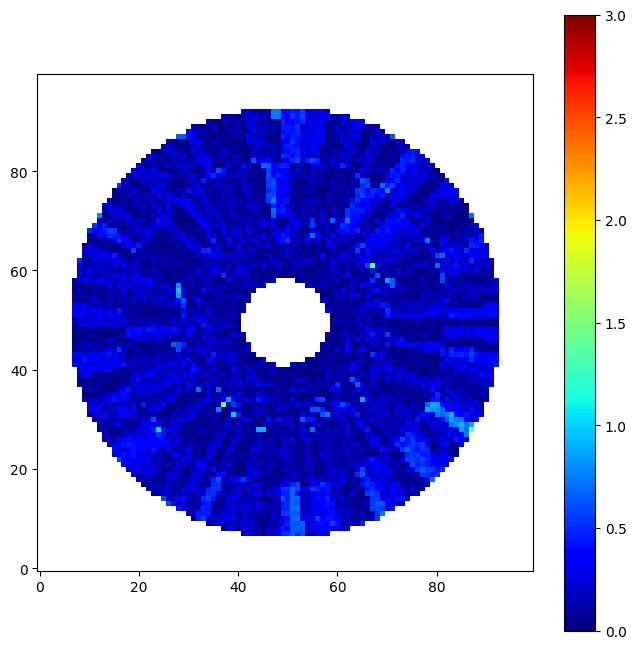

***** batch 10 *****
 >> Example 0
 >> Original image:


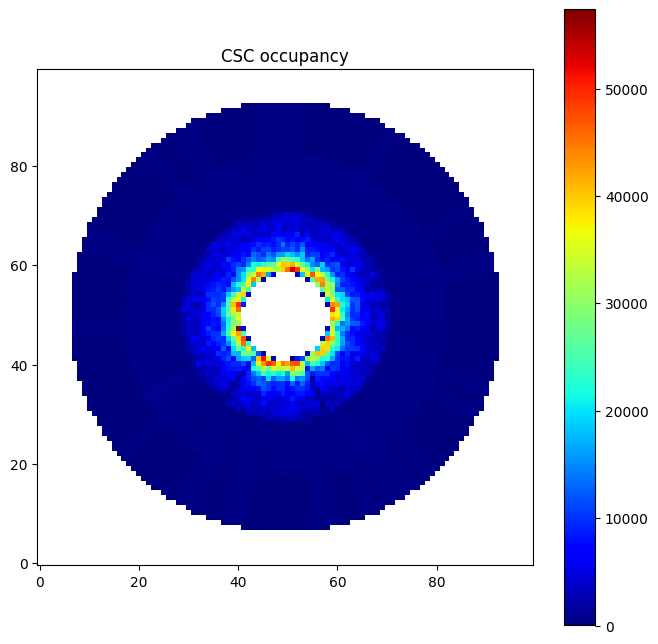

 >> AE-reco image:


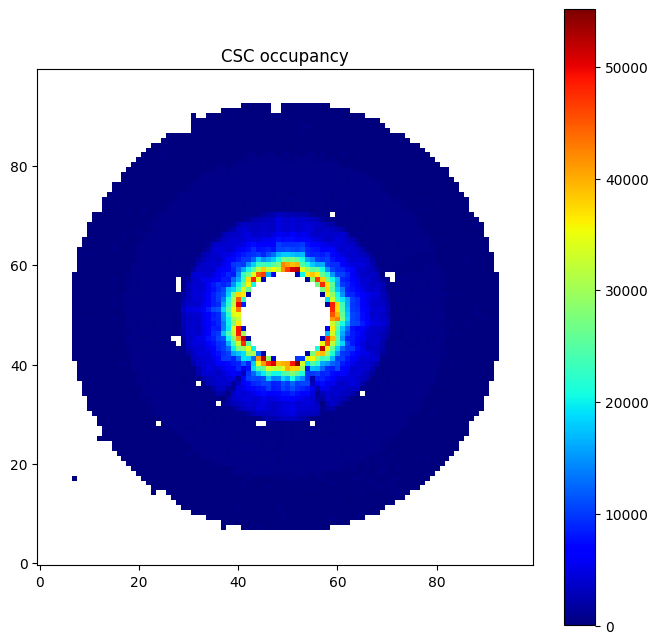

 >> Normalized loss map:


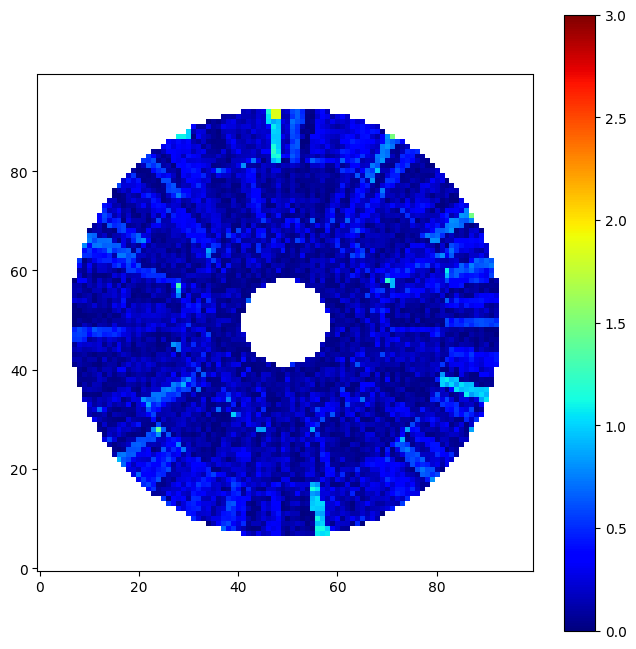

 >> Example 1
 >> Original image:


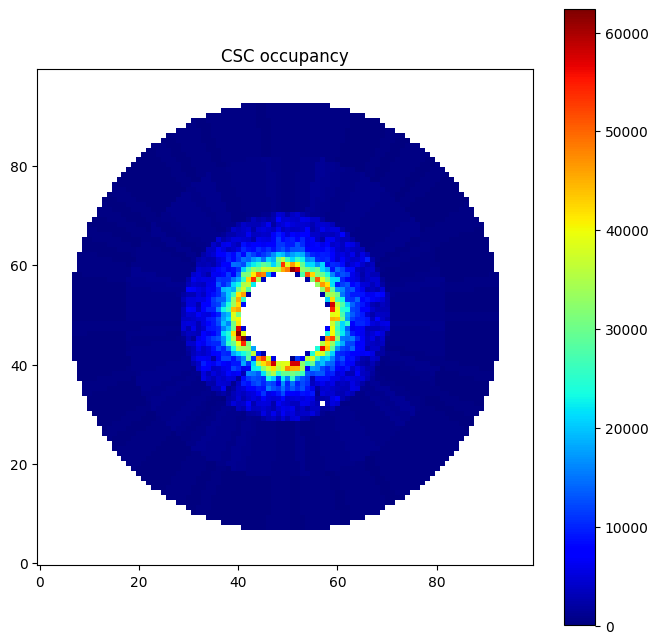

 >> AE-reco image:


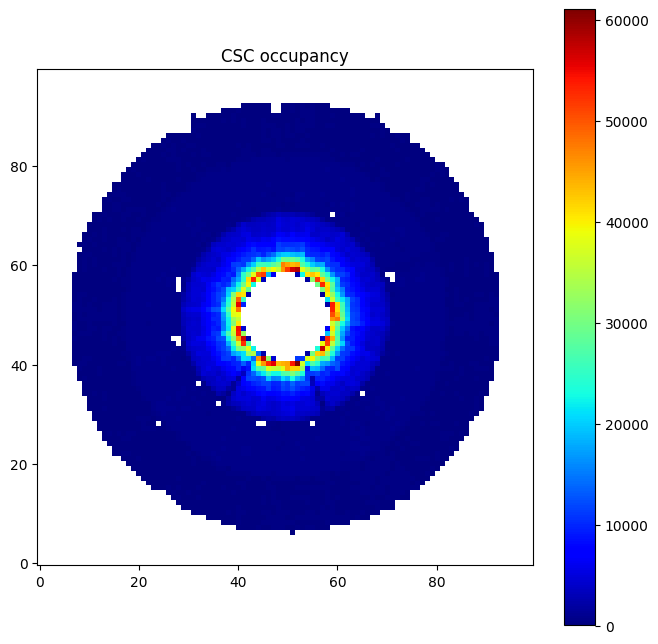

 >> Normalized loss map:


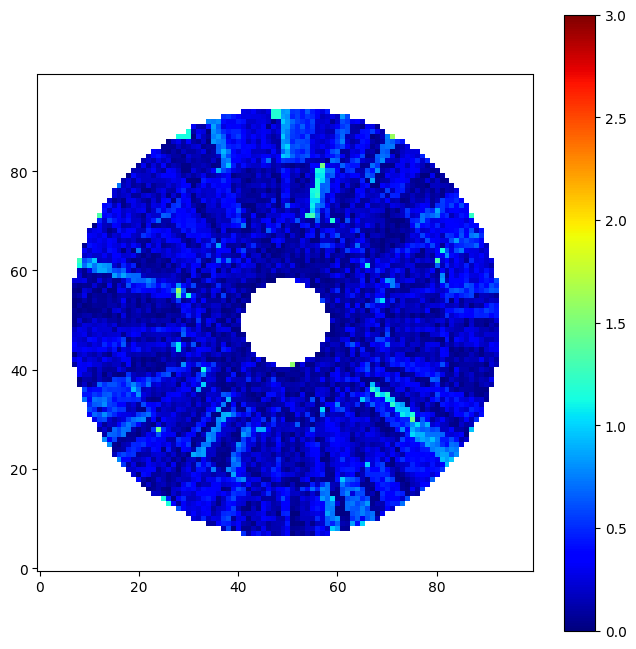

 >> Example 2
 >> Original image:


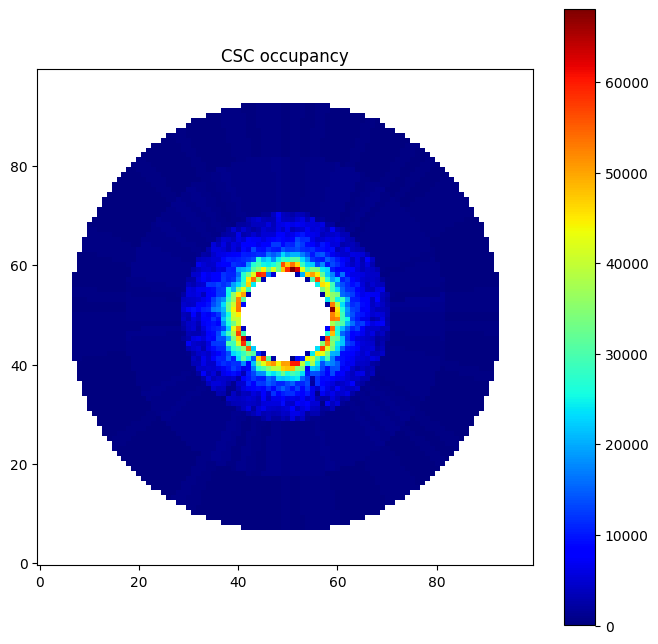

 >> AE-reco image:


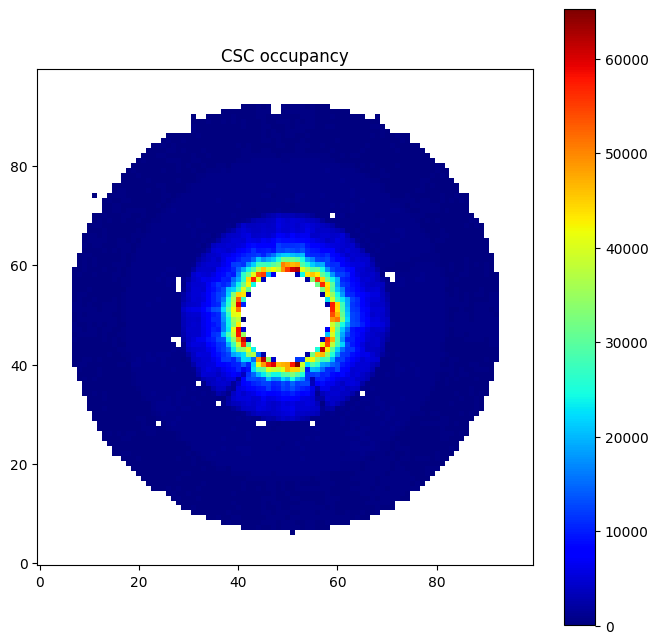

 >> Normalized loss map:


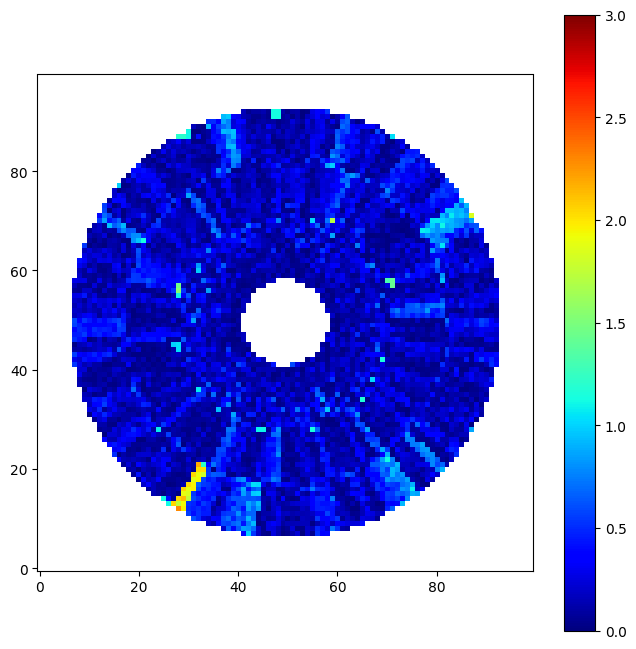

 >> Example 3
 >> Original image:


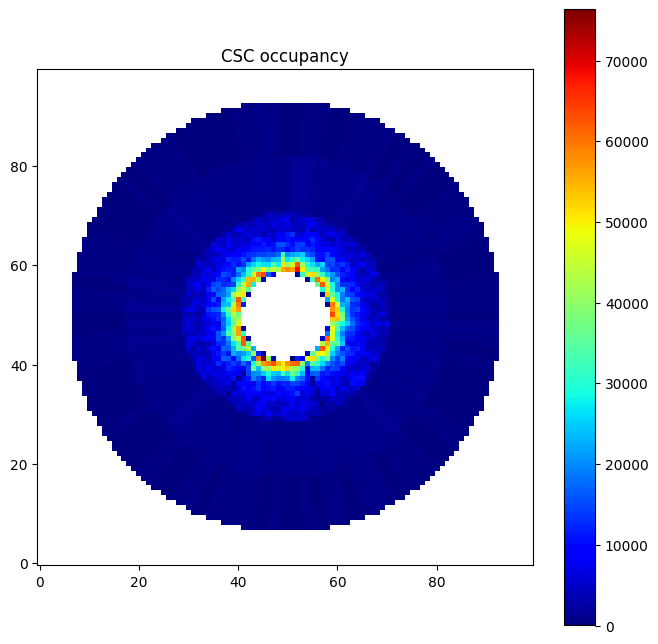

 >> AE-reco image:


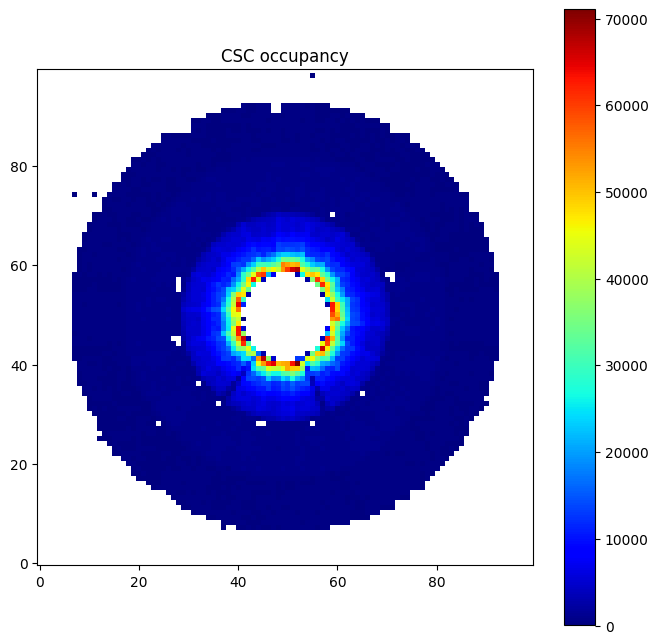

 >> Normalized loss map:


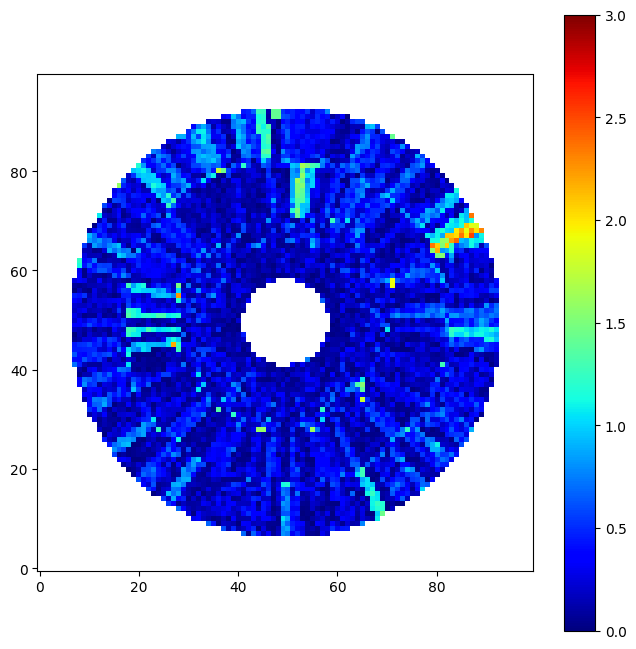

***** batch 11 *****
 >> Example 0
 >> Original image:


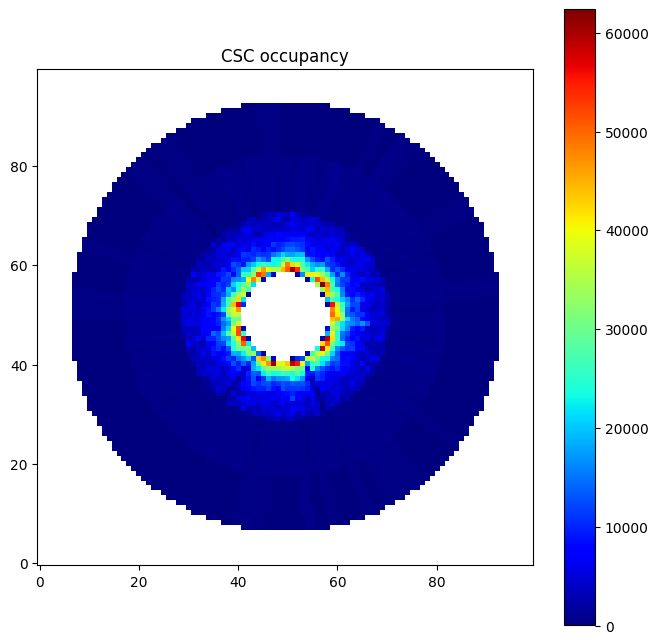

 >> AE-reco image:


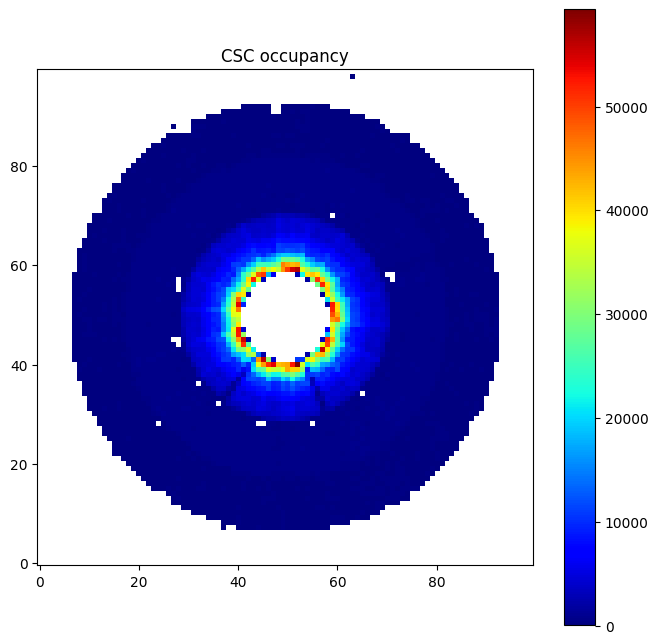

 >> Normalized loss map:


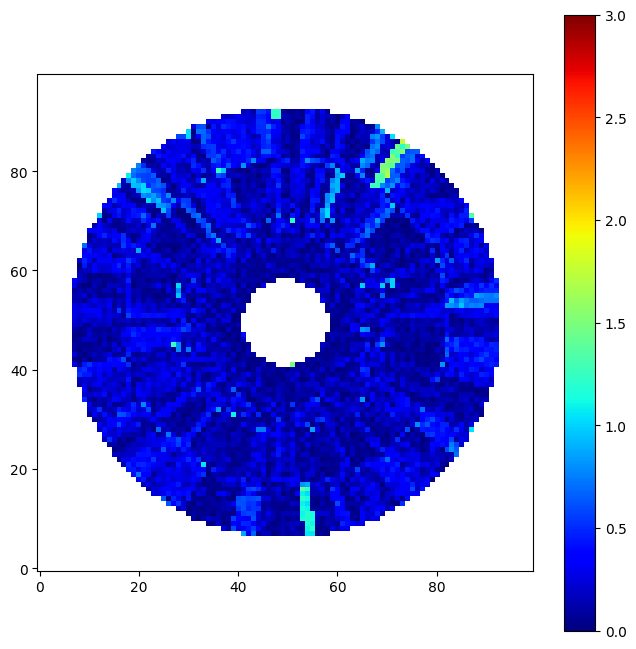

 >> Example 1
 >> Original image:


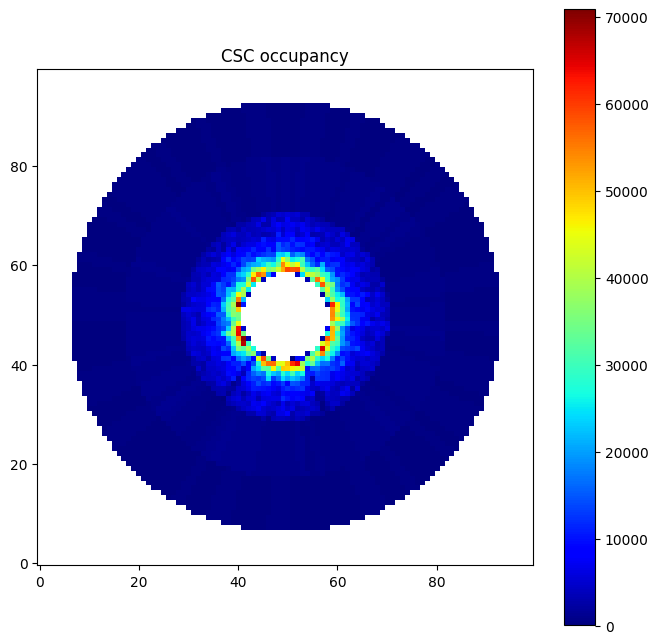

 >> AE-reco image:


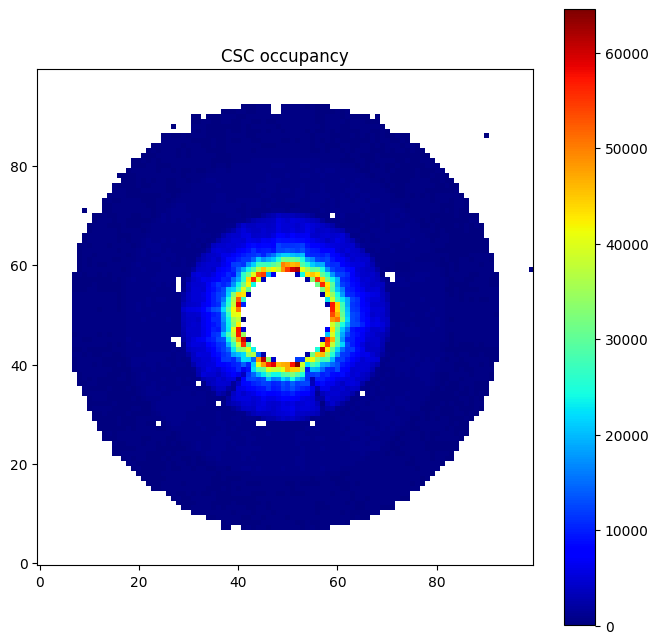

 >> Normalized loss map:


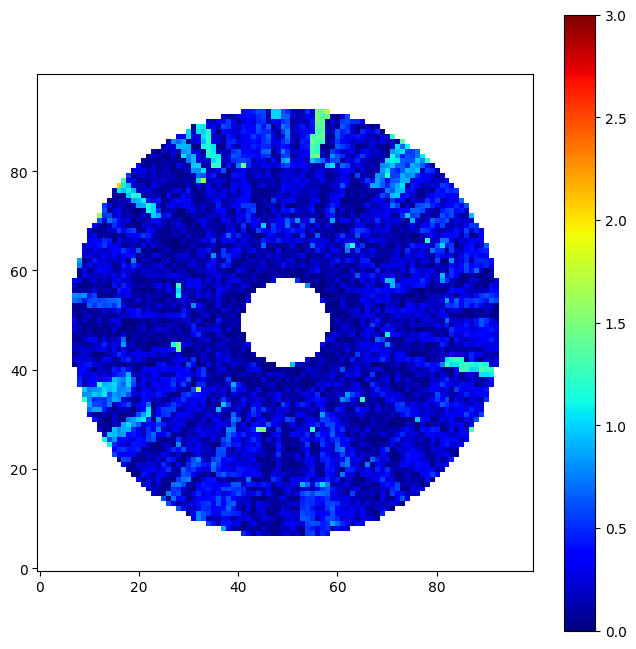

 >> Example 2
 >> Original image:


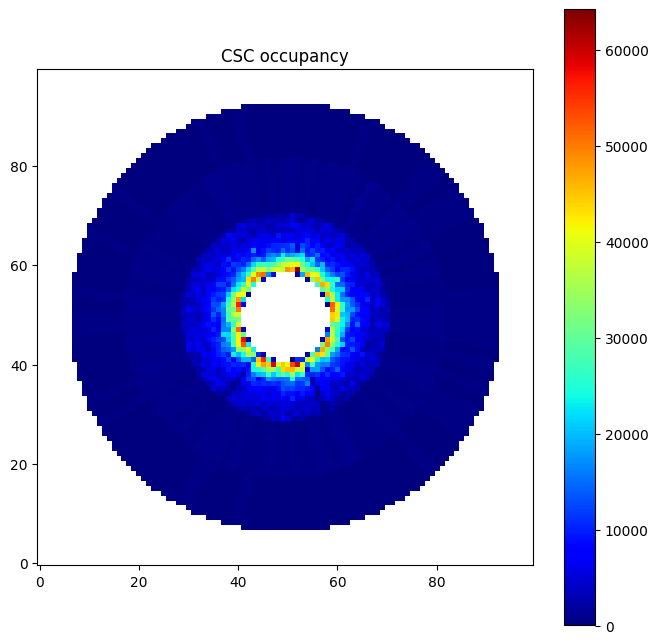

 >> AE-reco image:


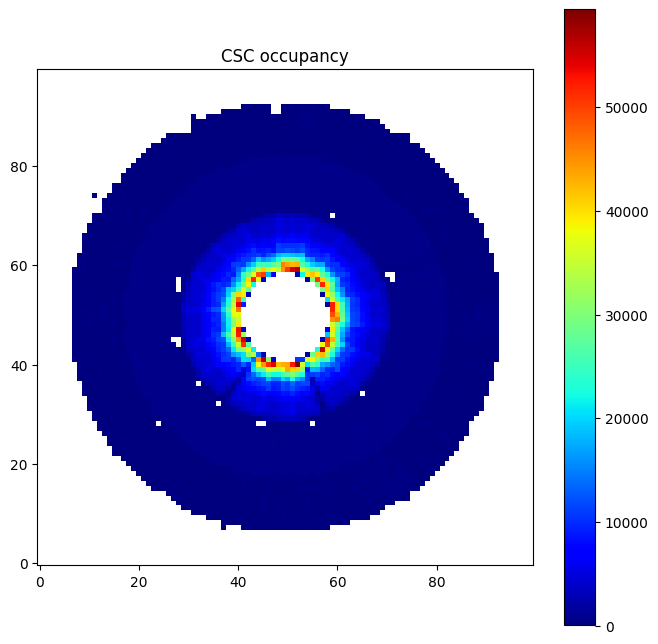

 >> Normalized loss map:


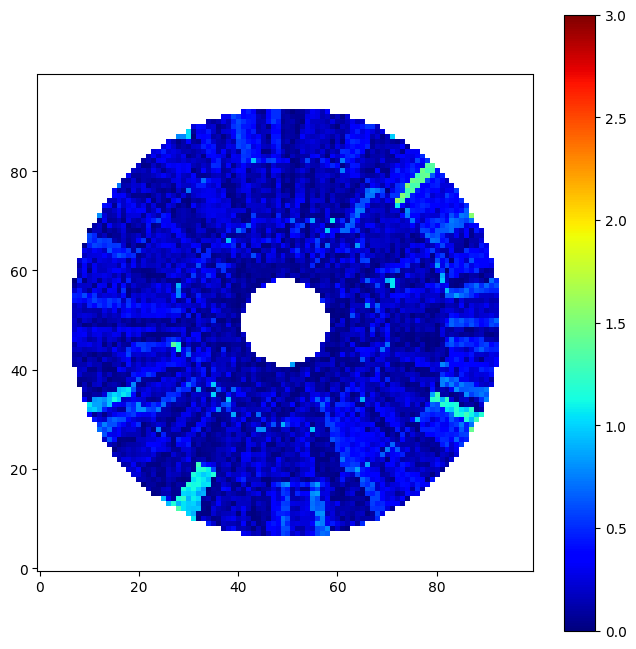

 >> Example 3
 >> Original image:


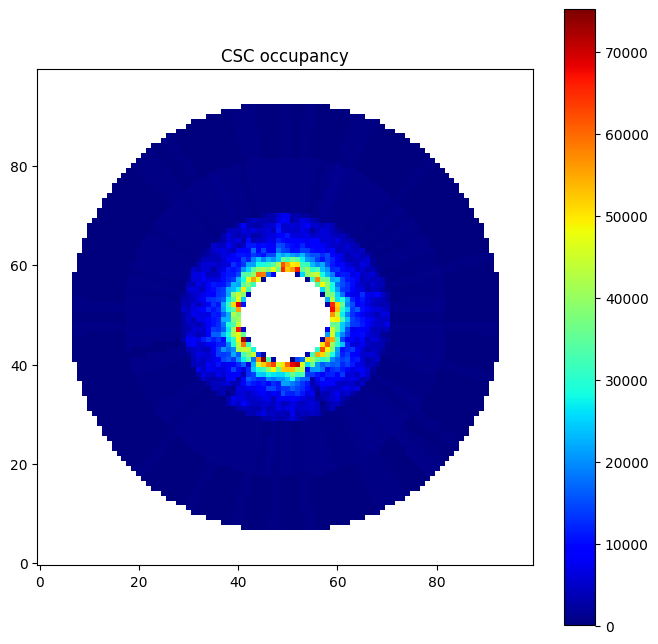

 >> AE-reco image:


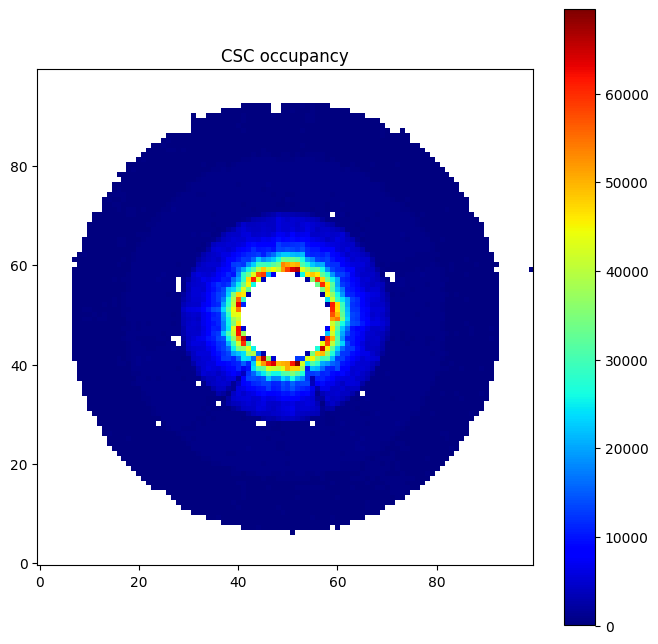

 >> Normalized loss map:


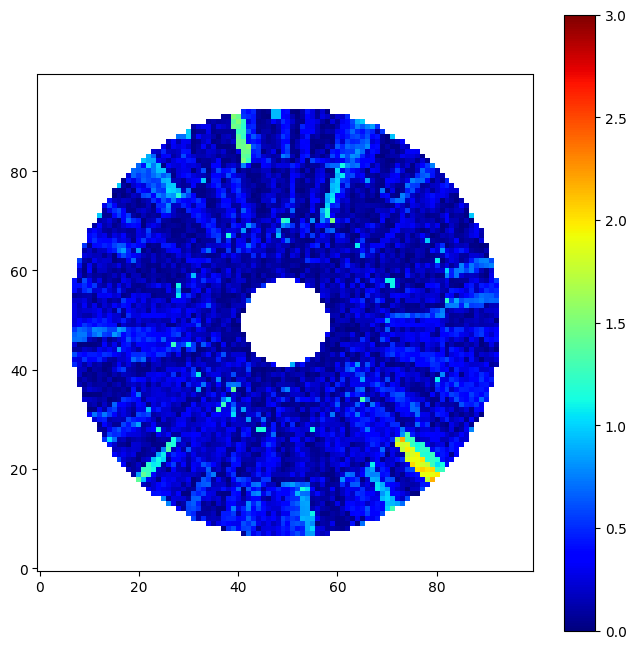

***** batch 12 *****
 >> Example 0
 >> Original image:


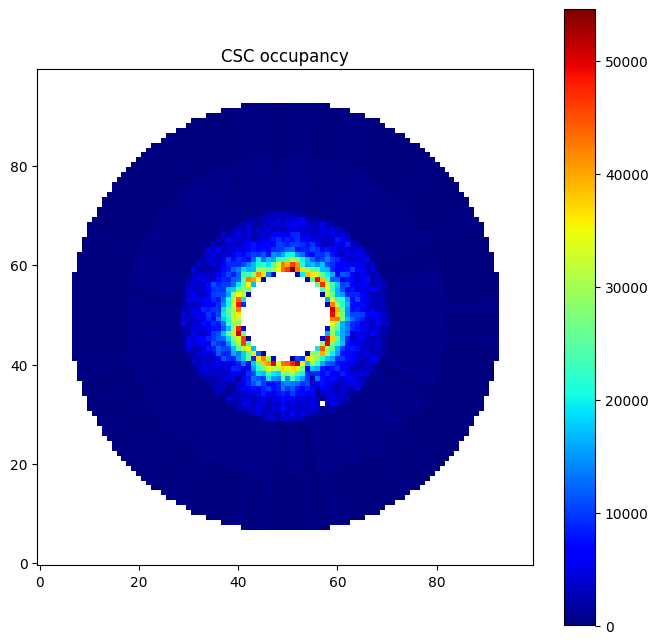

 >> AE-reco image:


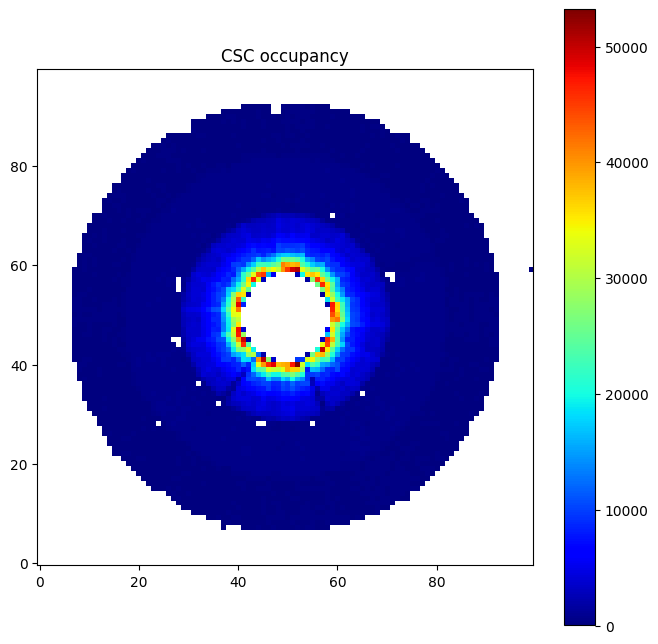

 >> Normalized loss map:


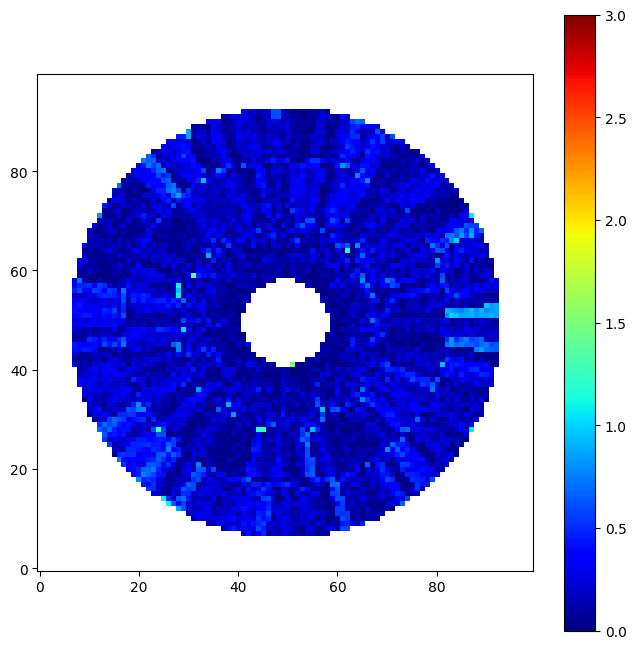

 >> Example 1
 >> Original image:


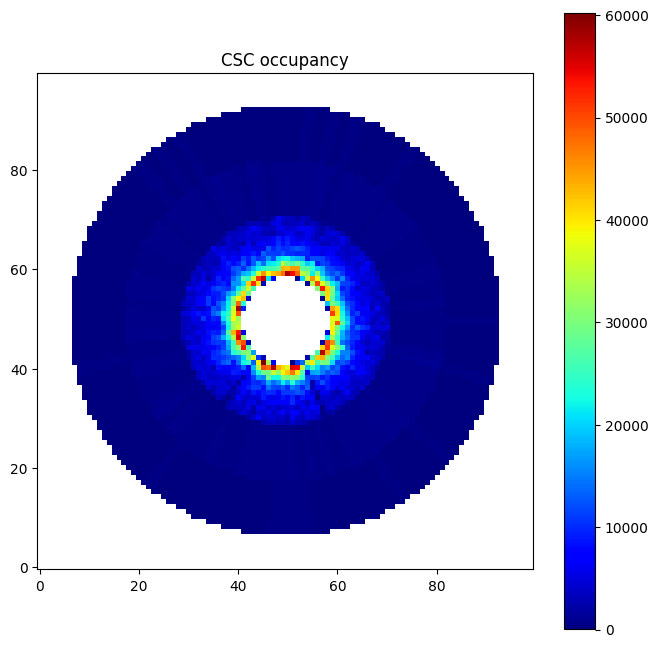

 >> AE-reco image:


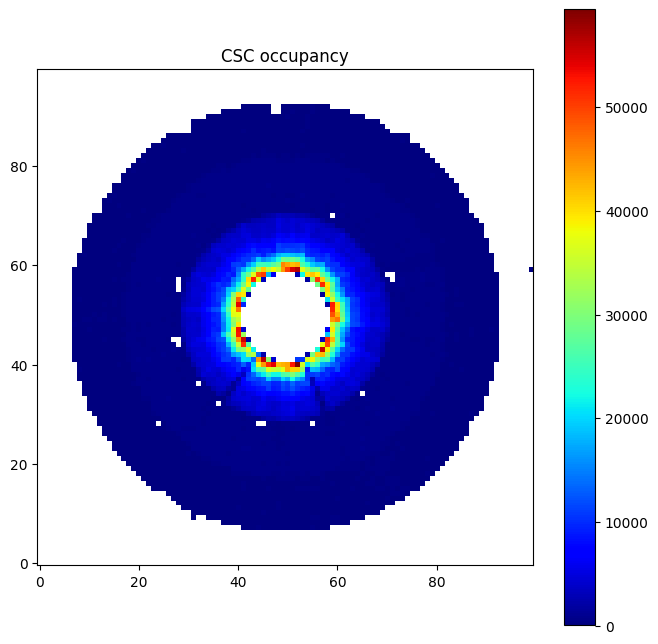

 >> Normalized loss map:


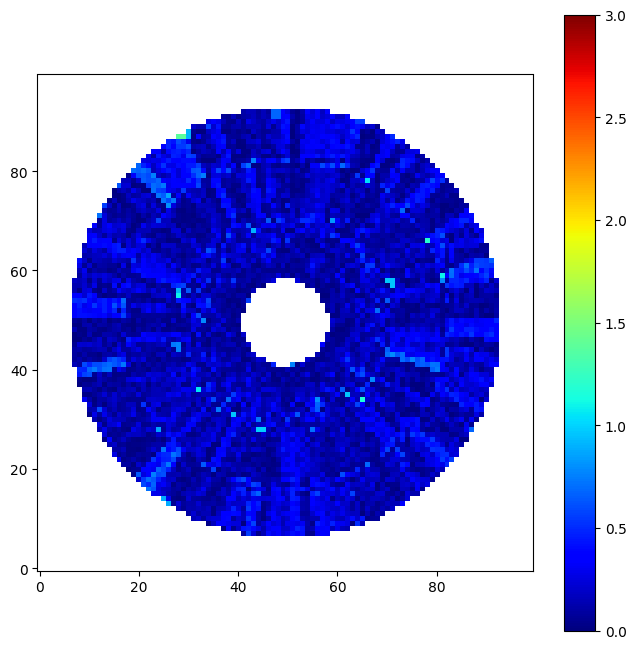

 >> Example 2
 >> Original image:


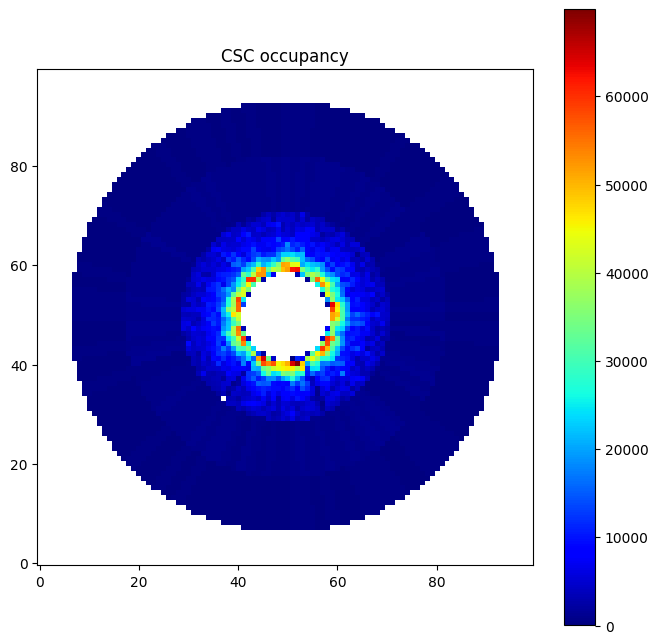

 >> AE-reco image:


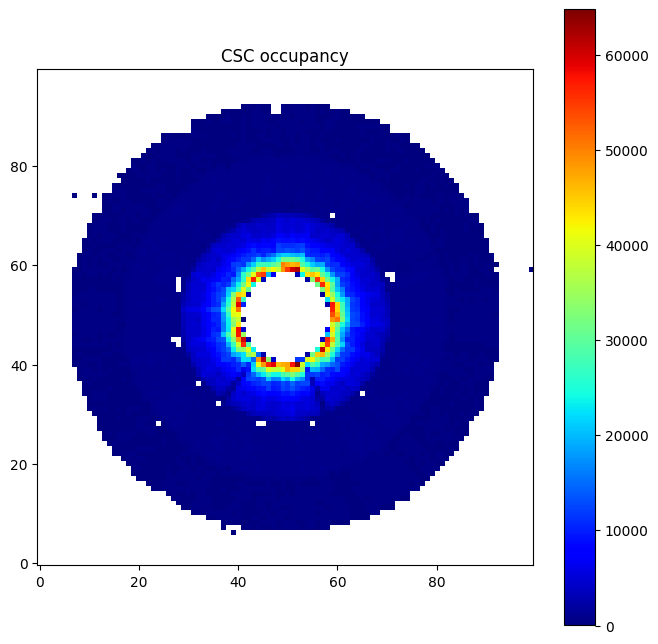

 >> Normalized loss map:


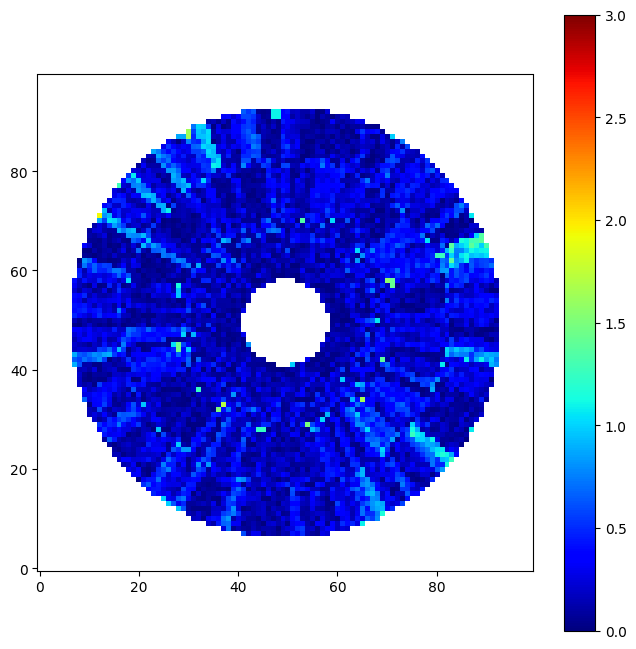

 >> Example 3
 >> Original image:


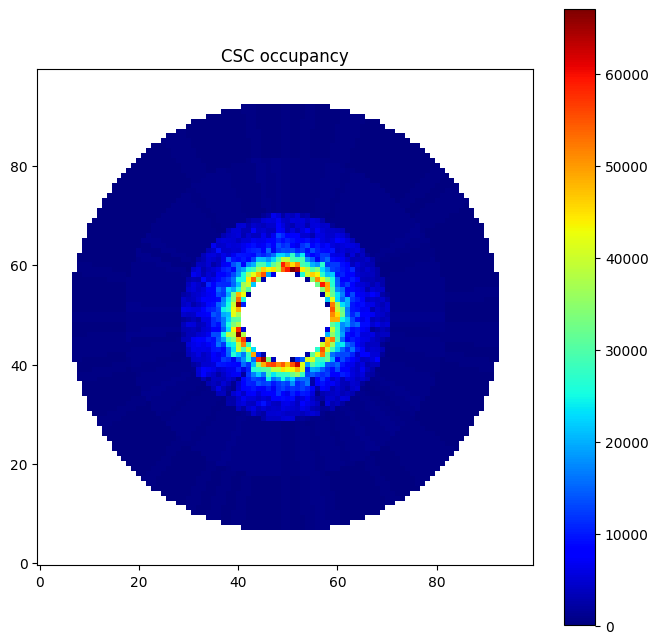

 >> AE-reco image:


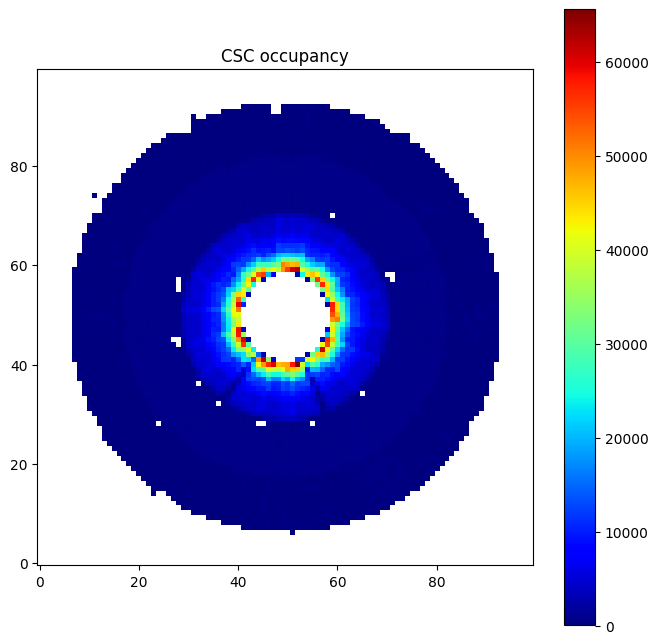

 >> Normalized loss map:


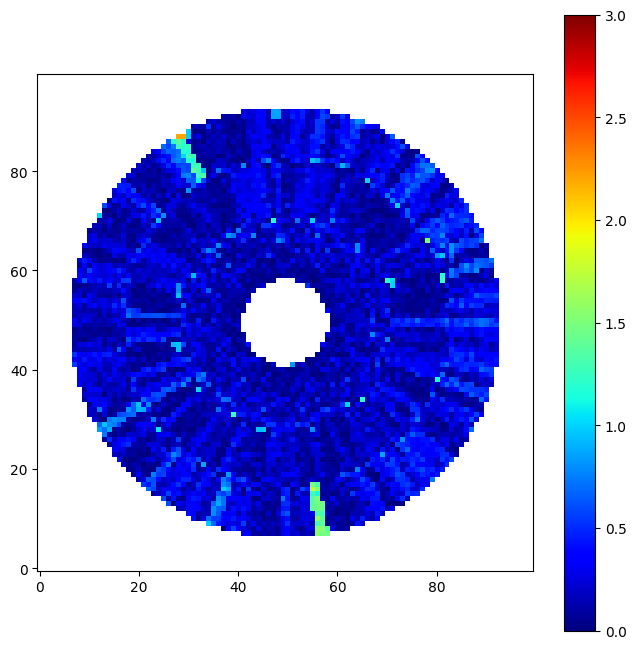

***** batch 13 *****
 >> Example 0
 >> Original image:


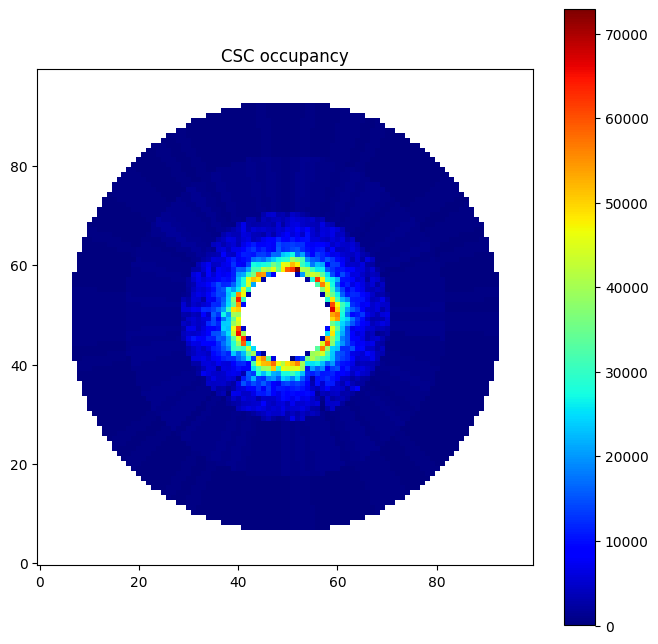

 >> AE-reco image:


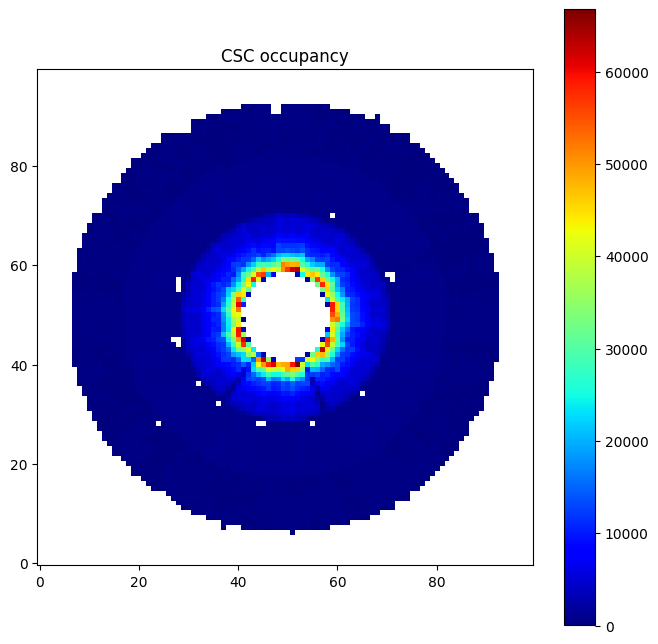

 >> Normalized loss map:


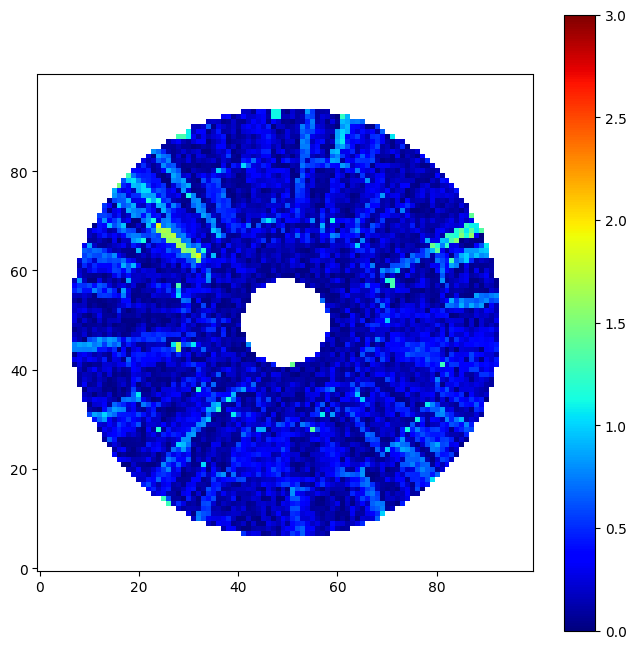

 >> Example 1
 >> Original image:


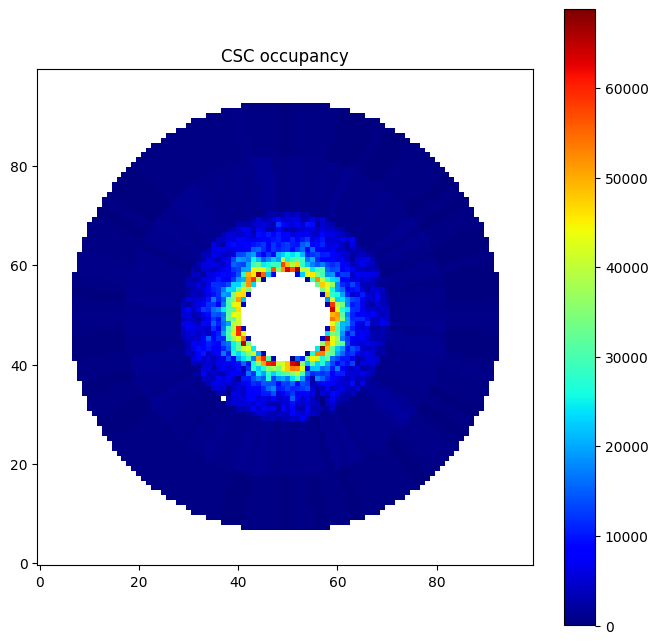

 >> AE-reco image:


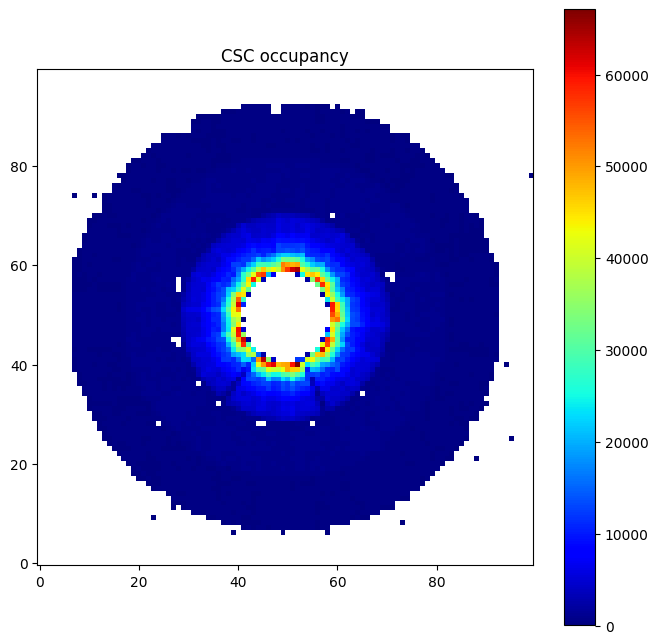

 >> Normalized loss map:


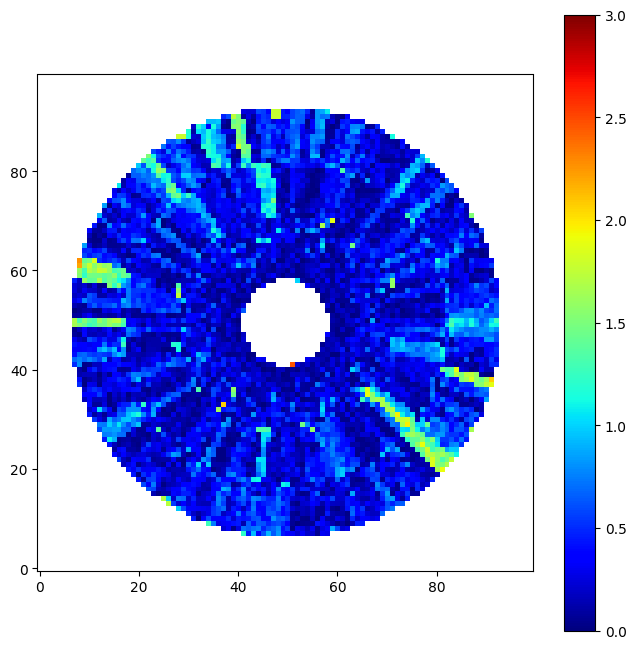

 >> Example 2
 >> Original image:


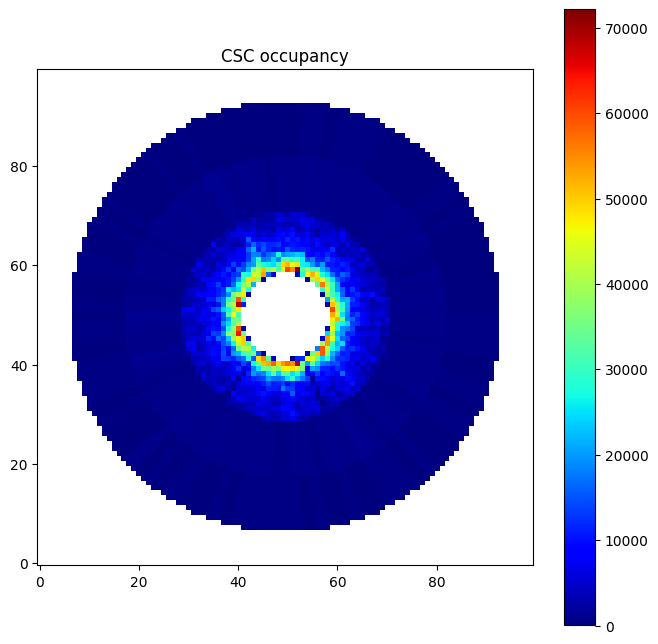

 >> AE-reco image:


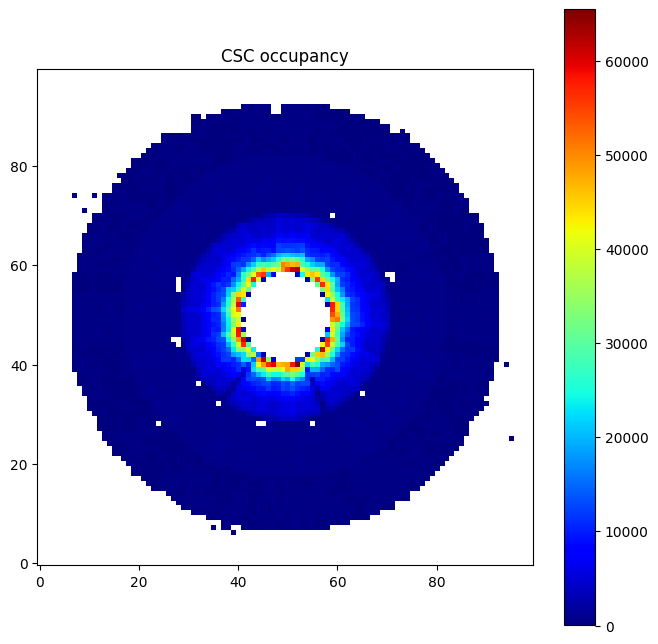

 >> Normalized loss map:


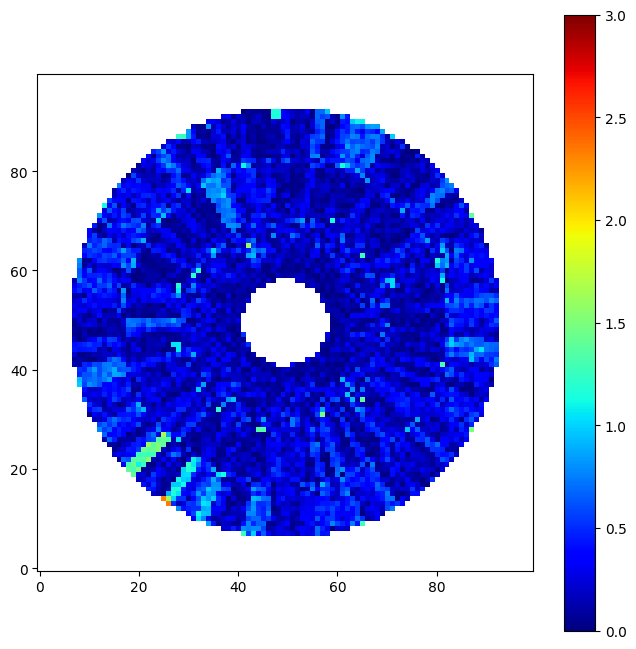

 >> Example 3
 >> Original image:


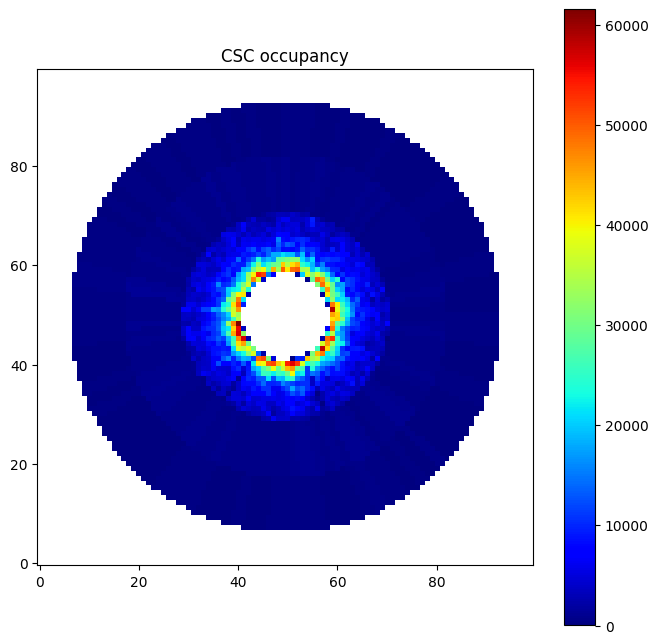

 >> AE-reco image:


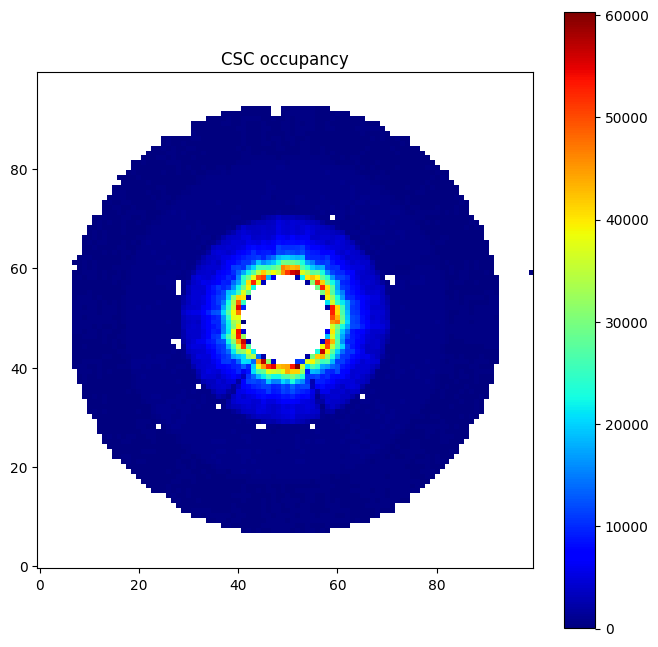

 >> Normalized loss map:


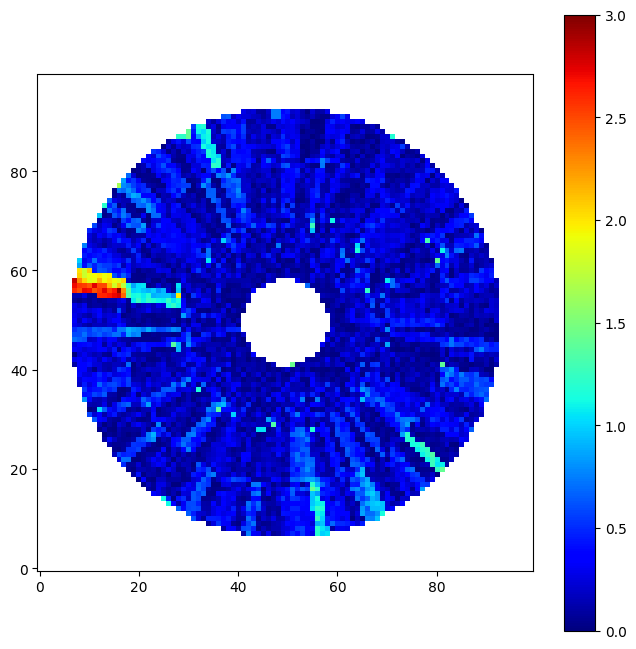

***** batch 14 *****
 >> Example 0
 >> Original image:


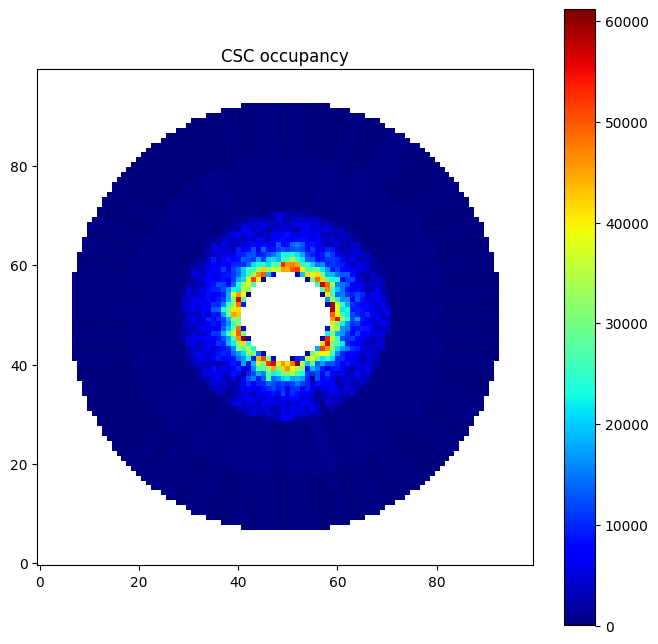

 >> AE-reco image:


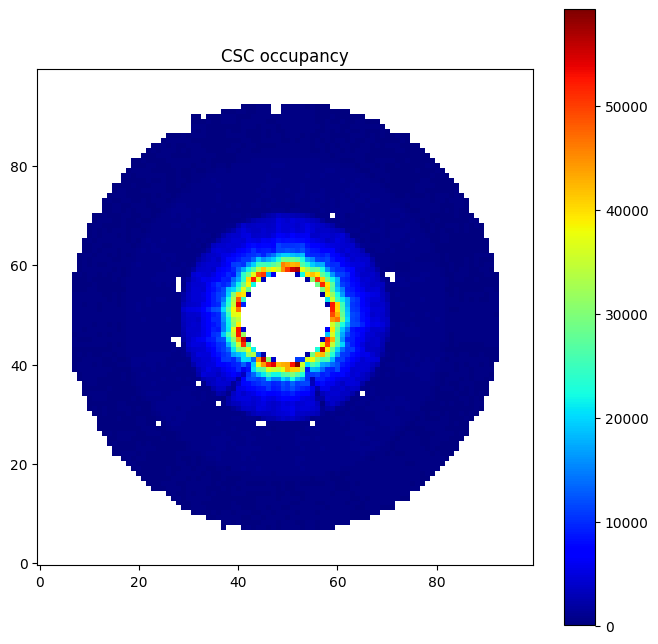

 >> Normalized loss map:


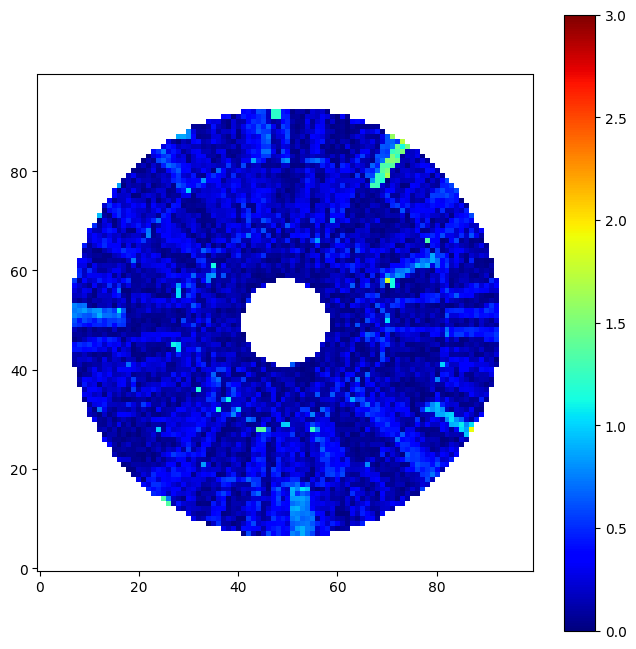

 >> Example 1
 >> Original image:


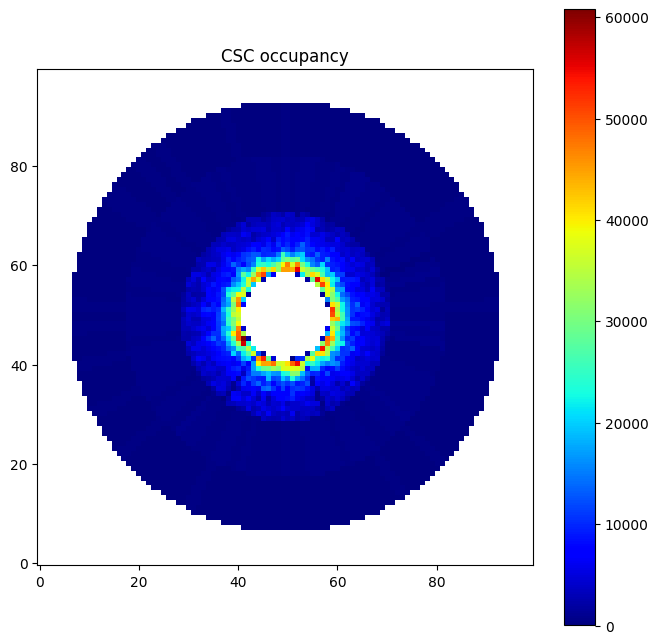

 >> AE-reco image:


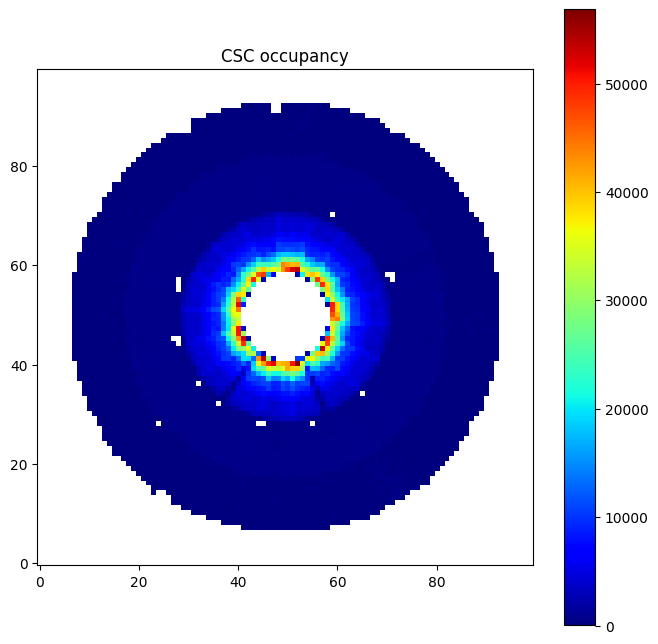

 >> Normalized loss map:


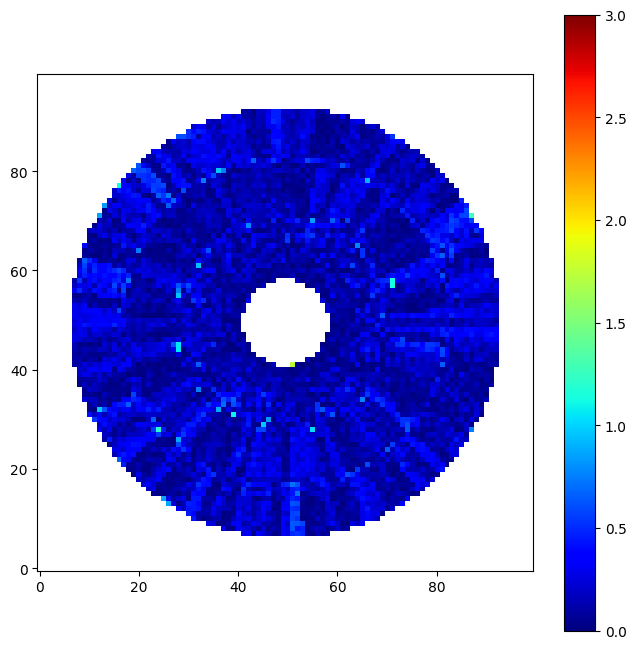

 >> Example 2
 >> Original image:


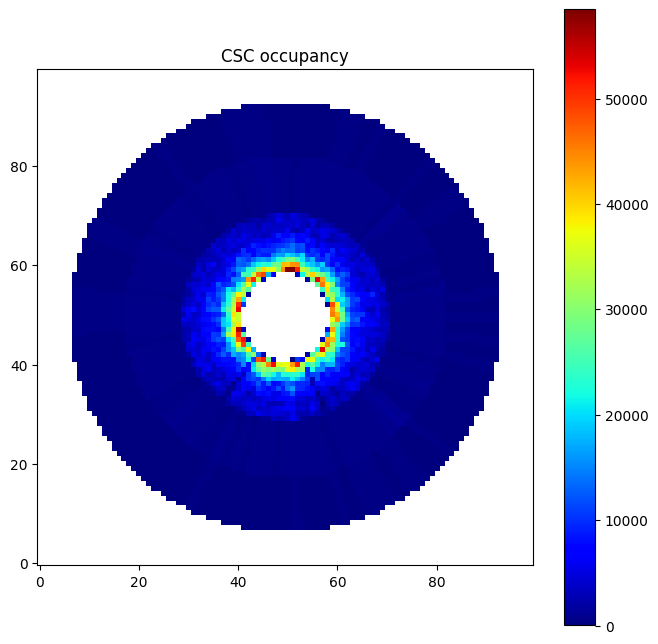

 >> AE-reco image:


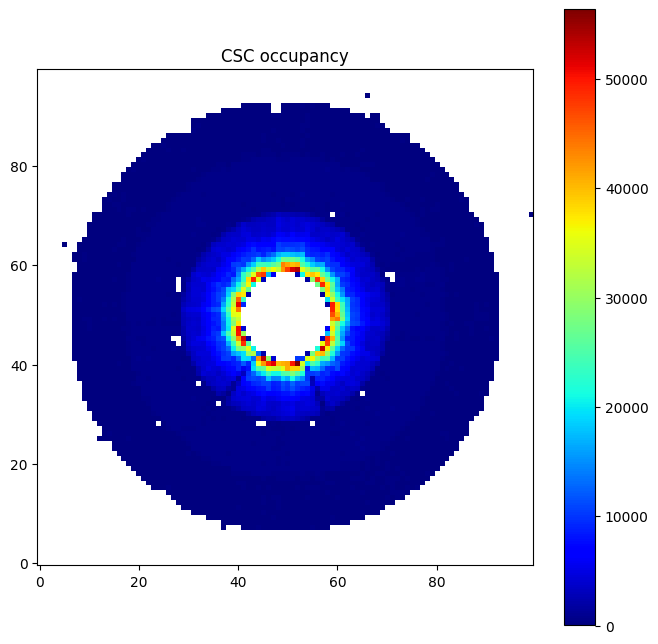

 >> Normalized loss map:


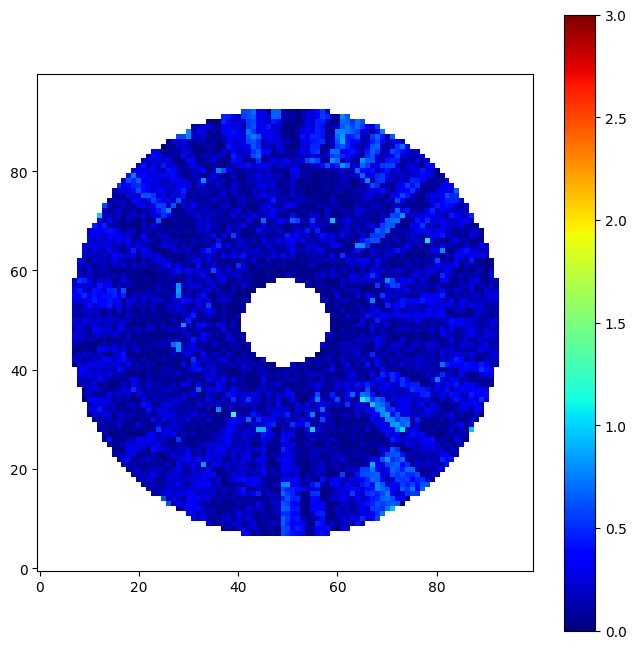

 >> Example 3
 >> Original image:


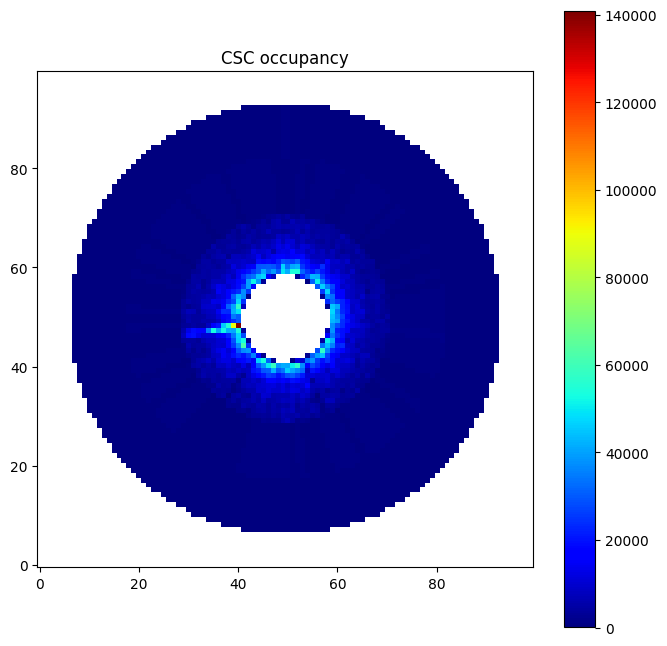

 >> AE-reco image:


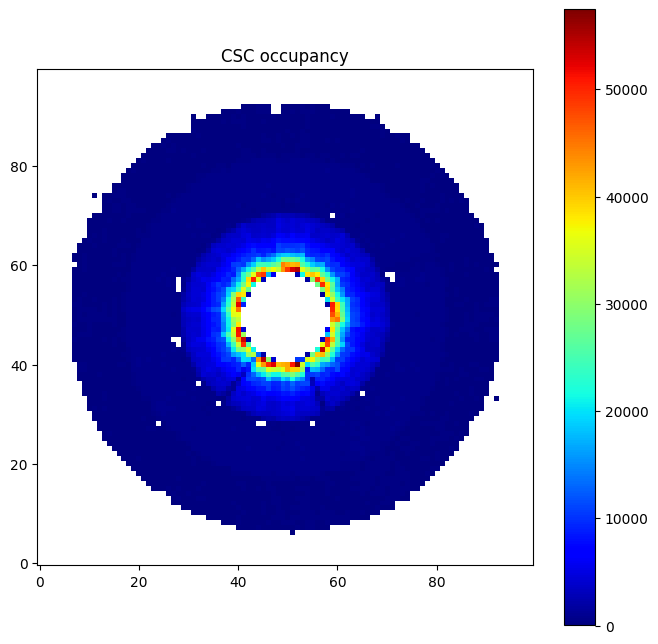

 >> Normalized loss map:


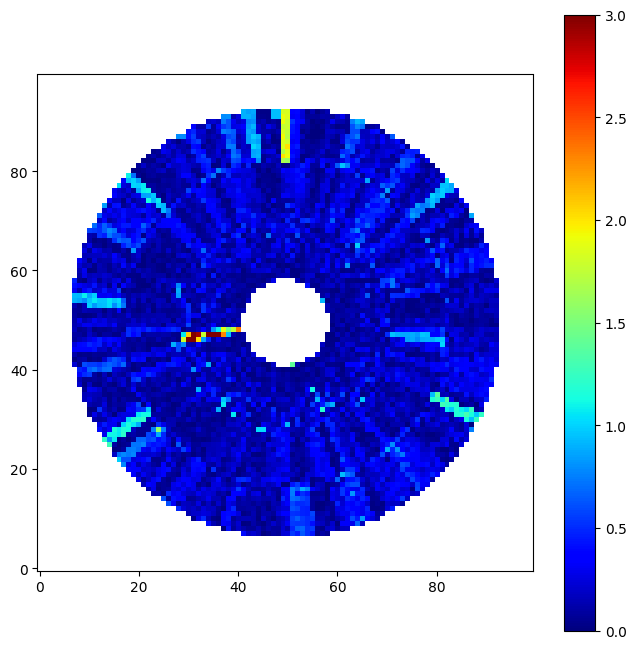

***** batch 15 *****
 >> Example 0
 >> Original image:


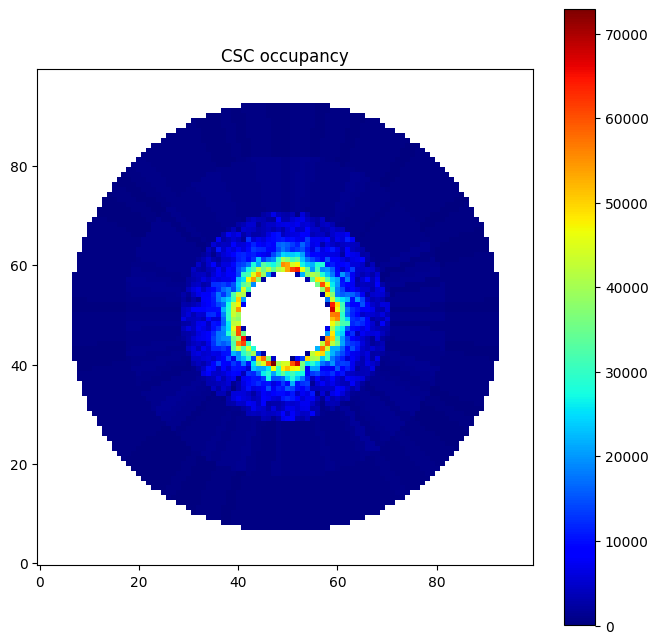

 >> AE-reco image:


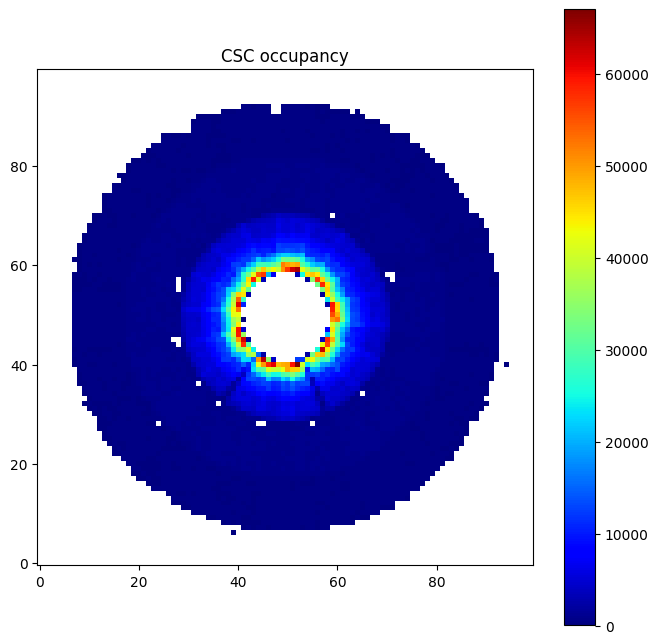

 >> Normalized loss map:


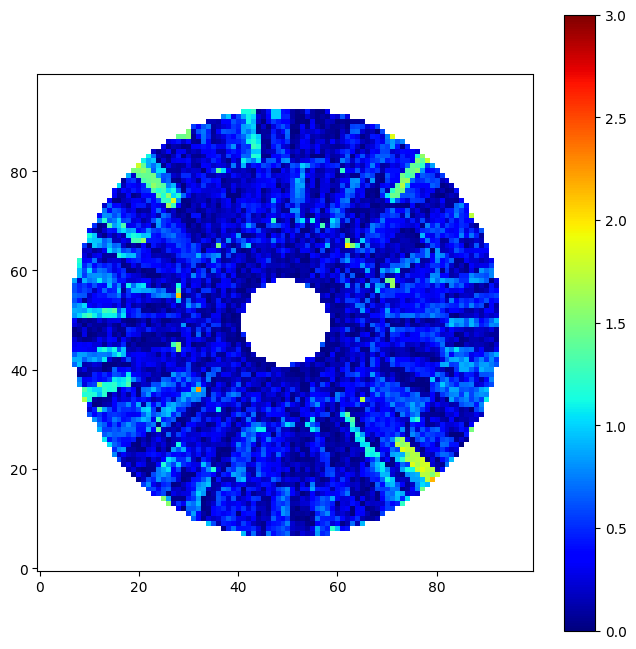

 >> Example 1
 >> Original image:


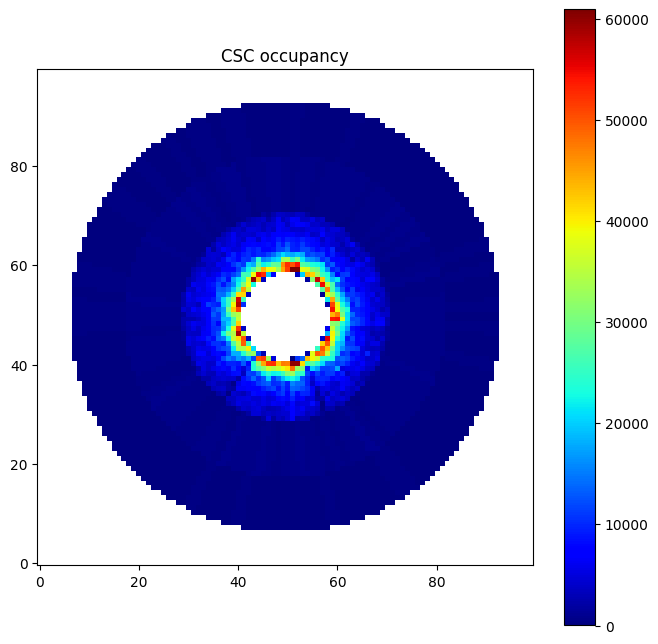

 >> AE-reco image:


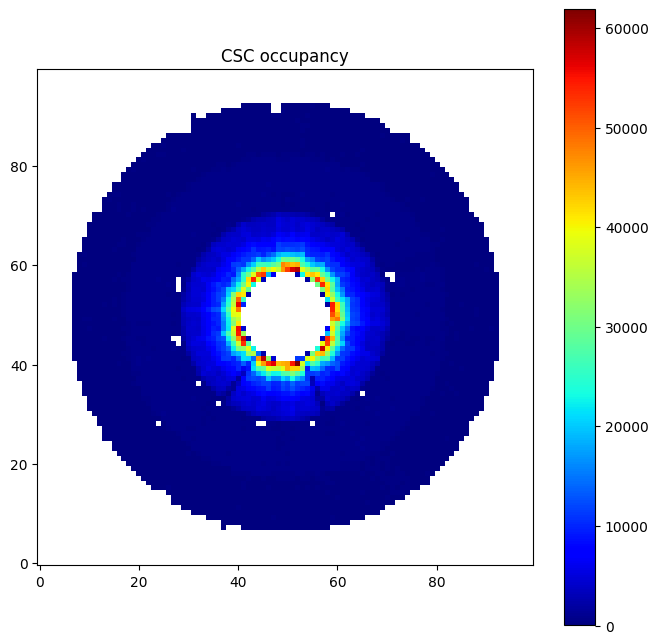

 >> Normalized loss map:


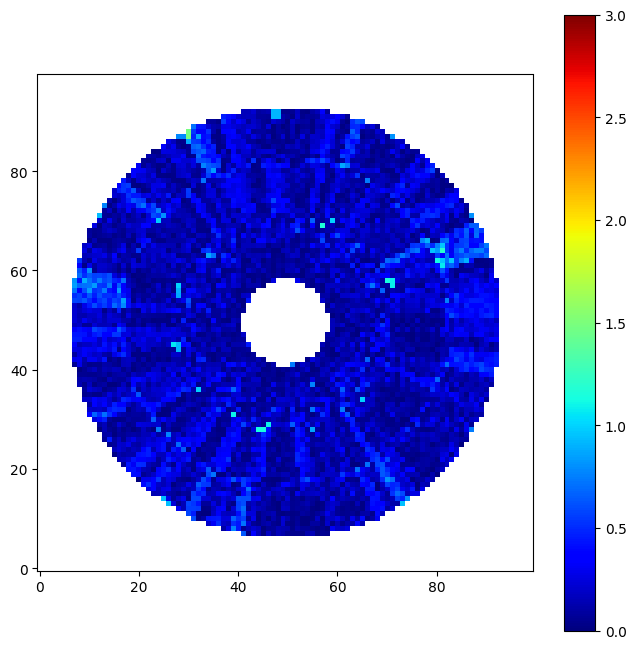

 >> Example 2
 >> Original image:


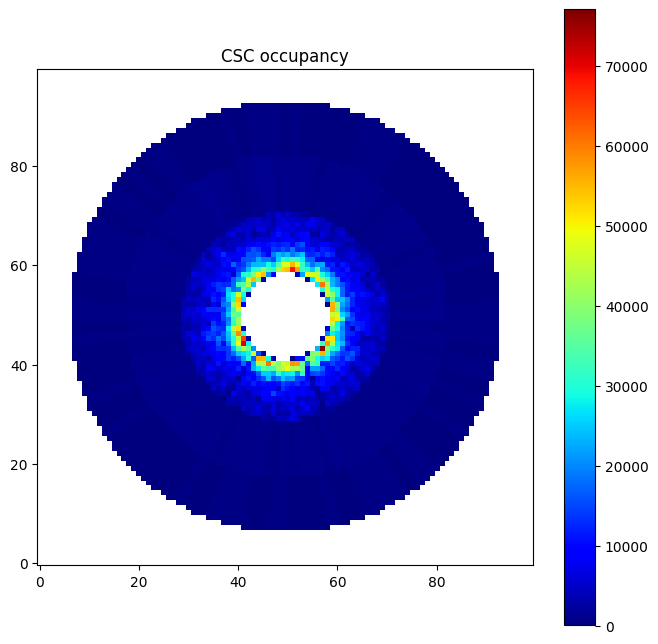

 >> AE-reco image:


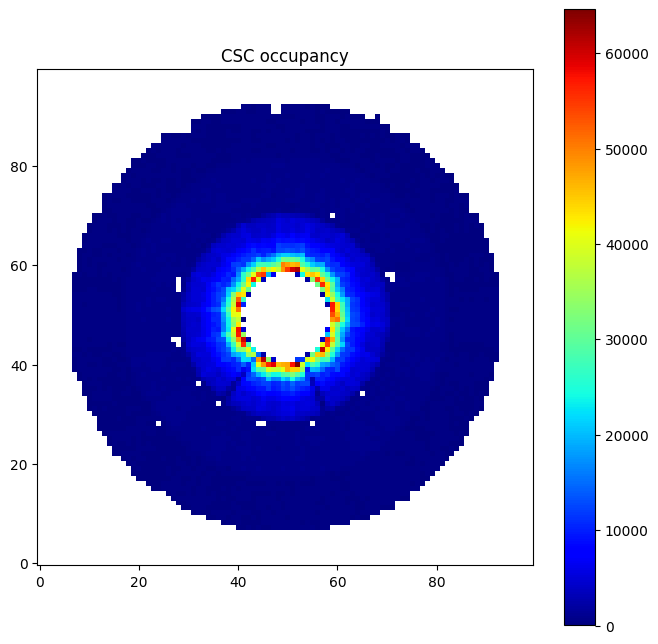

 >> Normalized loss map:


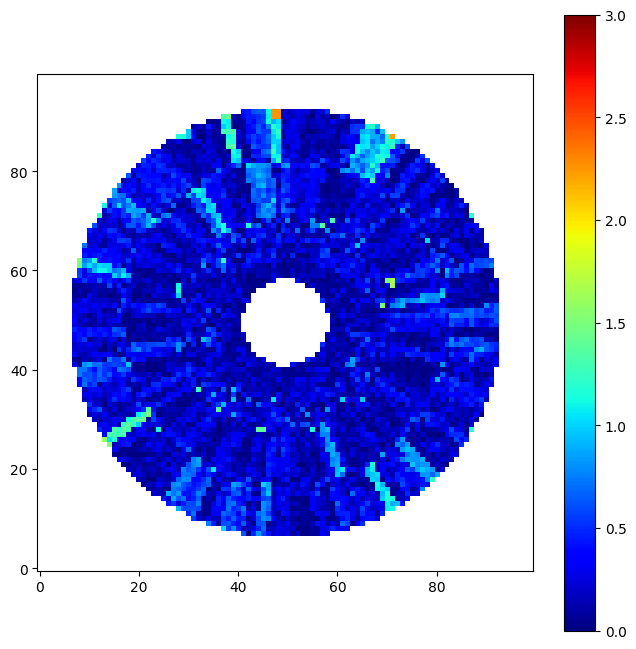

 >> Example 3
 >> Original image:


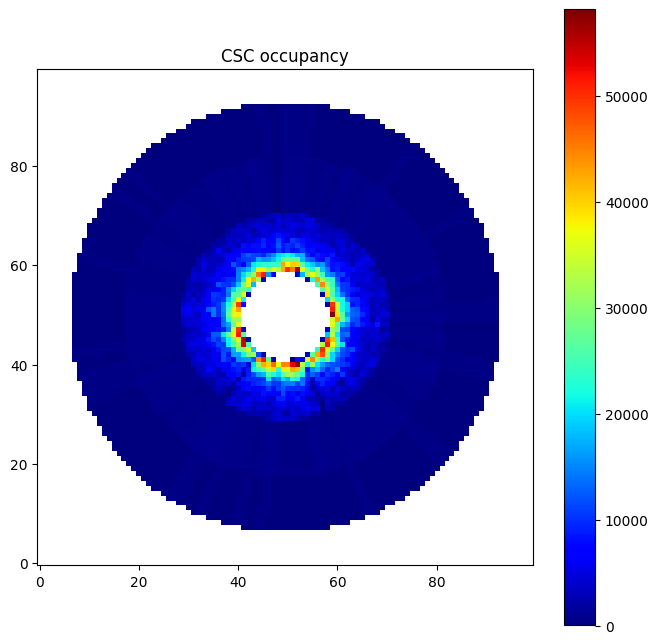

 >> AE-reco image:


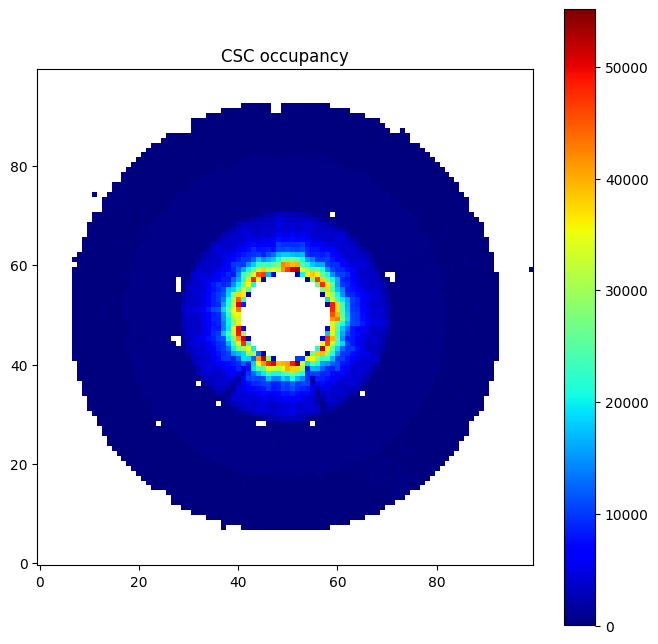

 >> Normalized loss map:


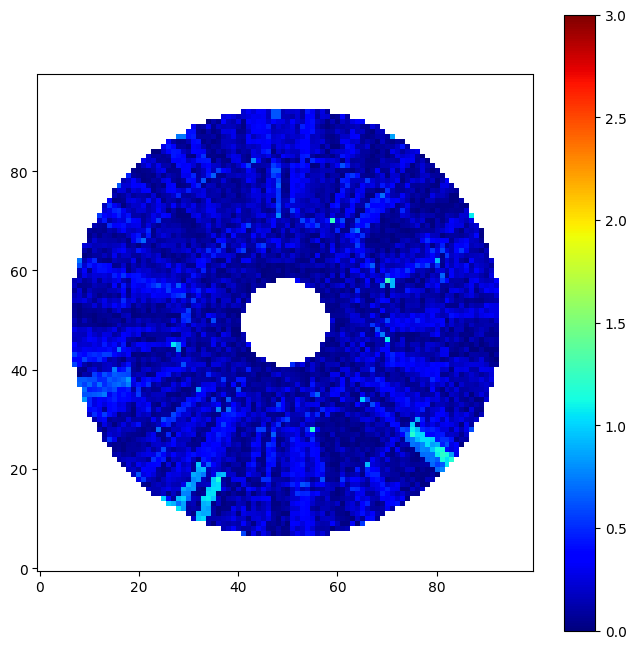

***** batch 16 *****
 >> Example 0
 >> Original image:


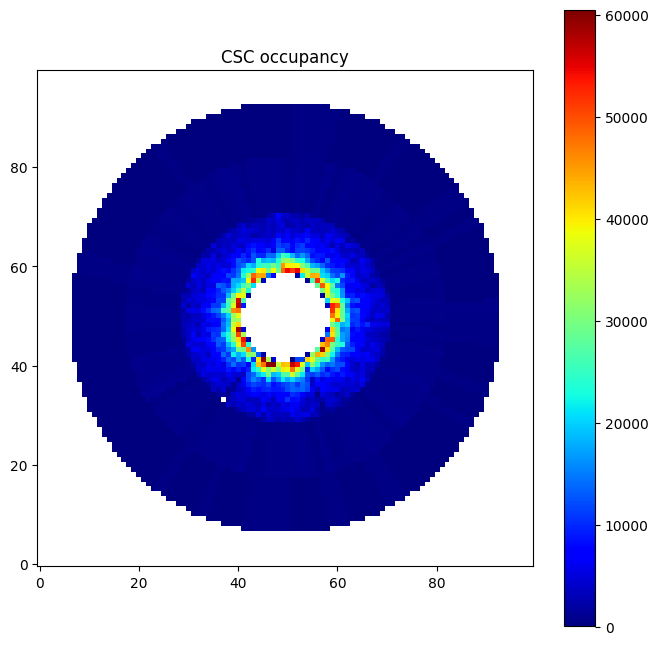

 >> AE-reco image:


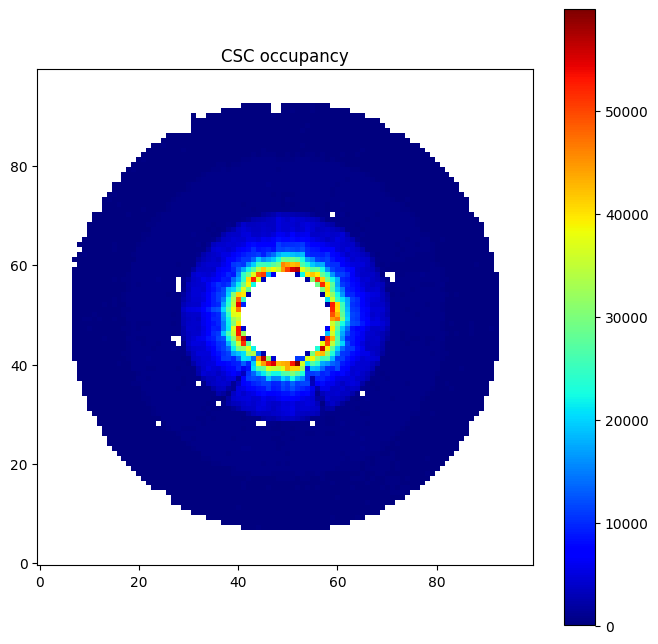

 >> Normalized loss map:


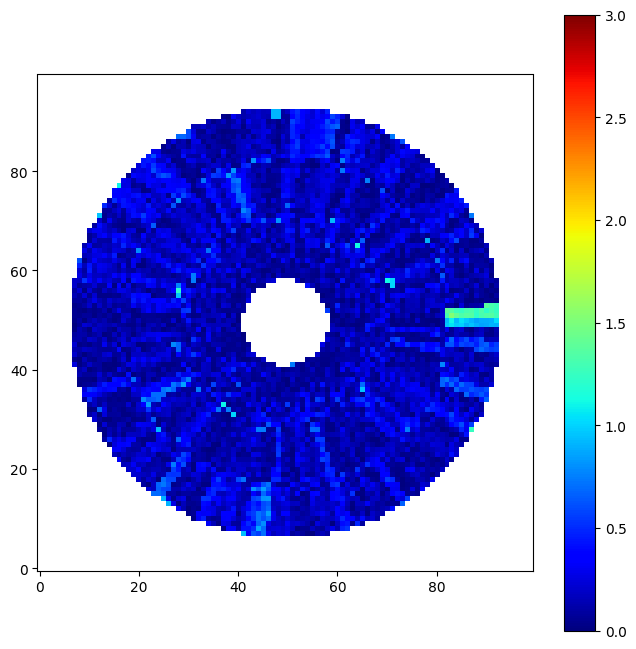

 >> Example 1
 >> Original image:


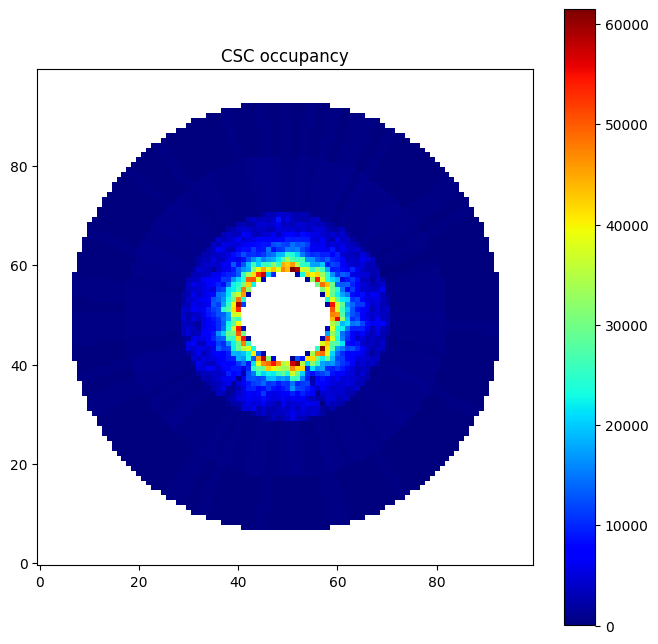

 >> AE-reco image:


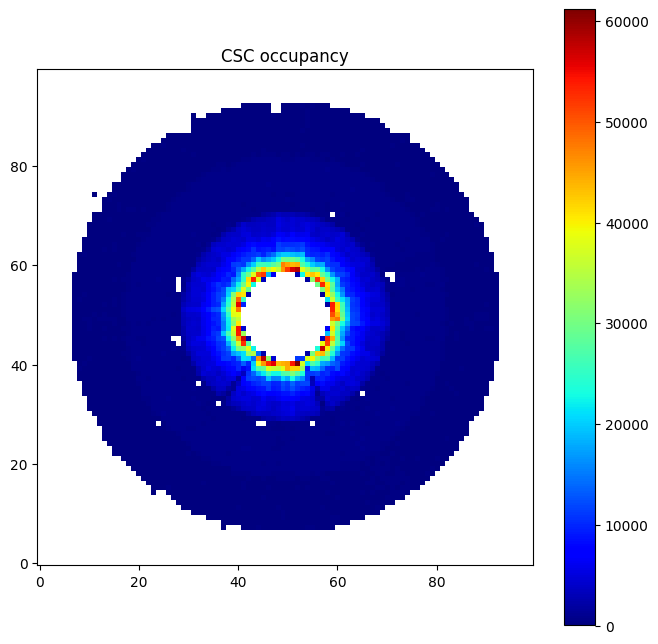

 >> Normalized loss map:


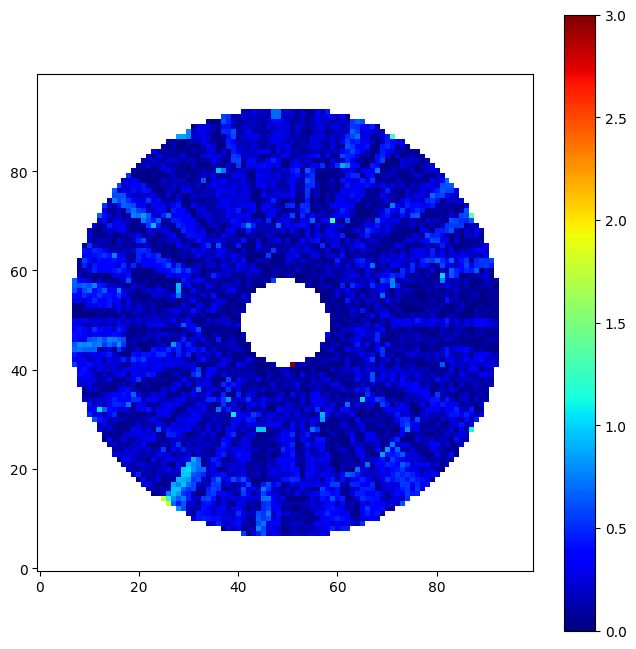

 >> Example 2
 >> Original image:


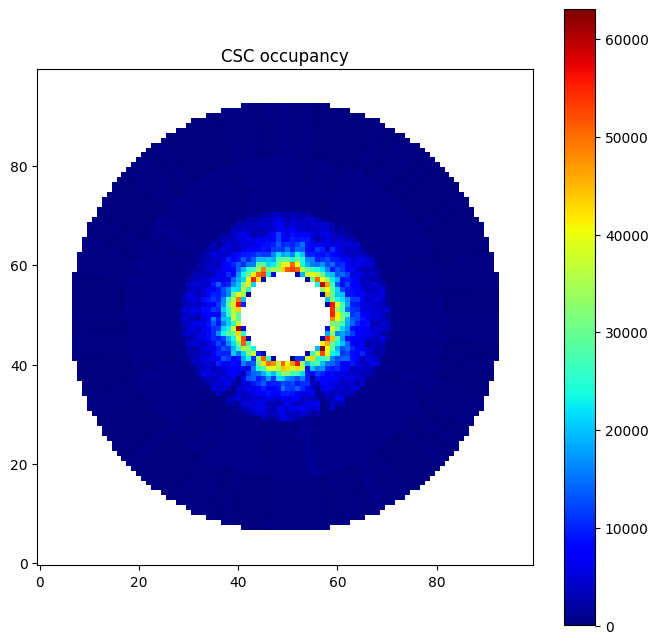

 >> AE-reco image:


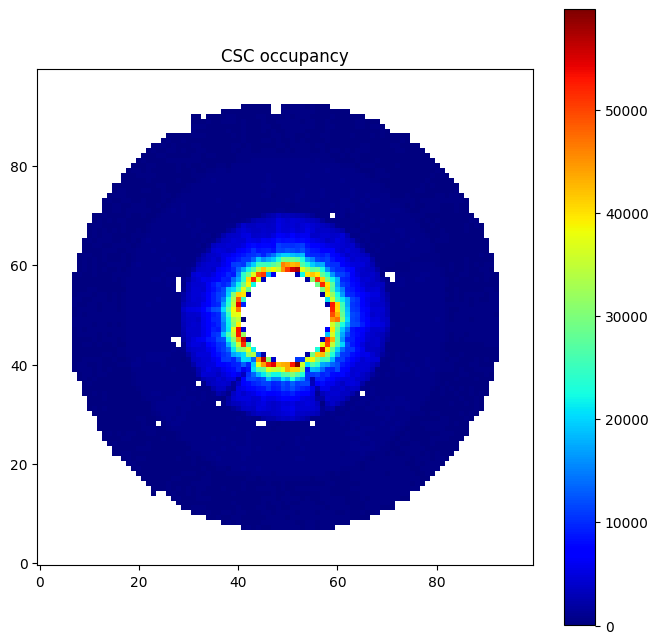

 >> Normalized loss map:


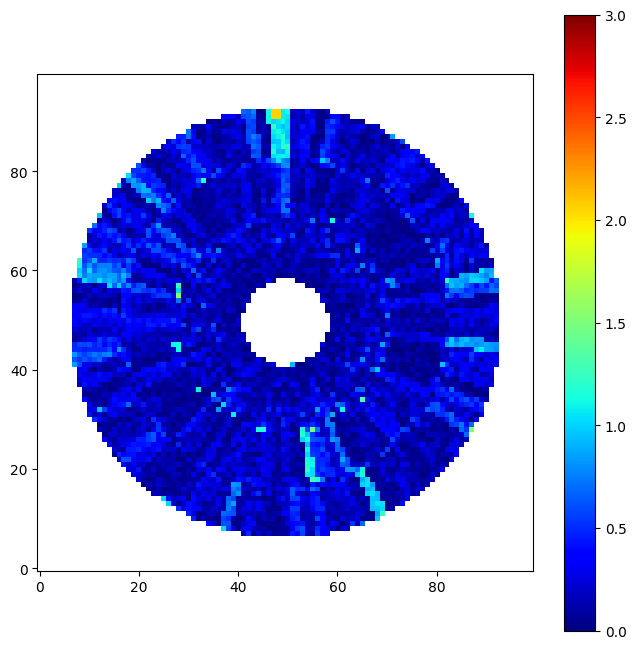

 >> Example 3
 >> Original image:


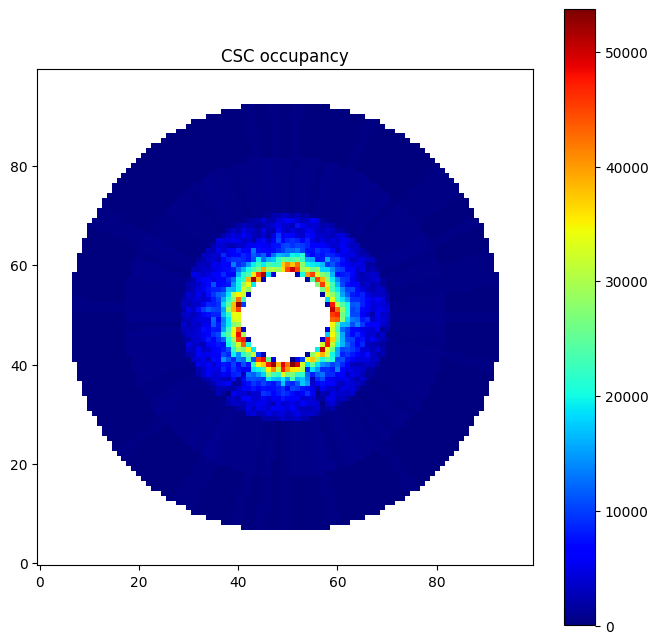

 >> AE-reco image:


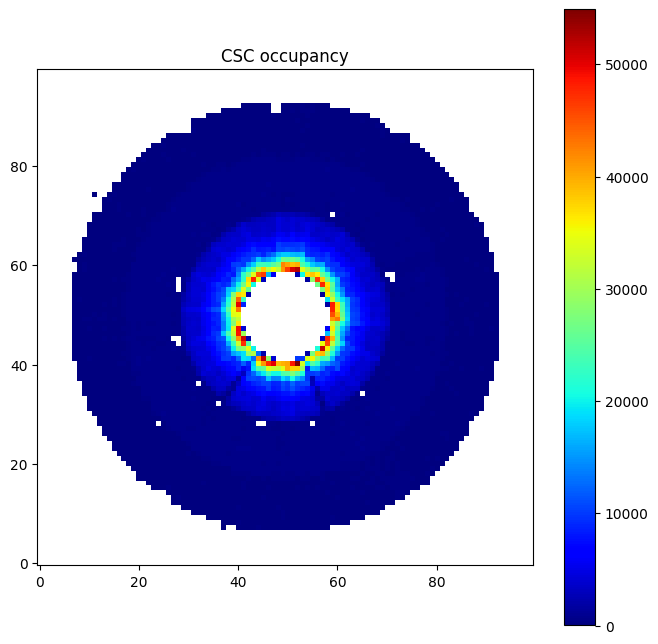

 >> Normalized loss map:


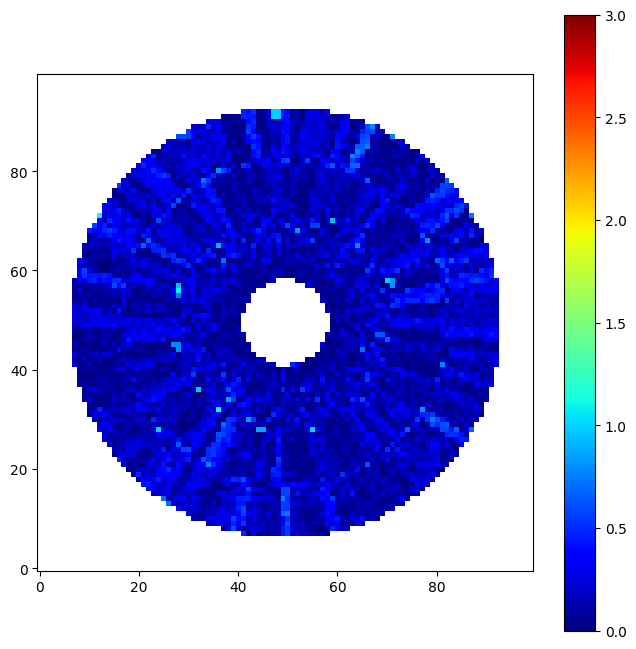

***** batch 17 *****
 >> Example 0
 >> Original image:


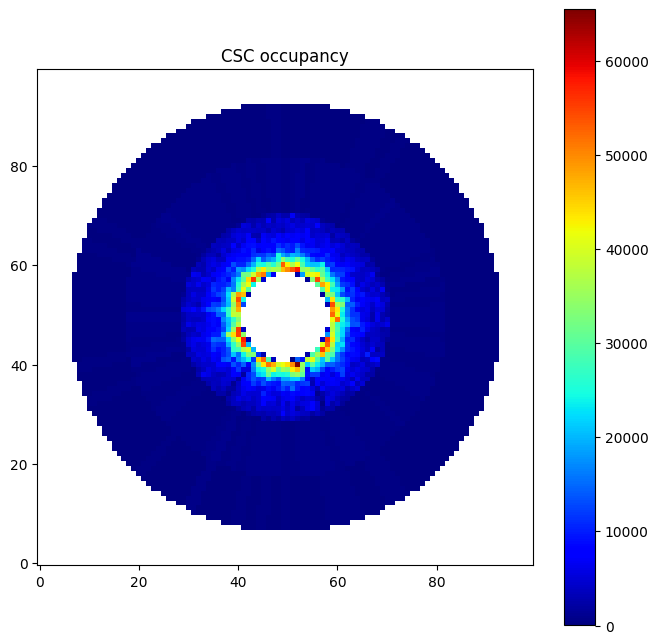

 >> AE-reco image:


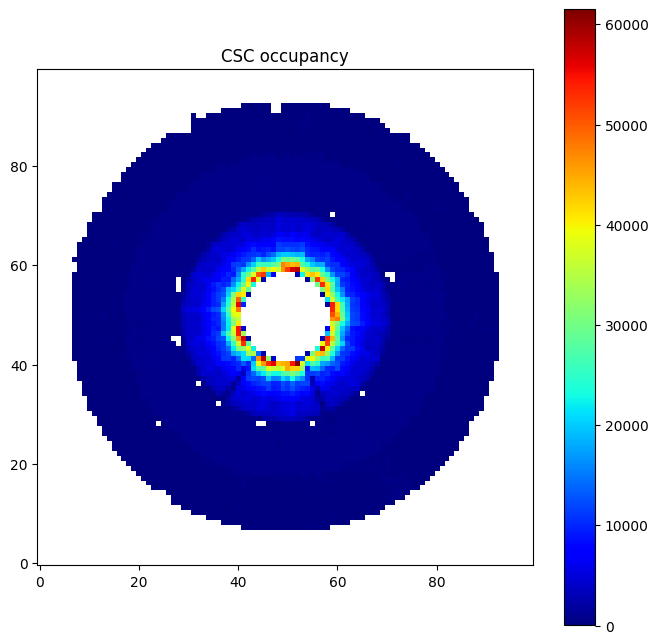

 >> Normalized loss map:


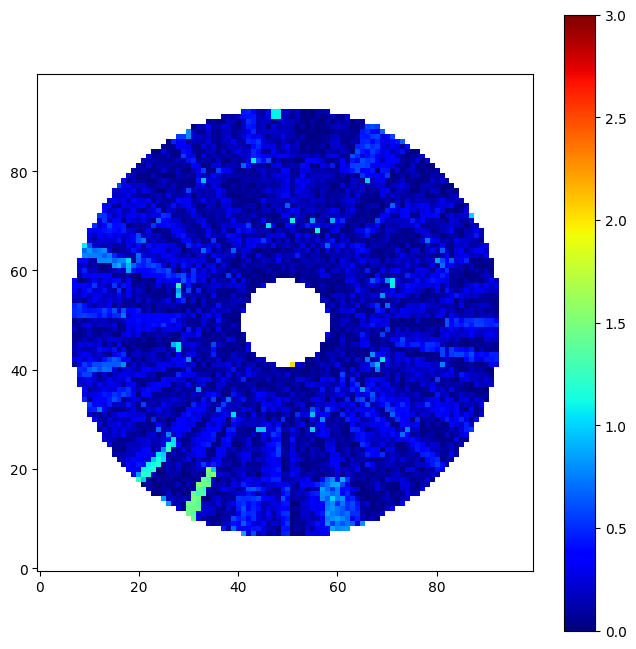

 >> Example 1
 >> Original image:


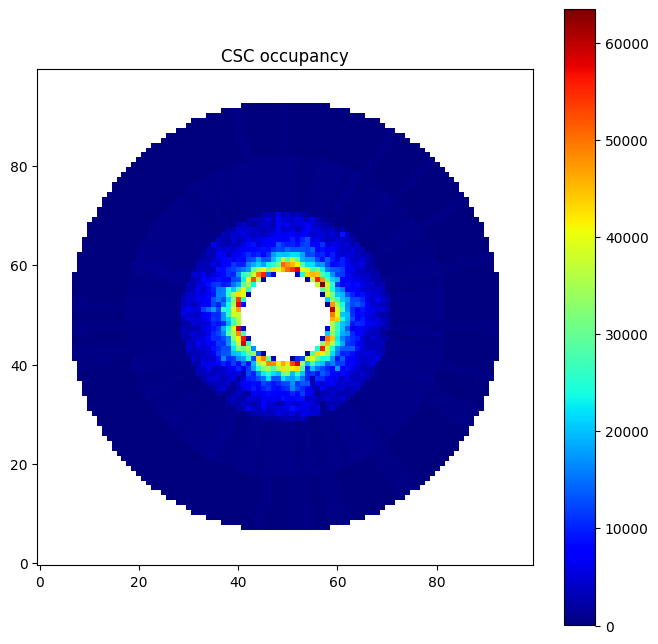

 >> AE-reco image:


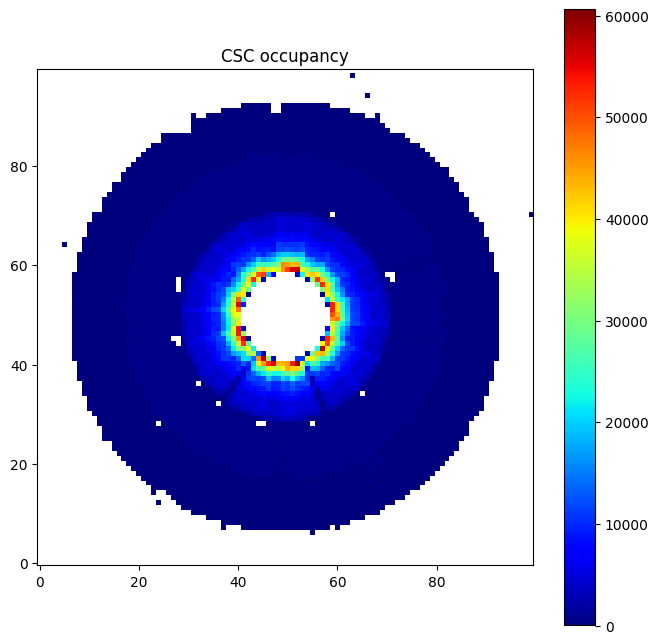

 >> Normalized loss map:


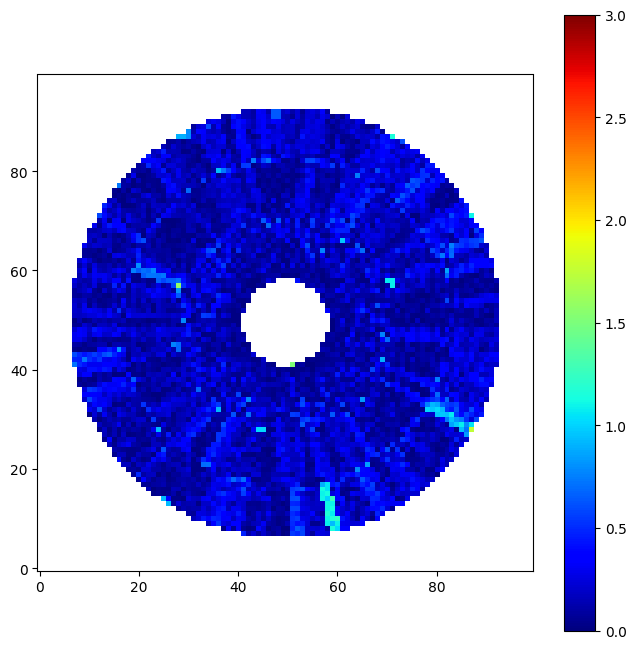

 >> Example 2
 >> Original image:


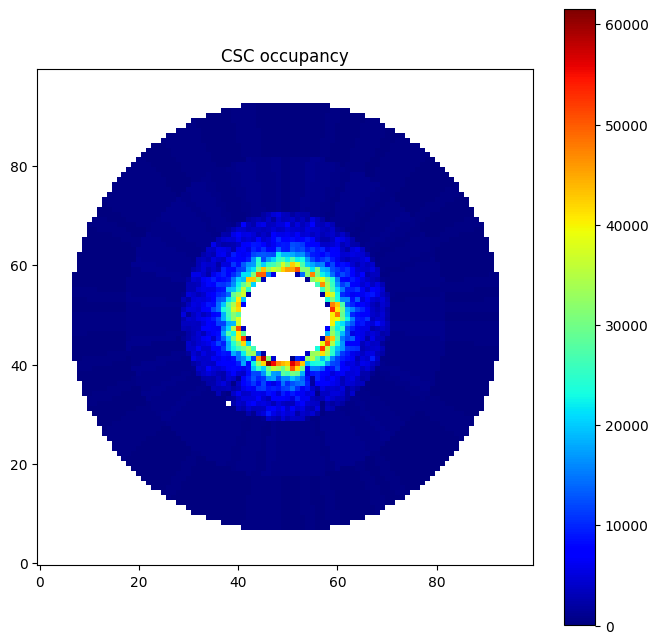

 >> AE-reco image:


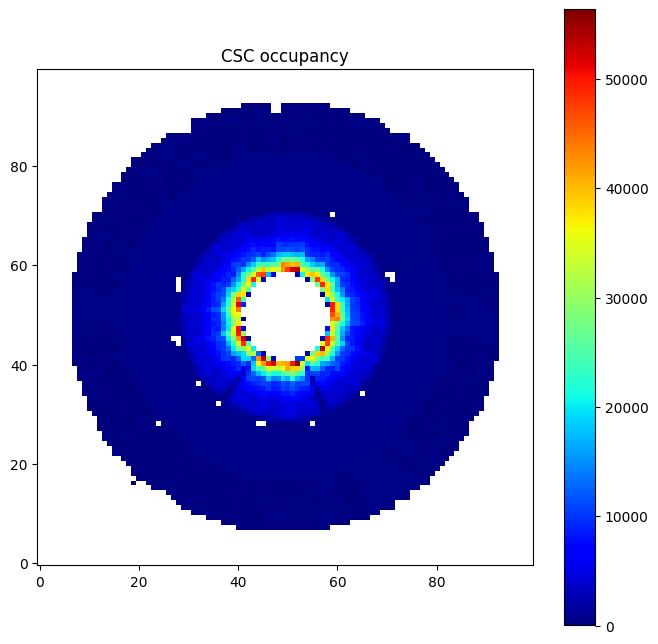

 >> Normalized loss map:


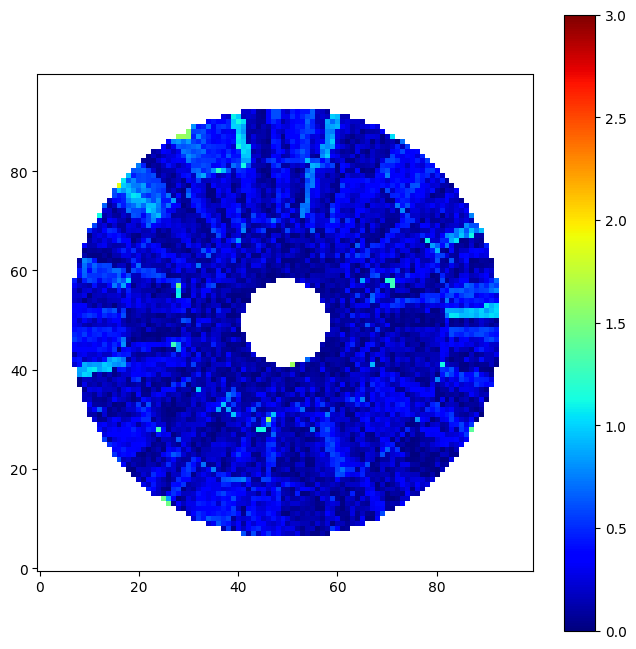

 >> Example 3
 >> Original image:


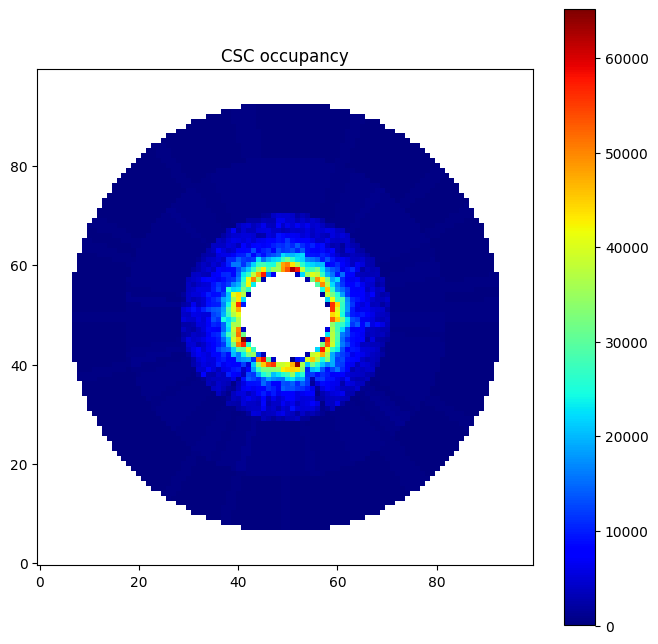

 >> AE-reco image:


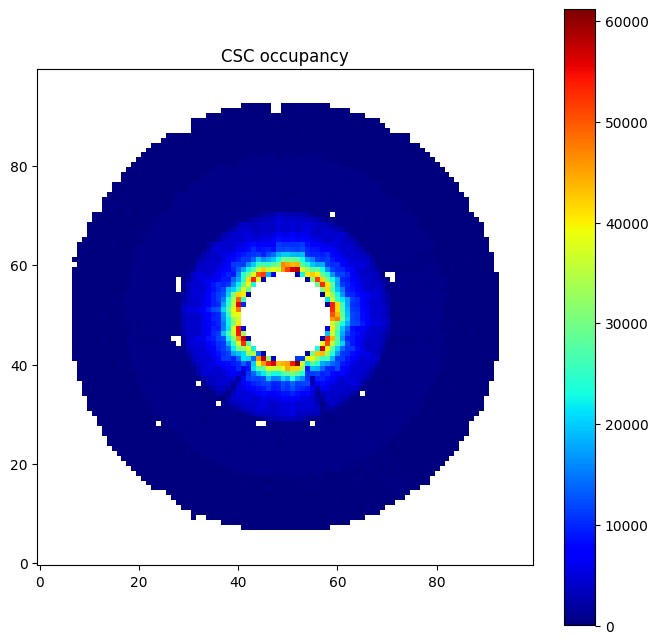

 >> Normalized loss map:


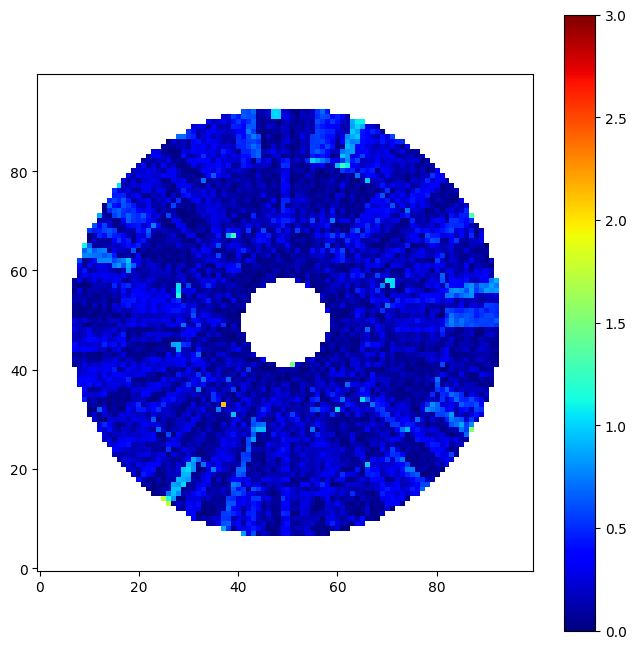

***** batch 18 *****
 >> Example 0
 >> Original image:


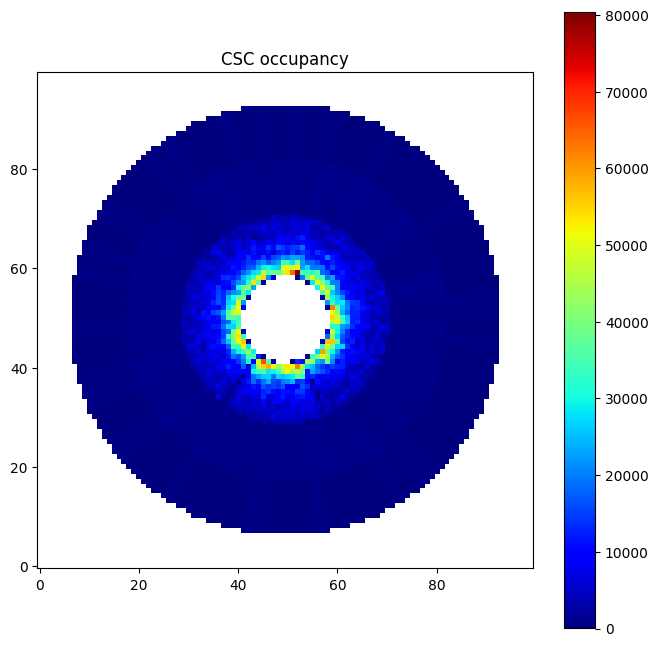

 >> AE-reco image:


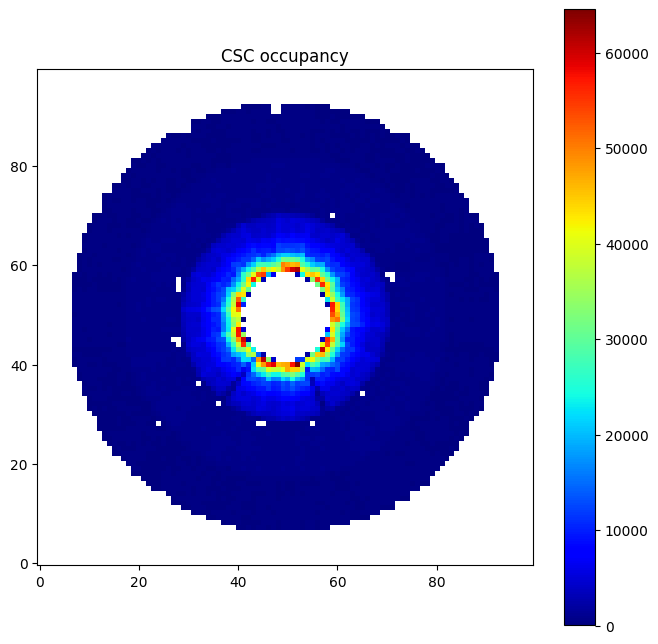

 >> Normalized loss map:


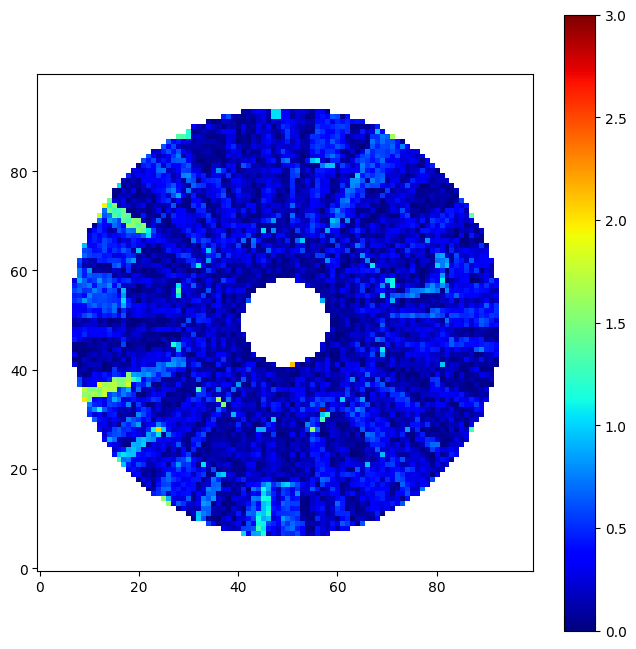

 >> Example 1
 >> Original image:


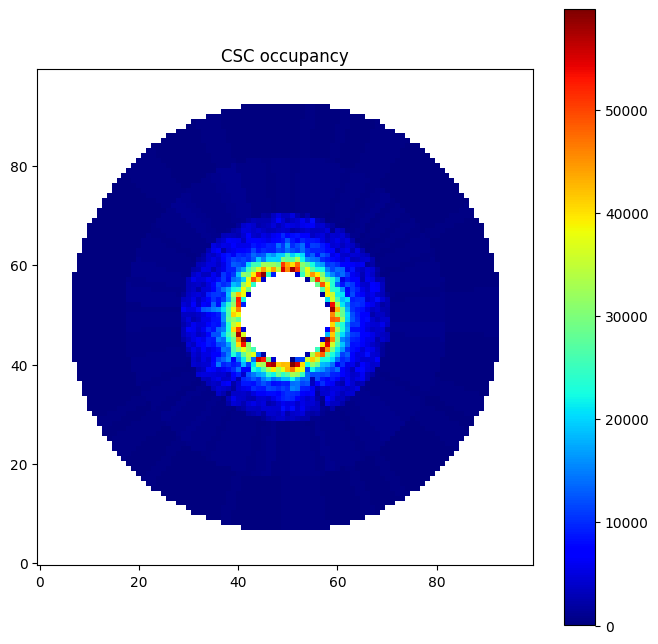

 >> AE-reco image:


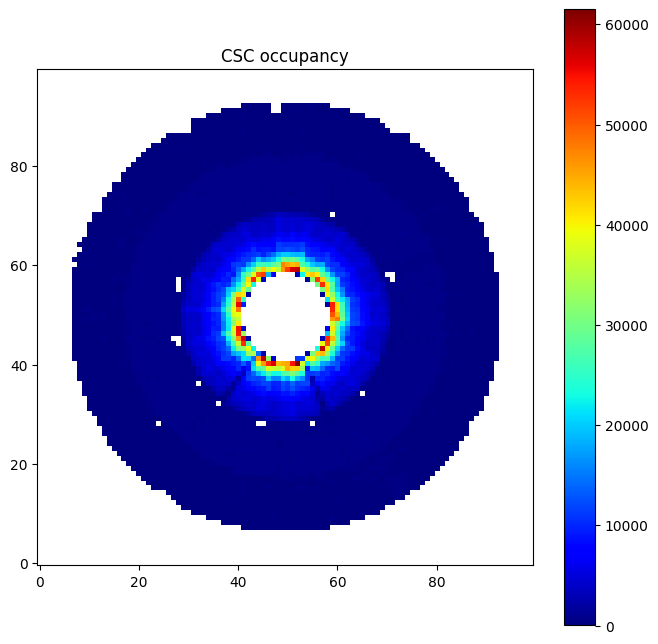

 >> Normalized loss map:


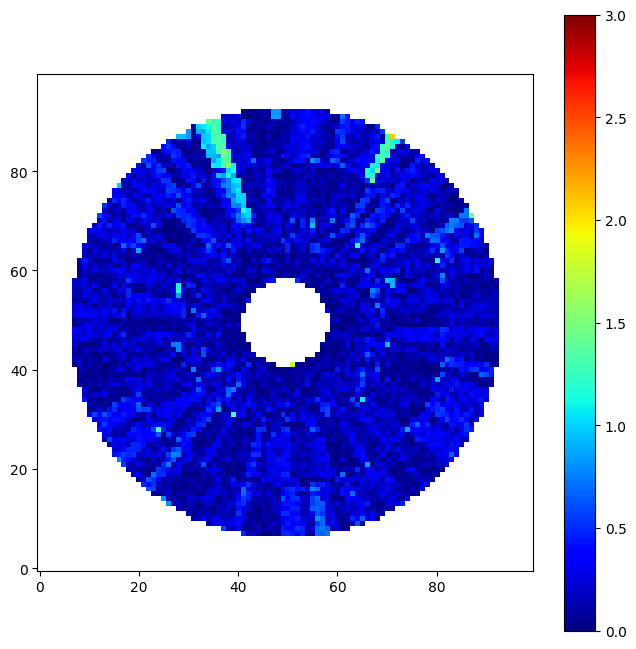

 >> Example 2
 >> Original image:


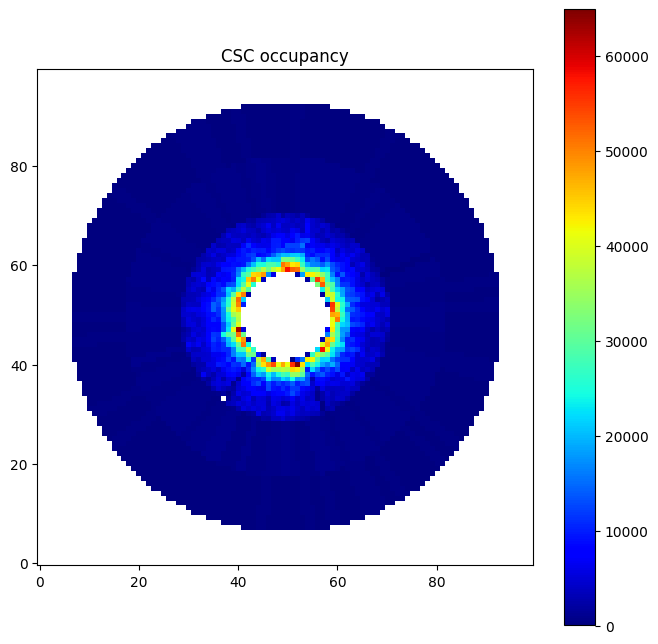

 >> AE-reco image:


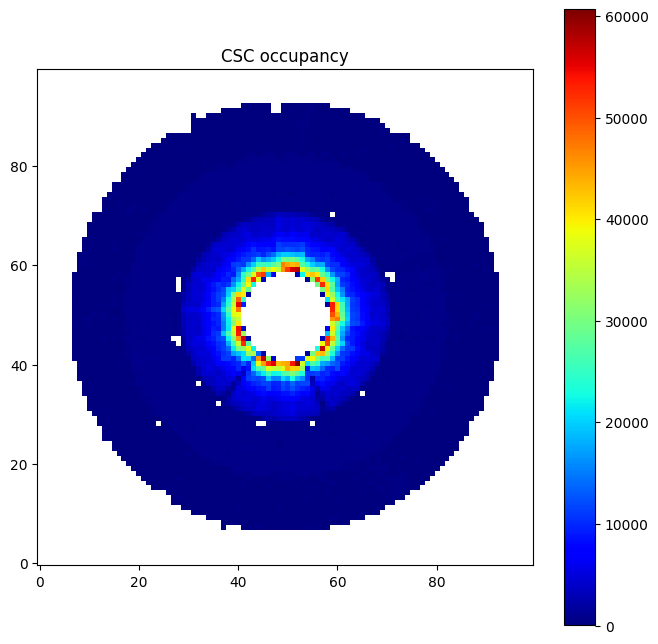

 >> Normalized loss map:


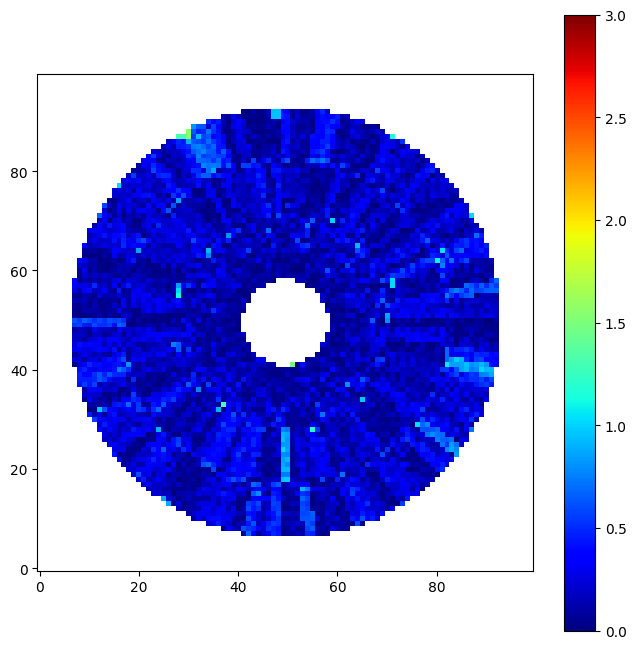

 >> Example 3
 >> Original image:


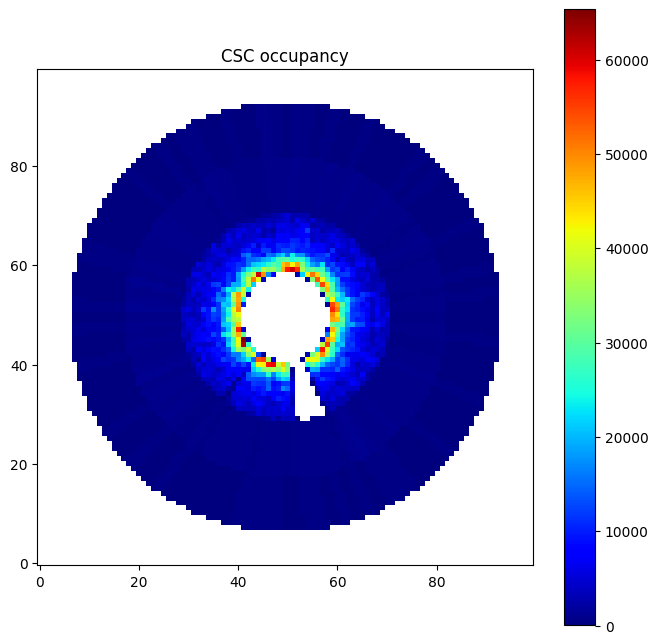

 >> AE-reco image:


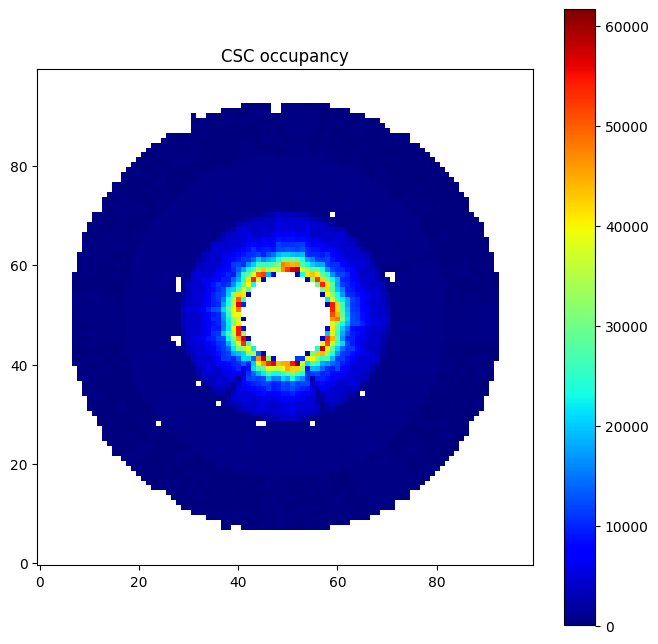

 >> Normalized loss map:


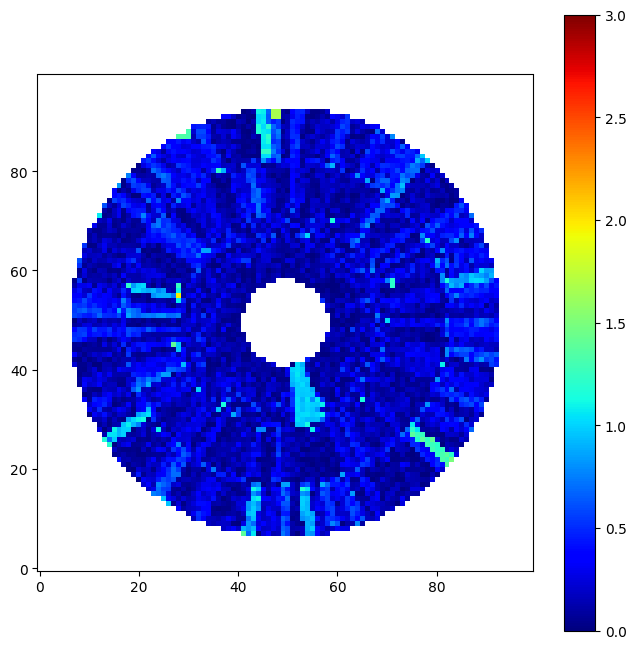

***** batch 19 *****
 >> Example 0
 >> Original image:


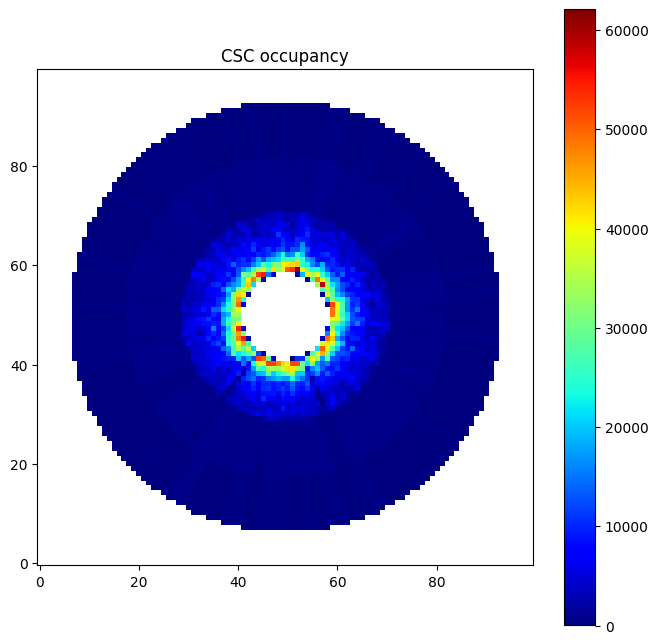

 >> AE-reco image:


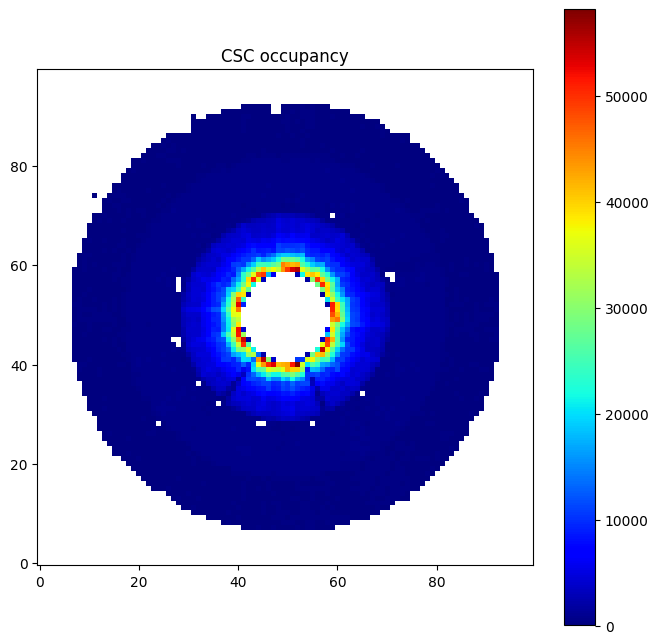

 >> Normalized loss map:


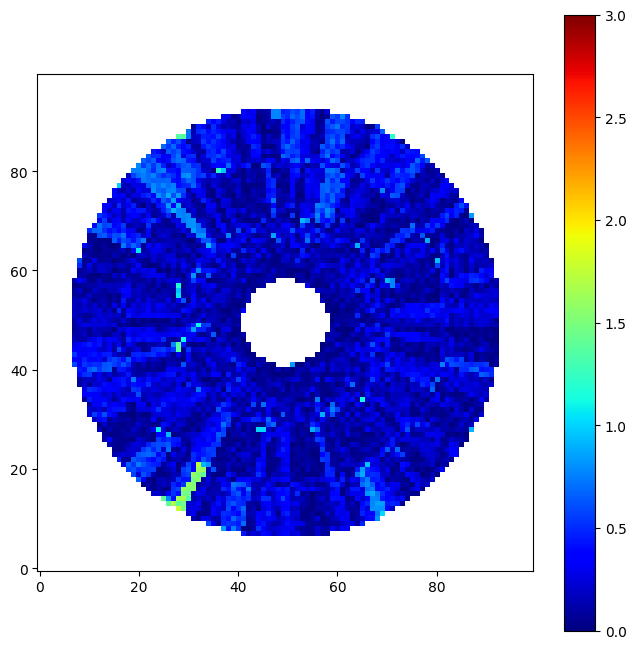

 >> Example 1
 >> Original image:


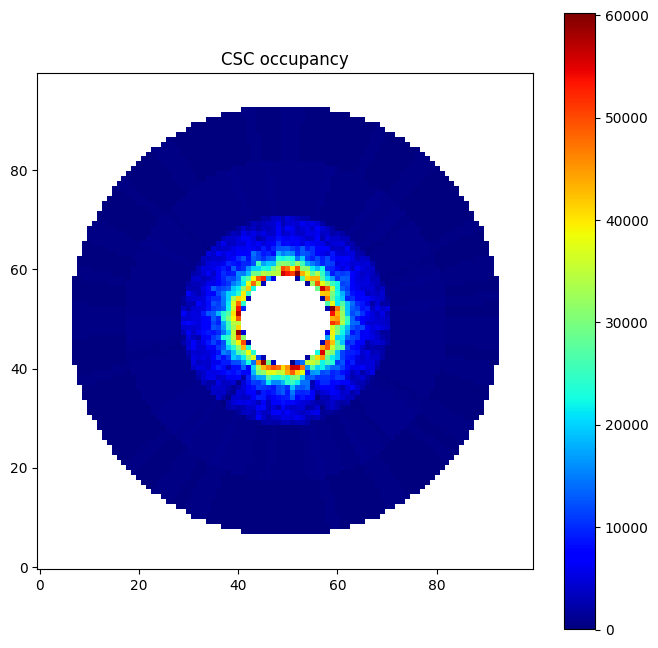

 >> AE-reco image:


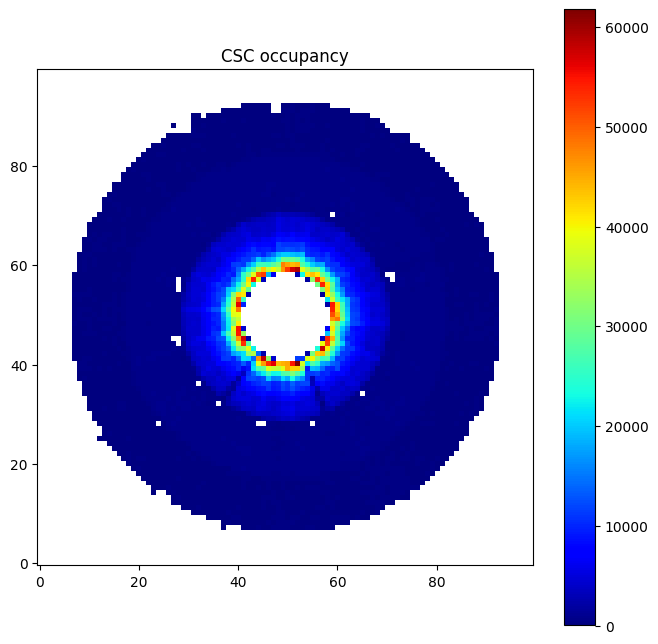

 >> Normalized loss map:


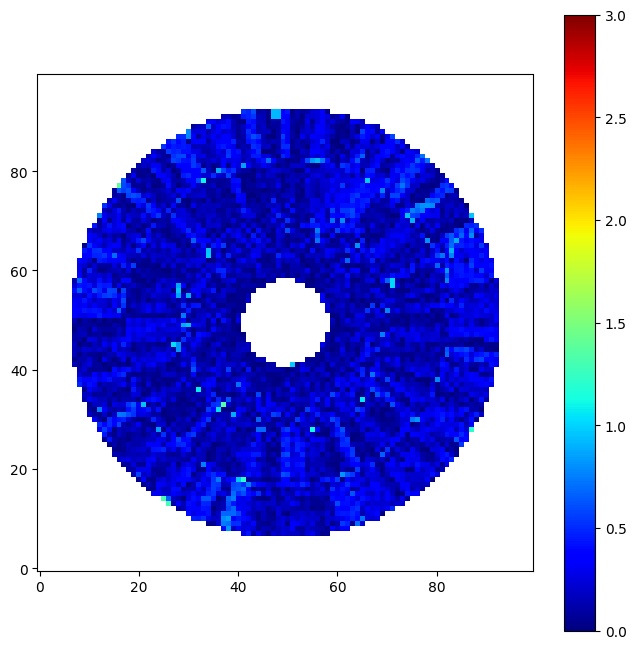

 >> Example 2
 >> Original image:


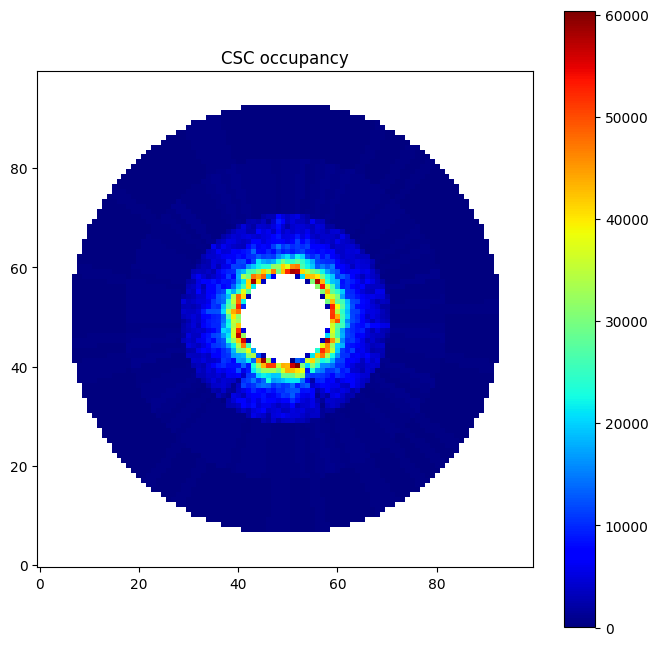

 >> AE-reco image:


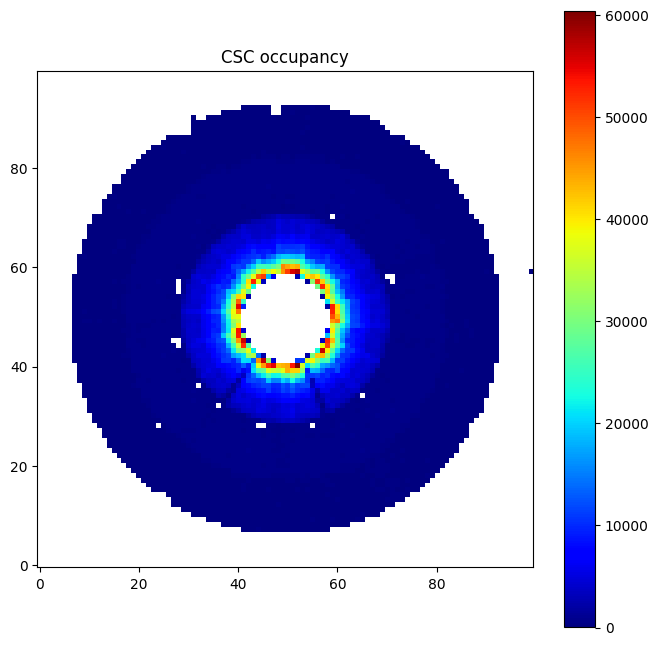

 >> Normalized loss map:


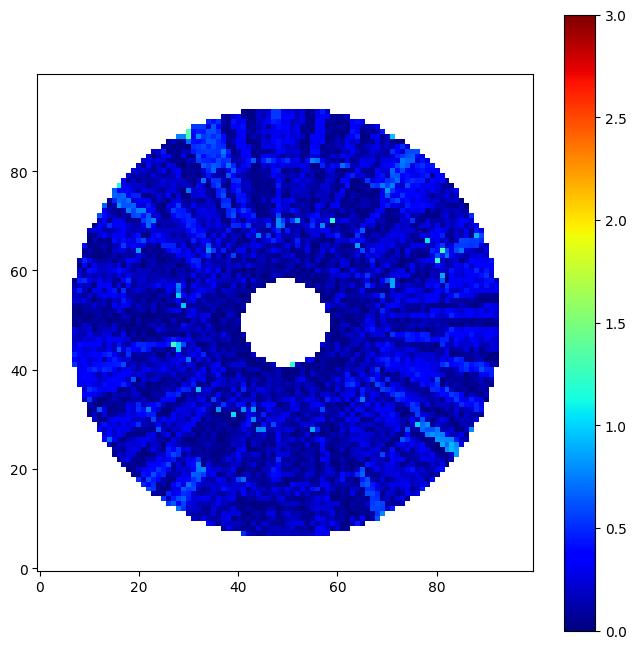

 >> Example 3
 >> Original image:


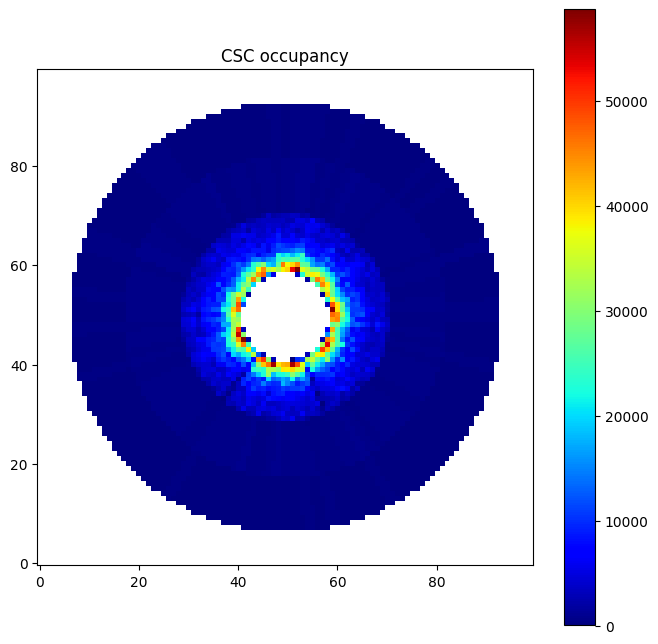

 >> AE-reco image:


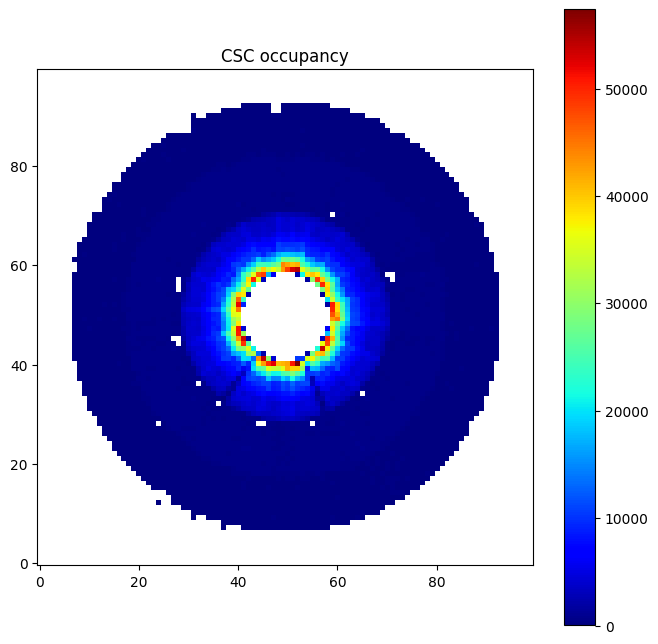

 >> Normalized loss map:


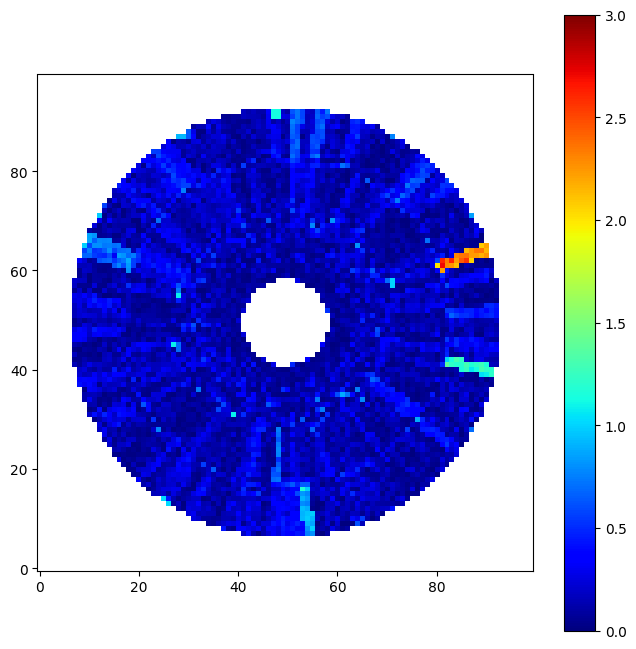

***** batch 20 *****
 >> Example 0
 >> Original image:


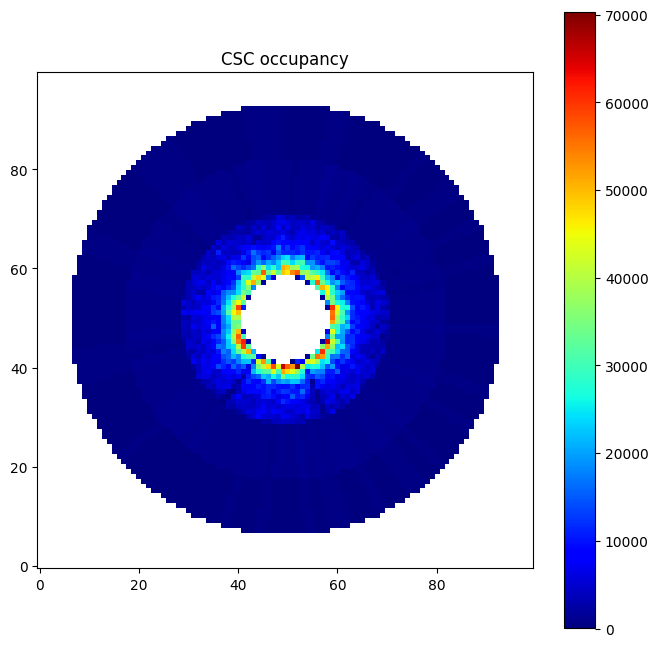

 >> AE-reco image:


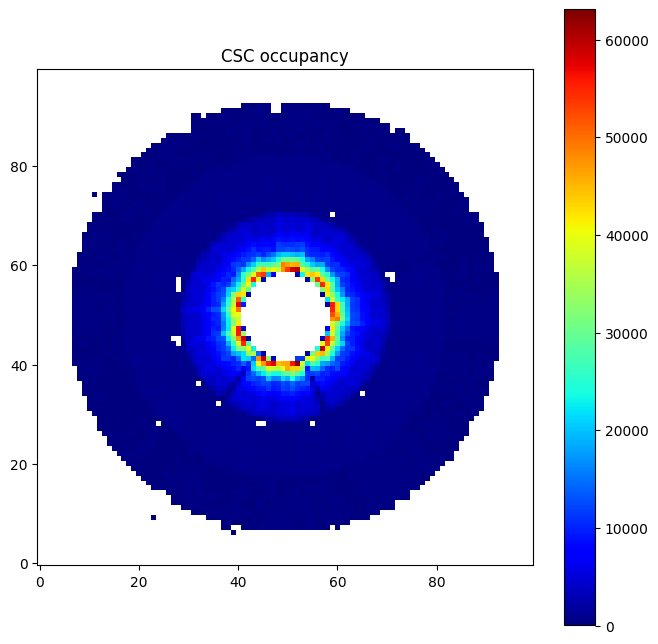

 >> Normalized loss map:


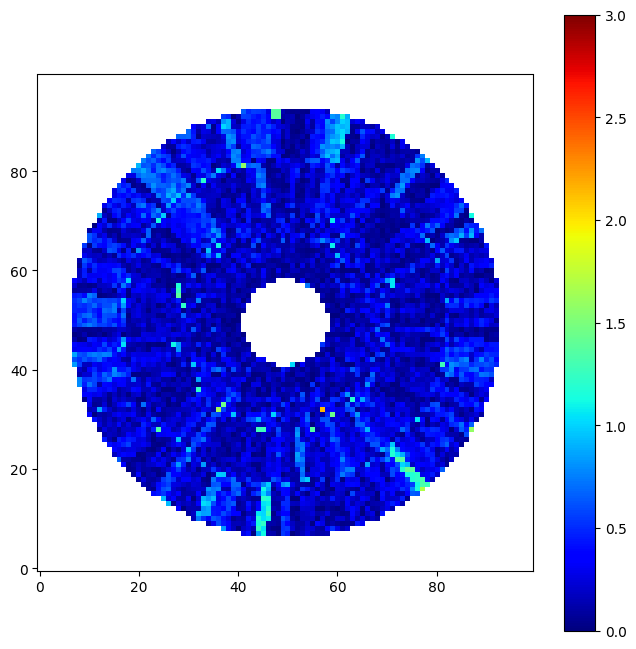

 >> Example 1
 >> Original image:


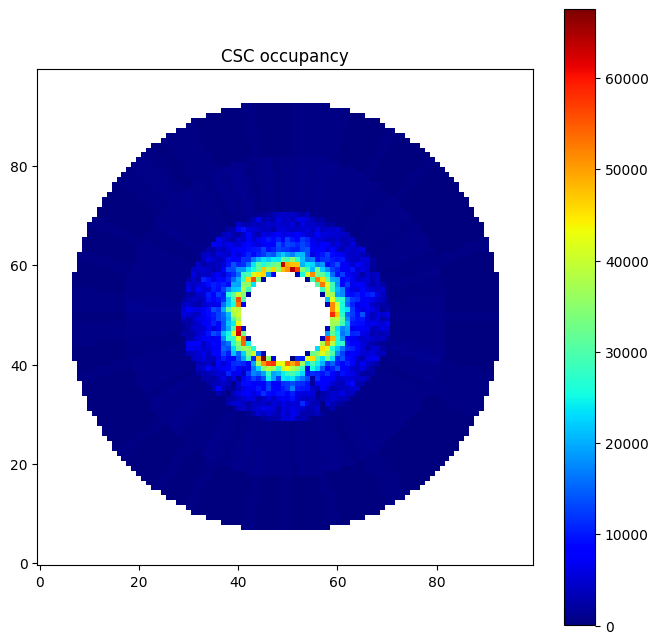

 >> AE-reco image:


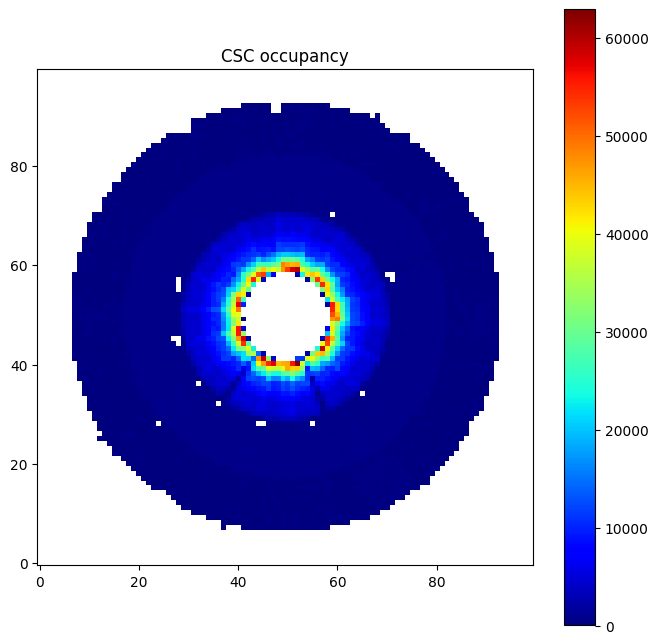

 >> Normalized loss map:


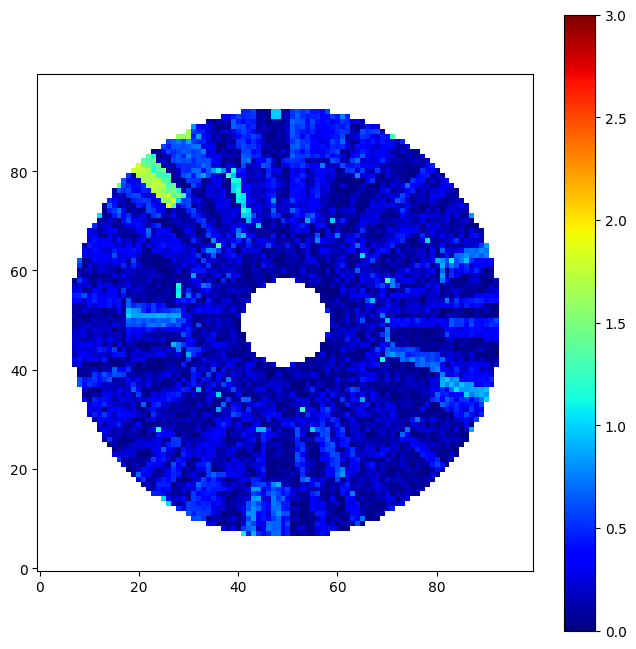

 >> Example 2
 >> Original image:


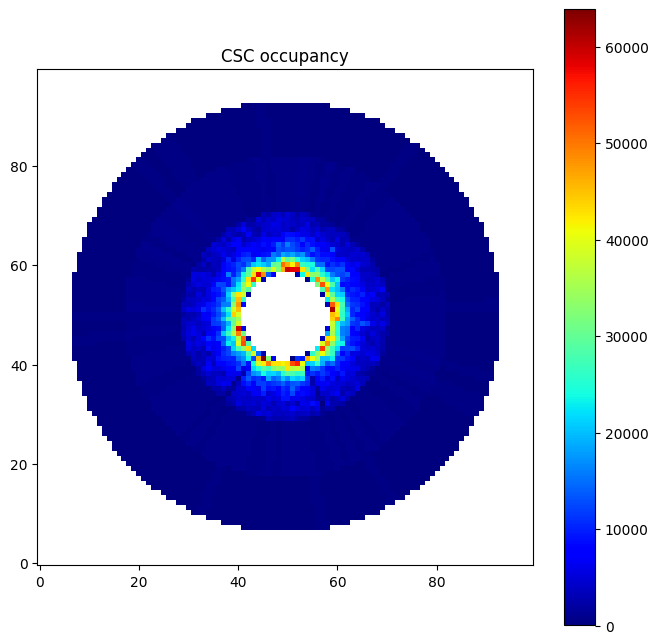

 >> AE-reco image:


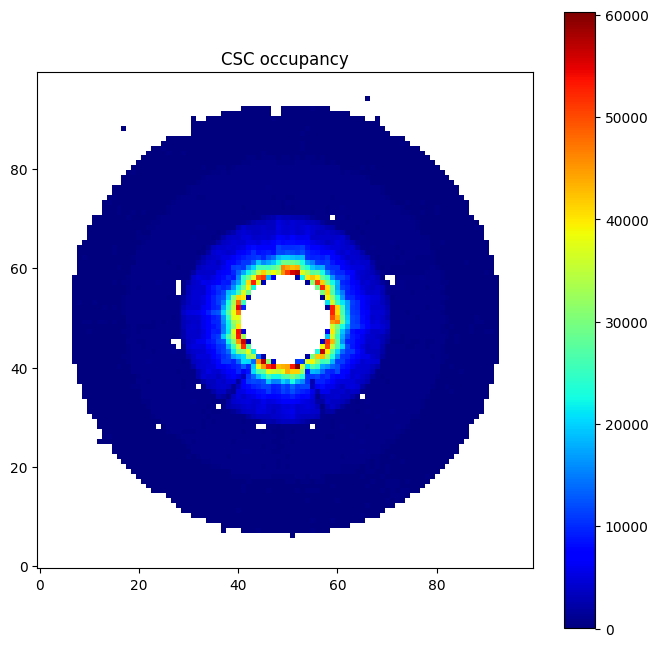

 >> Normalized loss map:


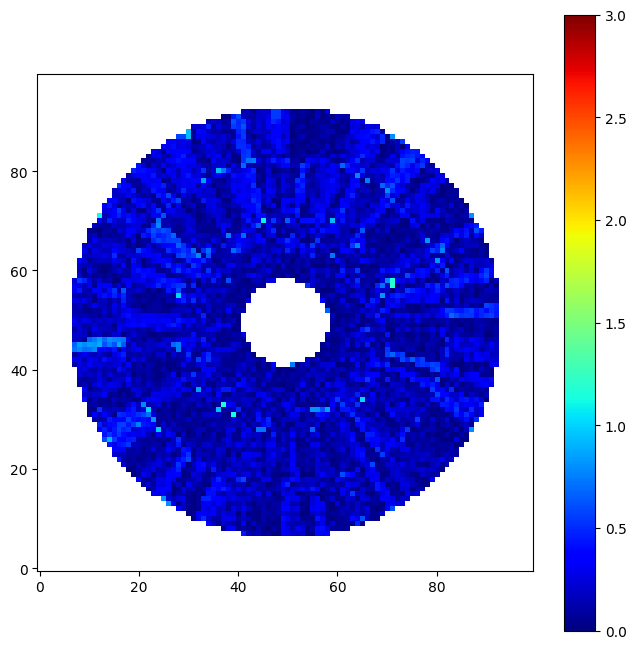

 >> Example 3
 >> Original image:


IndexError: index 3 is out of bounds for dimension 0 with size 3

In [11]:
for i, img in enumerate(validation_loader):
    img = img.to(device)
    #img = img*(img<10).float()
    reco_img = ae(img)
    print(f"***** batch {i} *****")
    #k=0
    #if True:
    for k in range(4):
        print(f" >> Example {k}")
        print(' >> Original image:')
        Show2Dimg(img[k][0].cpu().numpy())
        print(' >> AE-reco image:')
        Show2Dimg(reco_img[k][0].detach().cpu().numpy())
        print(' >> Normalized loss map:')
        img_loss = F.l1_loss(reco_img[k], img[k], reduction='none')[0].detach().cpu().numpy()
        #Show2Dimg(img_loss/mean_matrix)
        out = img_loss/mean_matrix
        fig = plt.figure(figsize =(8, 8))
        plt.imshow(out, cmap=plt.cm.jet, vmin=0, vmax=3)
        plt.gca().invert_yaxis()
        plt.colorbar()
        plt.show()